In [1]:
import os
import warnings
import numpy as np
import scipy.io as sio
import mat73
import torch
import copy
from multiprocessing import Pool
from INRmodel import calculate_combinations, ImageFitting_set, PN, input_mapping, get_mgrid, calculate_ADC, resize_array
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage.metrics import structural_similarity as ssim
from torch import nn

In [65]:
class ComplexGaborLayer2D(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega0=10.0, sigma0=10.0,
                 trainable=False):
        super().__init__()
        self.omega_0 = omega0
        self.scale_0 = sigma0
        self.is_first = is_first     
        self.in_features = in_features
        
        if self.is_first:
            dtype = torch.float
        else:
            dtype = torch.cfloat
            
        # Set trainable parameters if they are to be simultaneously optimized
        self.omega_0 = nn.Parameter(self.omega_0*torch.ones(1), trainable)
        self.scale_0 = nn.Parameter(self.scale_0*torch.ones(1), trainable)
        
        self.linear = nn.Linear(in_features,
                                out_features,
                                bias=bias,
                                dtype=dtype)
        
        # Second Gaussian window
        self.scale_orth = nn.Linear(in_features,
                                    out_features,
                                    bias=bias,
                                    dtype=dtype)
    
    def forward(self, input):
        lin = self.linear(input)
        
        scale_x = lin
        scale_y = self.scale_orth(input)
        
        freq_term = torch.exp(1j*self.omega_0*lin)
        
        arg = scale_x.abs().square() + scale_y.abs().square()
        gauss_term = torch.exp(-self.scale_0*self.scale_0*arg)
                
        return freq_term*gauss_term

In [66]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, 
                 hidden_layers, 
                 out_features,
                 first_omega_0=10, hidden_omega_0=30., scale=10.0):
        super().__init__()
        # self.net is the INR that calculates signal intensities for its inputs
 
        
        self.net = []
        
        #with torch.no_grad():
        #    self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        self.net.append(ComplexGaborLayer2D(in_features,
                                    hidden_features, 
                                    omega0=first_omega_0,
                                    sigma0=scale,
                                    is_first=True,
                                    trainable=False))

        for i in range(hidden_layers):
            self.net.append(ComplexGaborLayer2D(hidden_features, hidden_features, is_first=False, omega0=hidden_omega_0, sigma0=scale))
        dtype = torch.cfloat
        self.final_linear = nn.Linear(hidden_features, out_features, dtype=dtype)
        self.net.append(self.final_linear)

        self.net = nn.Sequential(*self.net)
        
    def forward(self, coords):
        #coords = coords.clone().detach().requires_grad_(False)
        output = self.net(coords)

        return  output.real

In [4]:
pt_id = 65
data_address = f'/home/gundogdu/Desktop/pat{pt_id:03d}/master.mat'
output_address = f'/home/gundogdu/Desktop/SR_results_test1/pat{pt_id:03d}'

In [5]:
print('Loading data')
try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address)
print('Data loaded')
hybrid_raw = data['hybrid_raw']
image_shape = hybrid_raw[0][0].shape
hybrid_raw_norm = copy.deepcopy(hybrid_raw)
maxes = np.zeros((4,4))

for b in range(4):
    for te in range(4):
        maxes[b, te] = hybrid_raw_norm[b][te].max()
        hybrid_raw_norm[b][te] = hybrid_raw_norm[b][te]/maxes[b, te]
        num_processes = 32

Loading data


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: images.roi.Freehand, (uint32)


Data loaded


In [6]:
pool = Pool(processes=num_processes)

voxel_list = [(i, j, k) for i in range(image_shape[0])
                        for j in range(image_shape[1])
                        for k in range(image_shape[2])]
print('Calculating all combinations in parallel')
results = pool.starmap(calculate_combinations, [(voxel, hybrid_raw_norm) for voxel in voxel_list])
pool.close()
pool.join()
acquisitions = np.zeros((image_shape[0], 
            image_shape[1], 
            image_shape[2],
            4,
            hybrid_raw[1][0].shape[3]*hybrid_raw[2][0].shape[3]*hybrid_raw[3][0].shape[3]))

for idx, voxel in enumerate(voxel_list):
    i, j, k = voxel
    acquisitions[i, j, k, :, :] = results[idx]

print('Done calculating')

Calculating all combinations in parallel
Done calculating


In [45]:
select_acquisitions = np.squeeze(acquisitions)
mean_img = np.mean(select_acquisitions,-1)
mapping_size = 256
scale = 0.5
hidden_dim = 256
num_layers = 3
PN_dim = 128
roi_start = 45
roi_end = 75
number_of_epochs = 2500
pertubation_epochs = 3 #This corresponds to 1000 steps total for each acquisition


img_dataset = []
for inx in range(select_acquisitions.shape[-1]):
    img = select_acquisitions[roi_start:roi_end:2, roi_start:roi_end:2, :, :, inx]
    img_dataset.append(img)

mean_dataset = ImageFitting_set([mean_img[roi_start:roi_end:2, roi_start:roi_end:2, :]])
dataset = ImageFitting_set(img_dataset)
dimension = len(dataset.shape)
HR = ImageFitting_set([mean_img[roi_start:roi_end, roi_start:roi_end, :]])



B_gauss = np.random.normal(size=(mapping_size, dimension))
B = torch.from_numpy(B_gauss * scale).float().cuda()

In [67]:
INR = Siren(in_features=2*mapping_size, out_features=1, 
                hidden_features=int(hidden_dim//2),
                hidden_layers=num_layers,
                first_omega_0=1.2, hidden_omega_0=1.2, scale=1.2)

In [68]:
INR.cuda()
PerturbNet = PN(in_features=2*mapping_size, hidden_features=PN_dim, dimension=dimension)
PerturbNet.cuda()

inr_params = list(INR.parameters())
inr_optim = torch.optim.Adam(lr=5e-5, params=inr_params)
perturb_params = list(PerturbNet.parameters())
perturb_optim = torch.optim.Adam(lr=1e-6, params=perturb_params)
torch.cuda.empty_cache()

In [69]:
LR_ground_truth, model_input  = mean_dataset.pixels[0].cuda(), mean_dataset.coords[0].cuda()
model_input = input_mapping(model_input, B)
HR_model_input  = HR.coords[0].cuda()
HR_model_input = input_mapping(HR_model_input, B)
test_input_shape = (HR.shape[0]*2, HR.shape[1]*2, HR.shape[2], HR.shape[3])
test_input  = get_mgrid(test_input_shape).cuda()
test_input  = input_mapping(test_input, B)

HR_img = mean_img[roi_start:roi_end, roi_start:roi_end, :, :]

Training the INR and Perturb-Net for mapping size = 256 and sigma = 0.5


  0%|          | 0/2500 [00:00<?, ?it/s]

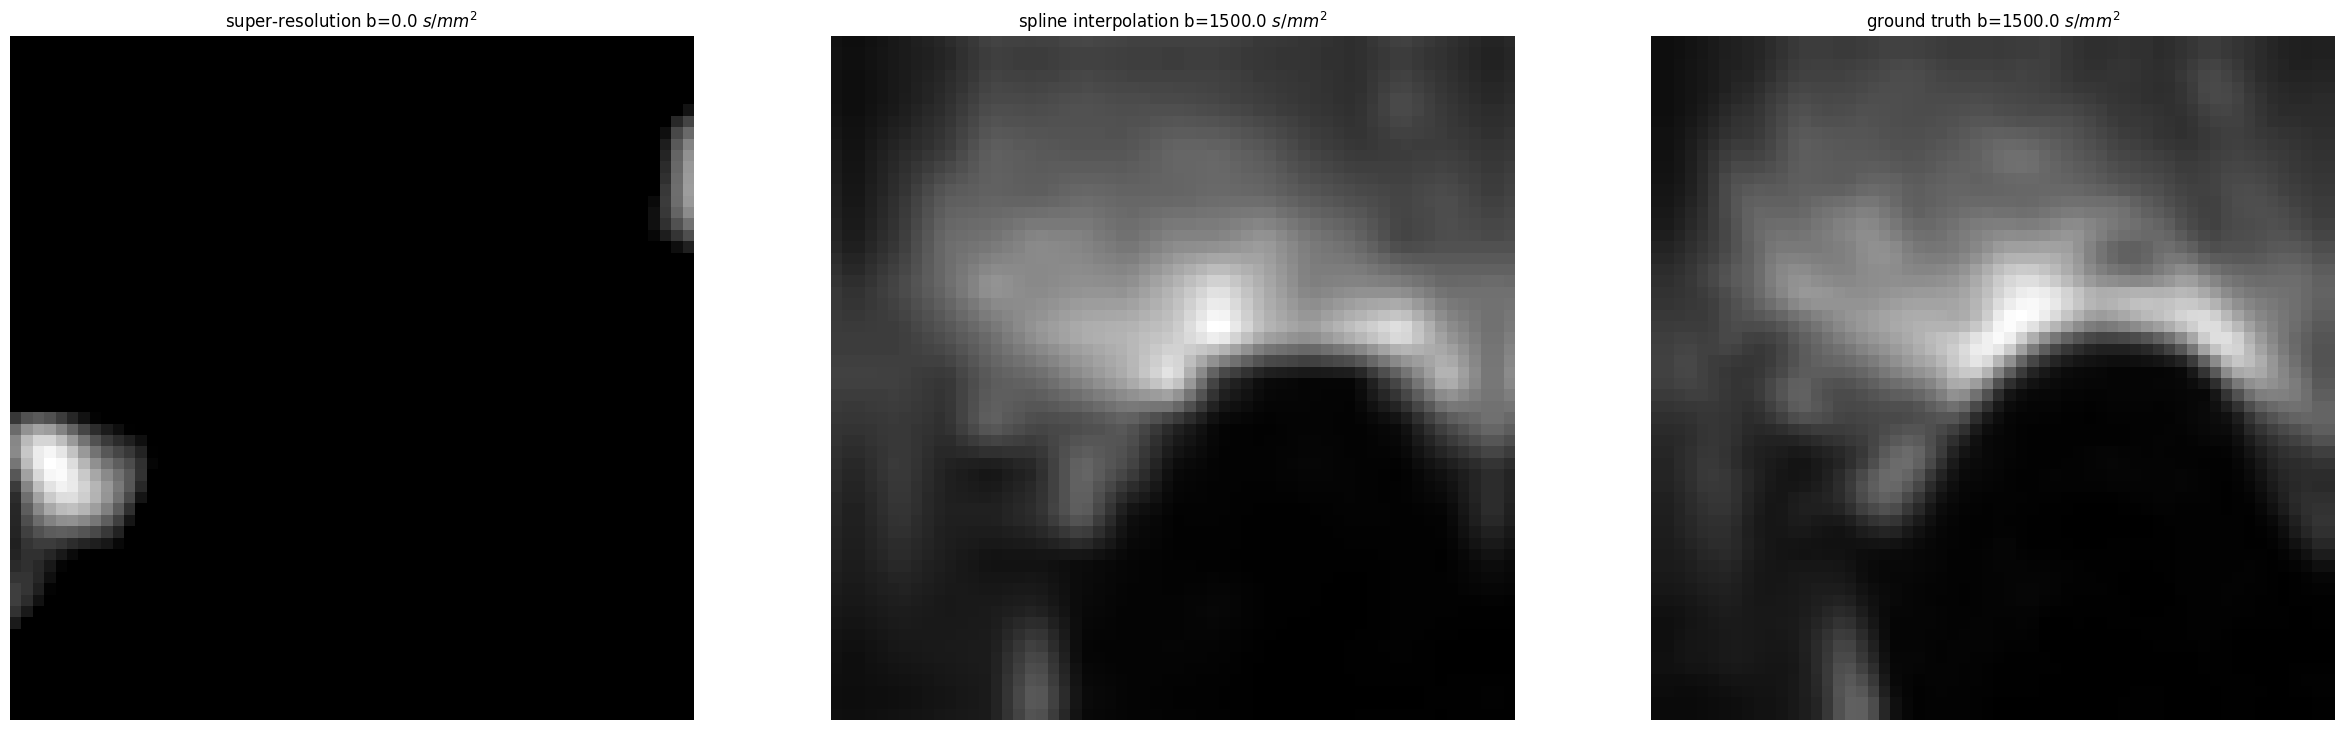

  2%|▏         | 47/2500 [00:01<00:55, 44.03it/s]

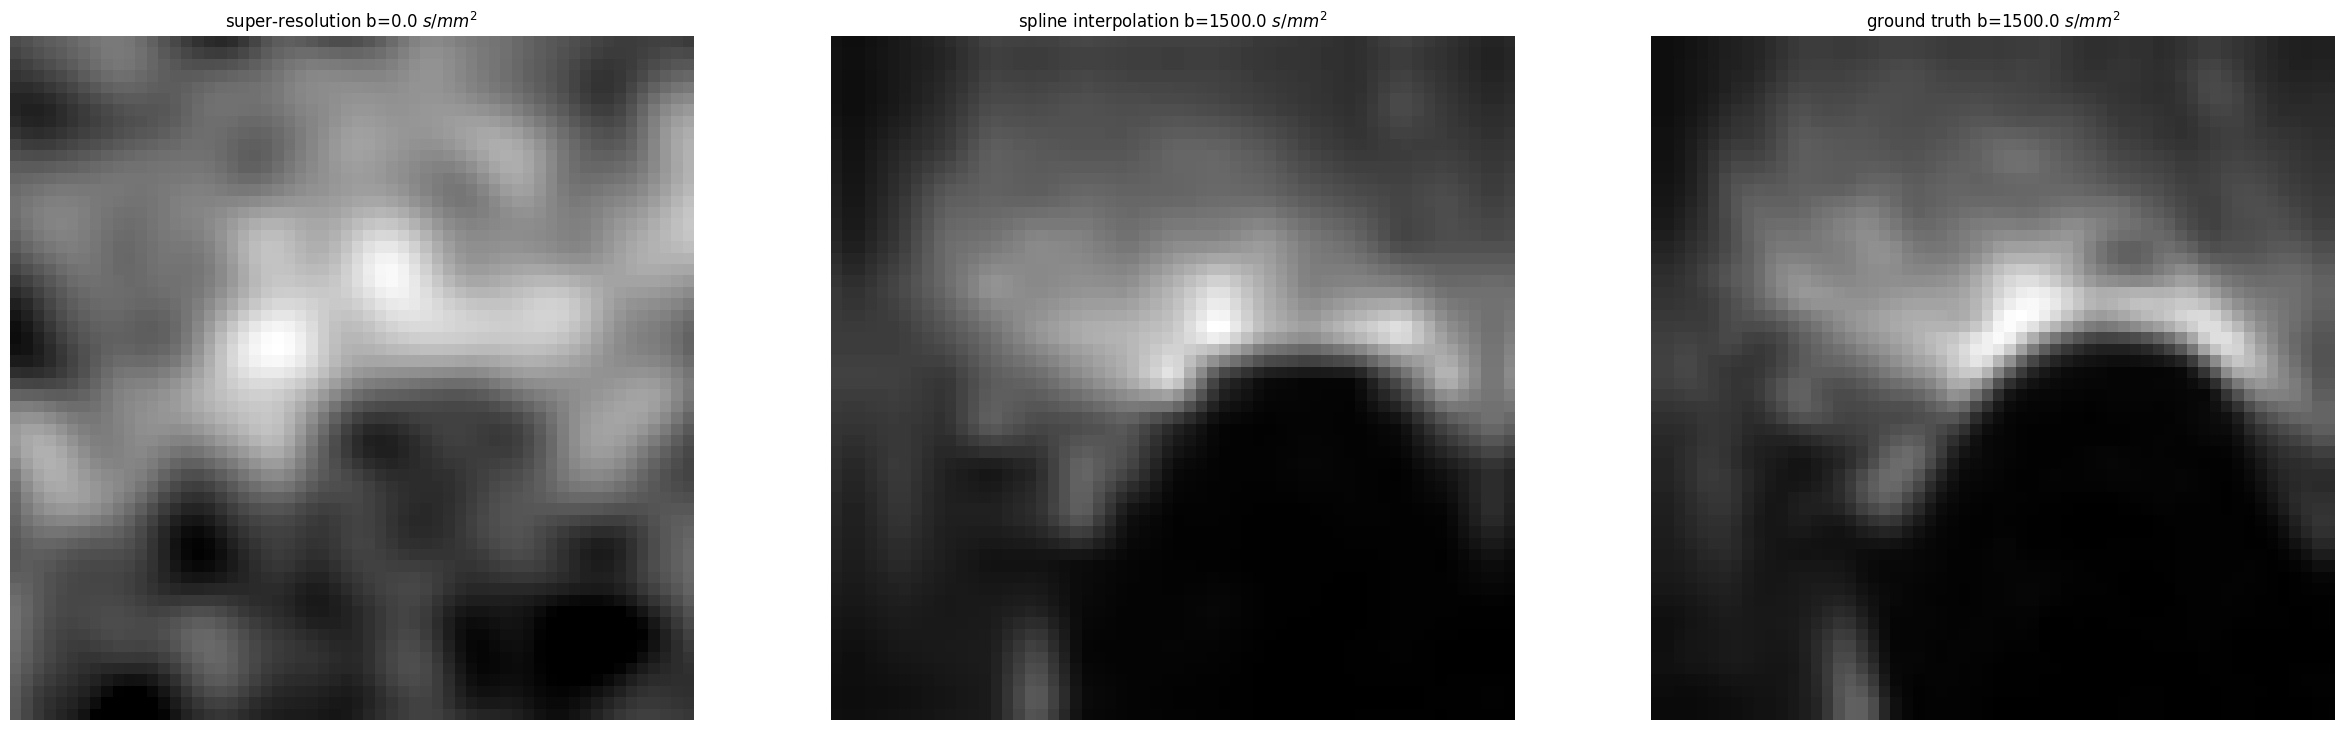

  4%|▍         | 98/2500 [00:03<00:54, 43.80it/s]

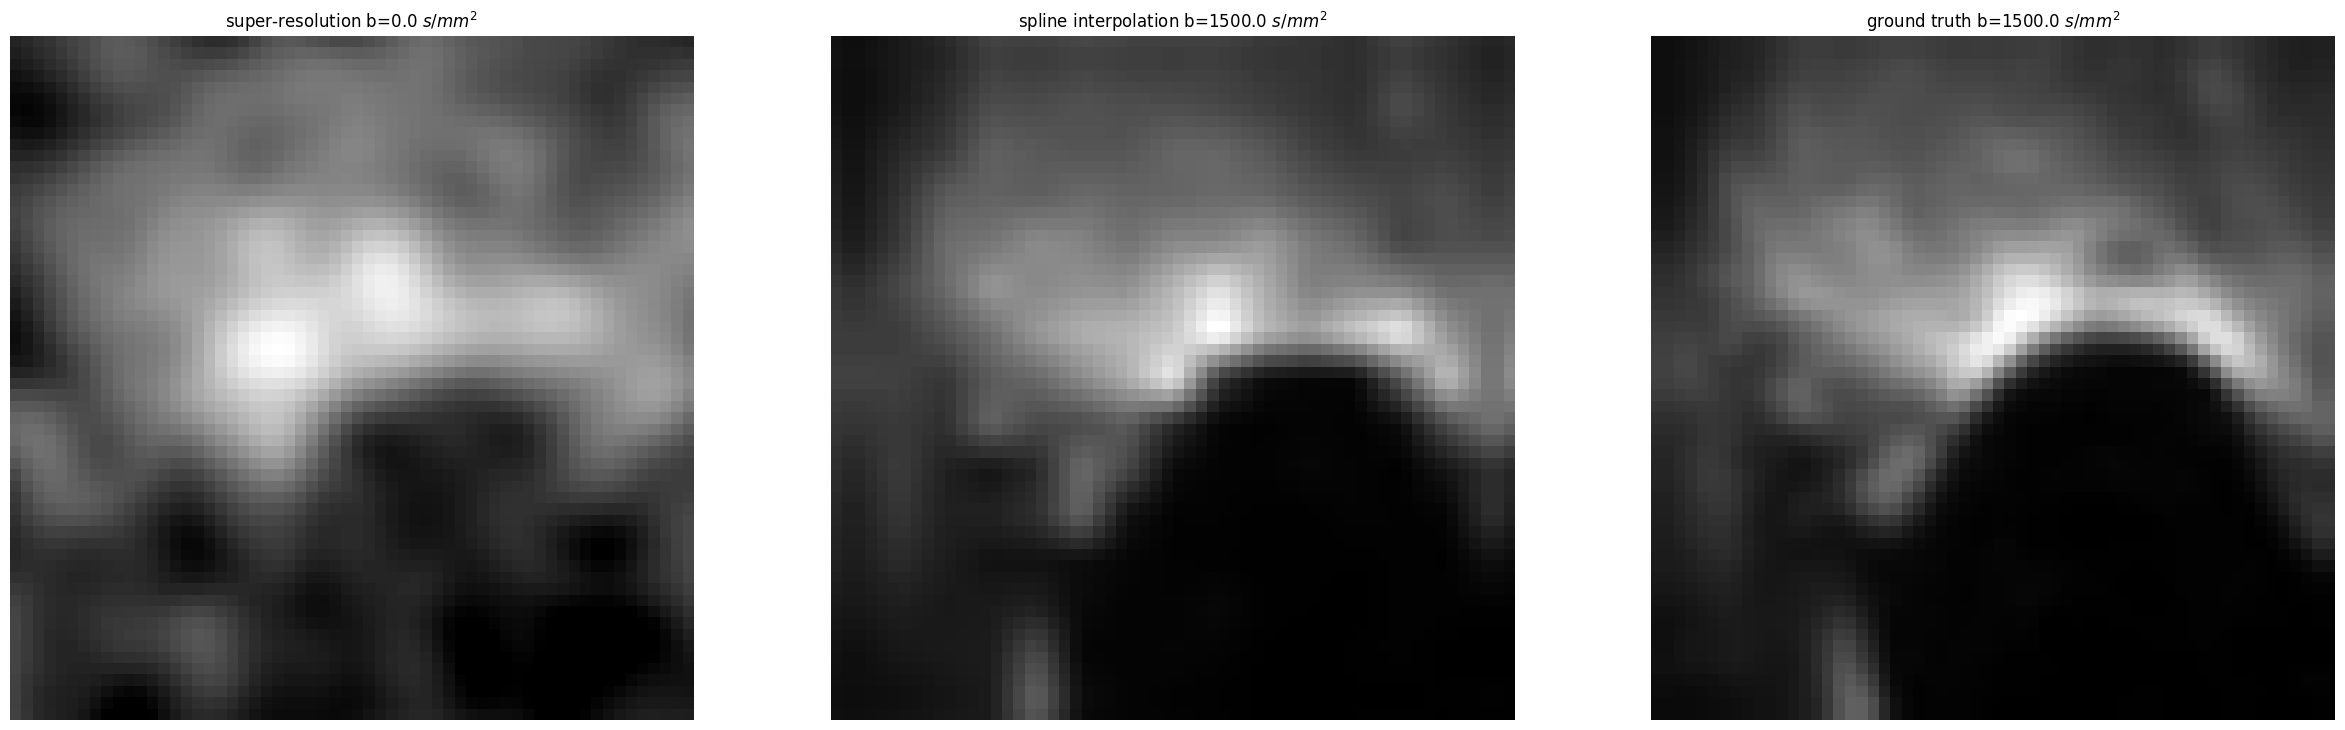

  6%|▌         | 149/2500 [00:05<00:53, 43.73it/s]

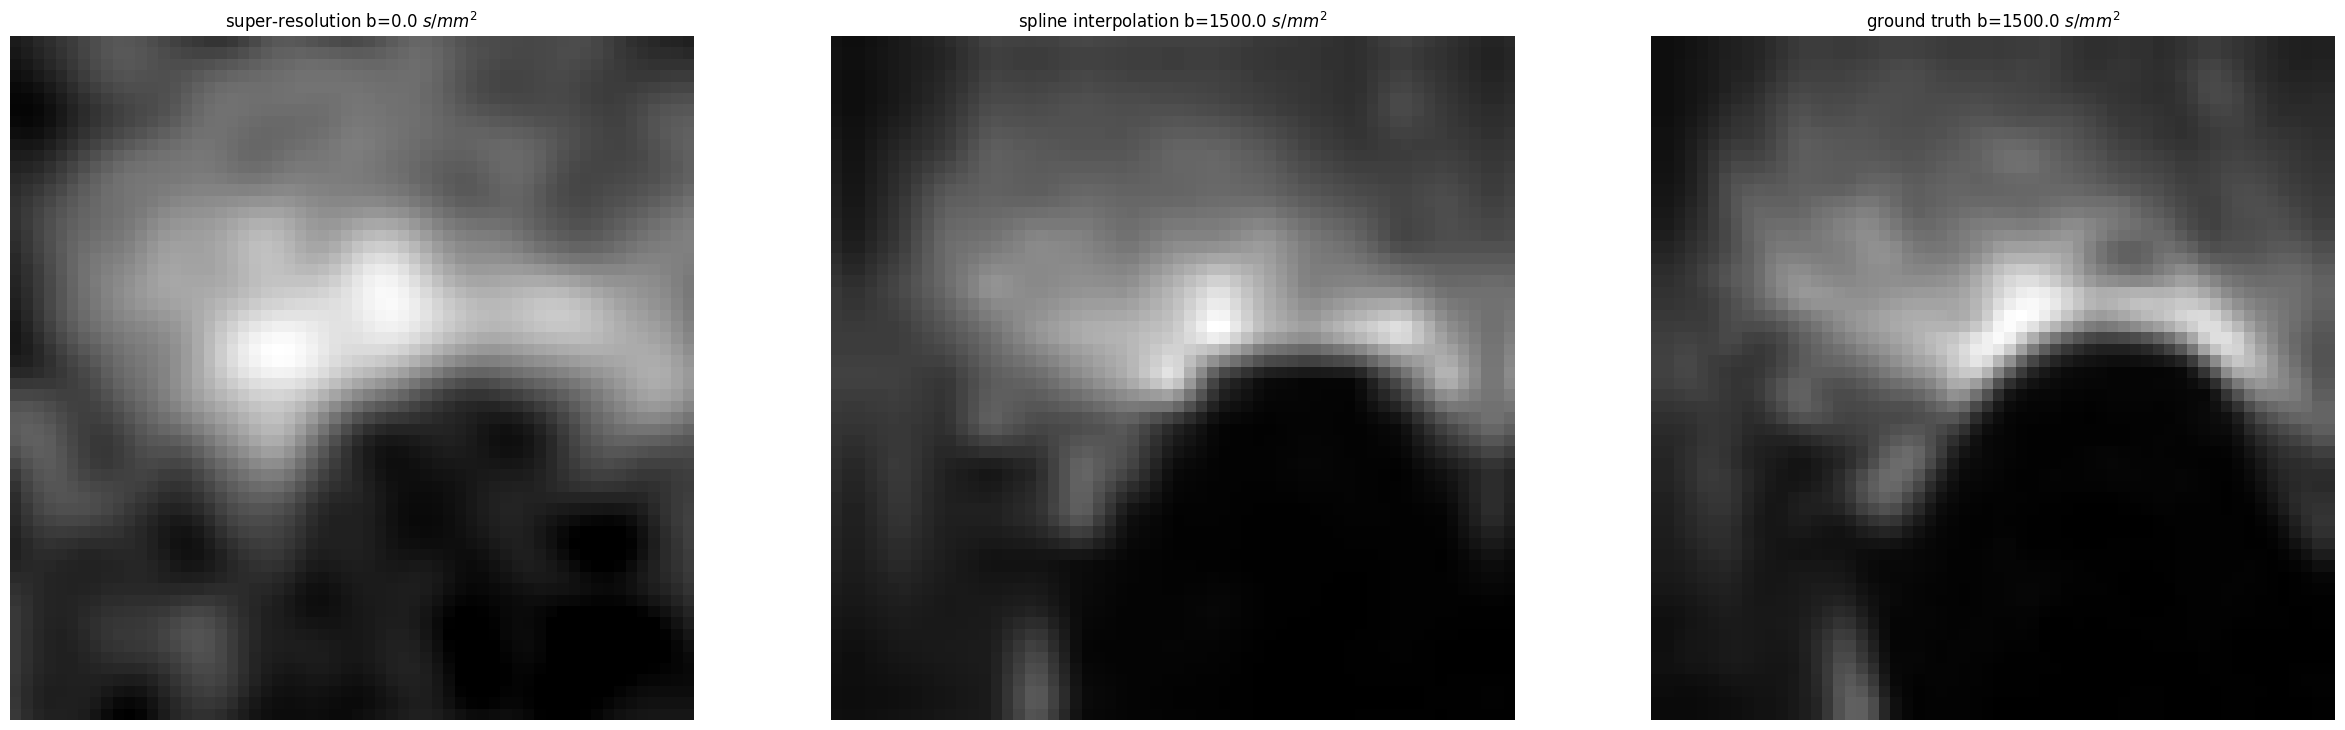

  8%|▊         | 199/2500 [00:07<00:52, 43.64it/s]

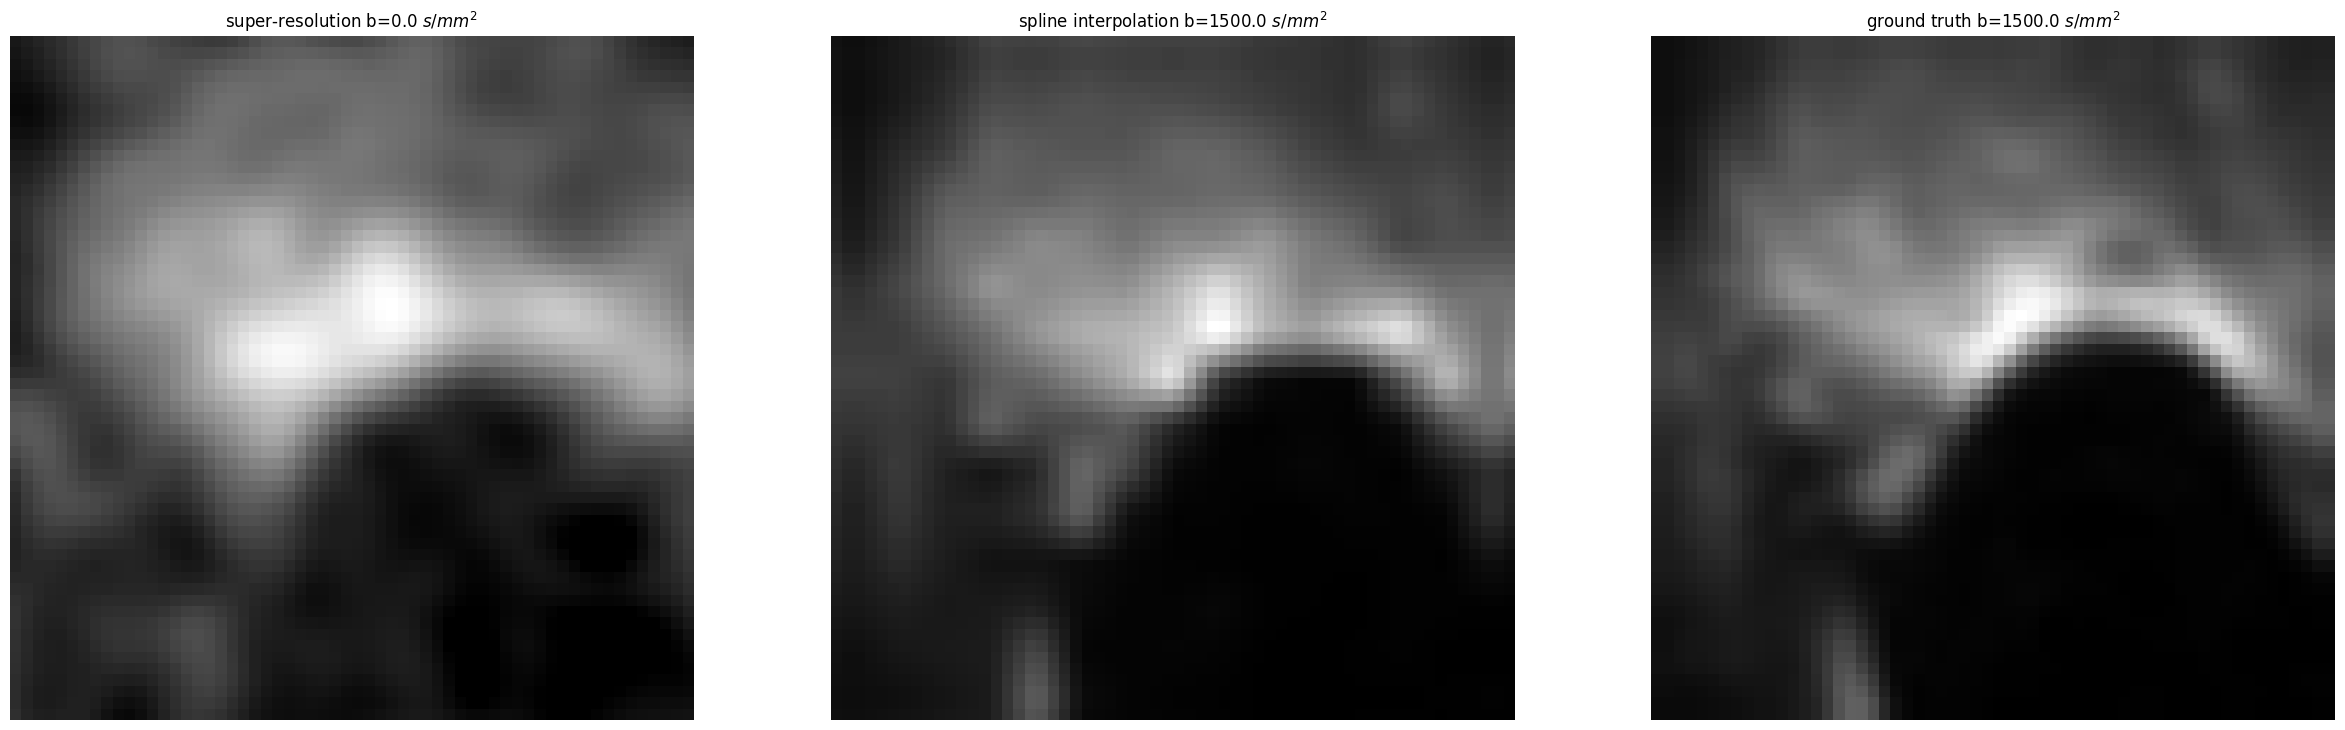

 10%|▉         | 249/2500 [00:08<00:51, 43.60it/s]

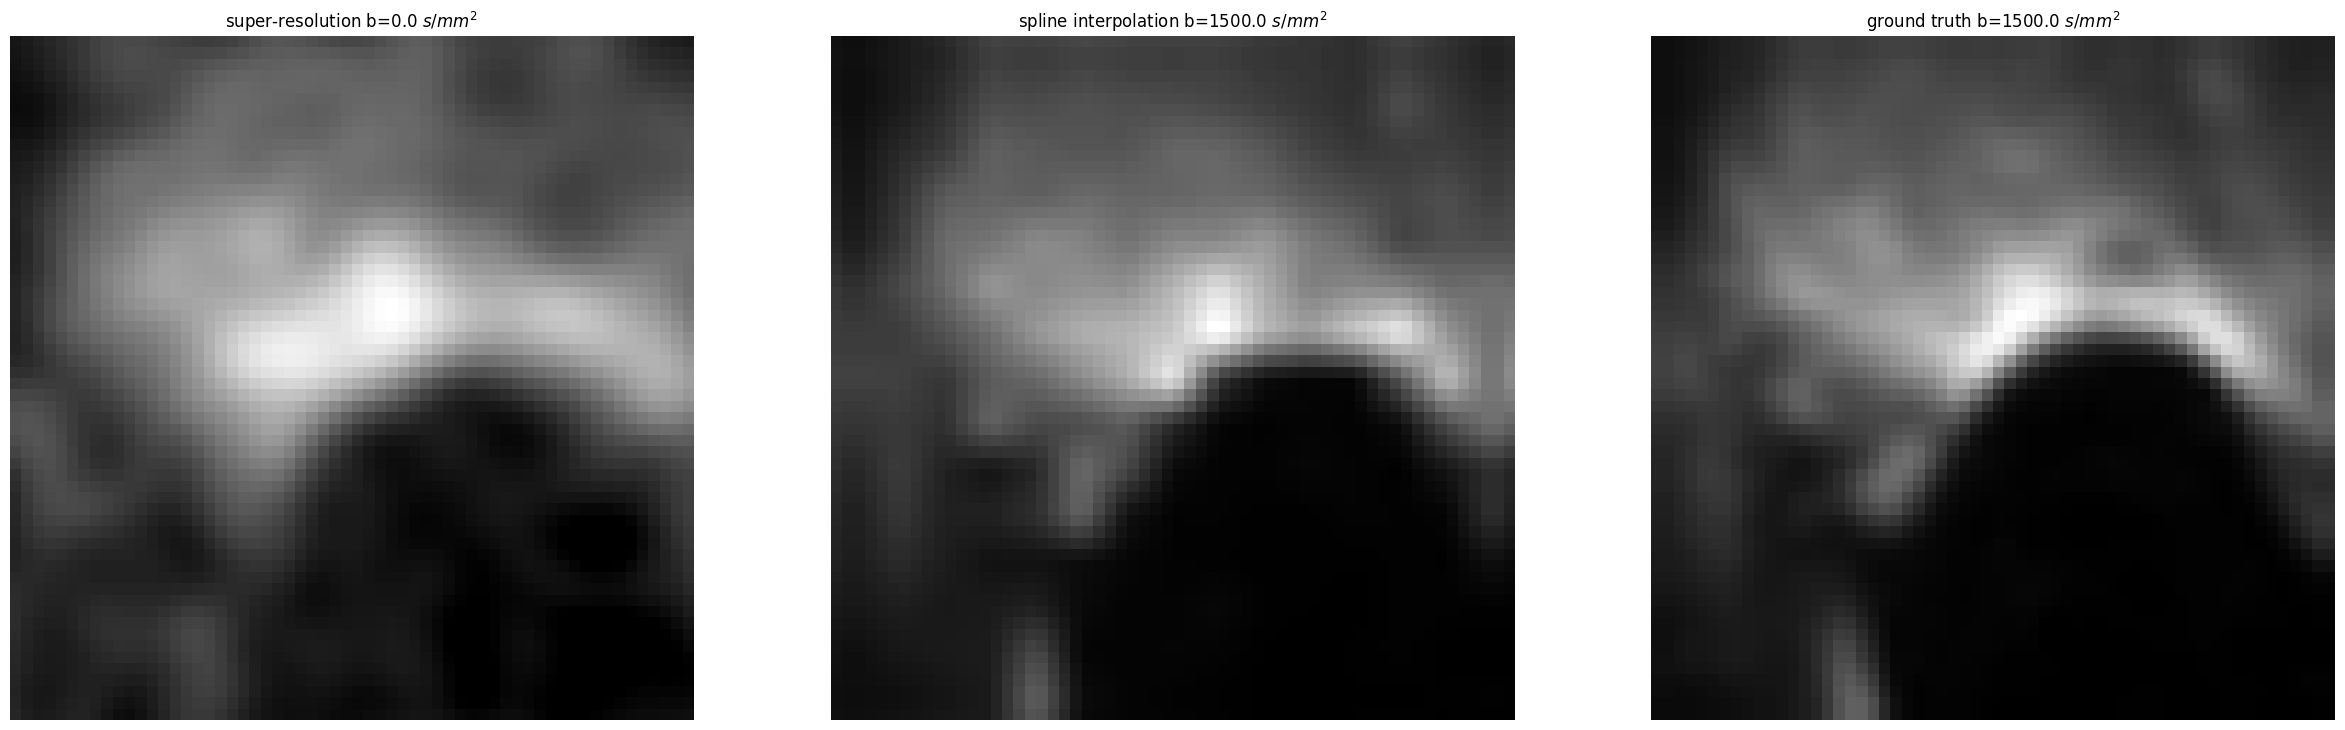

 12%|█▏        | 299/2500 [00:10<00:50, 43.61it/s]

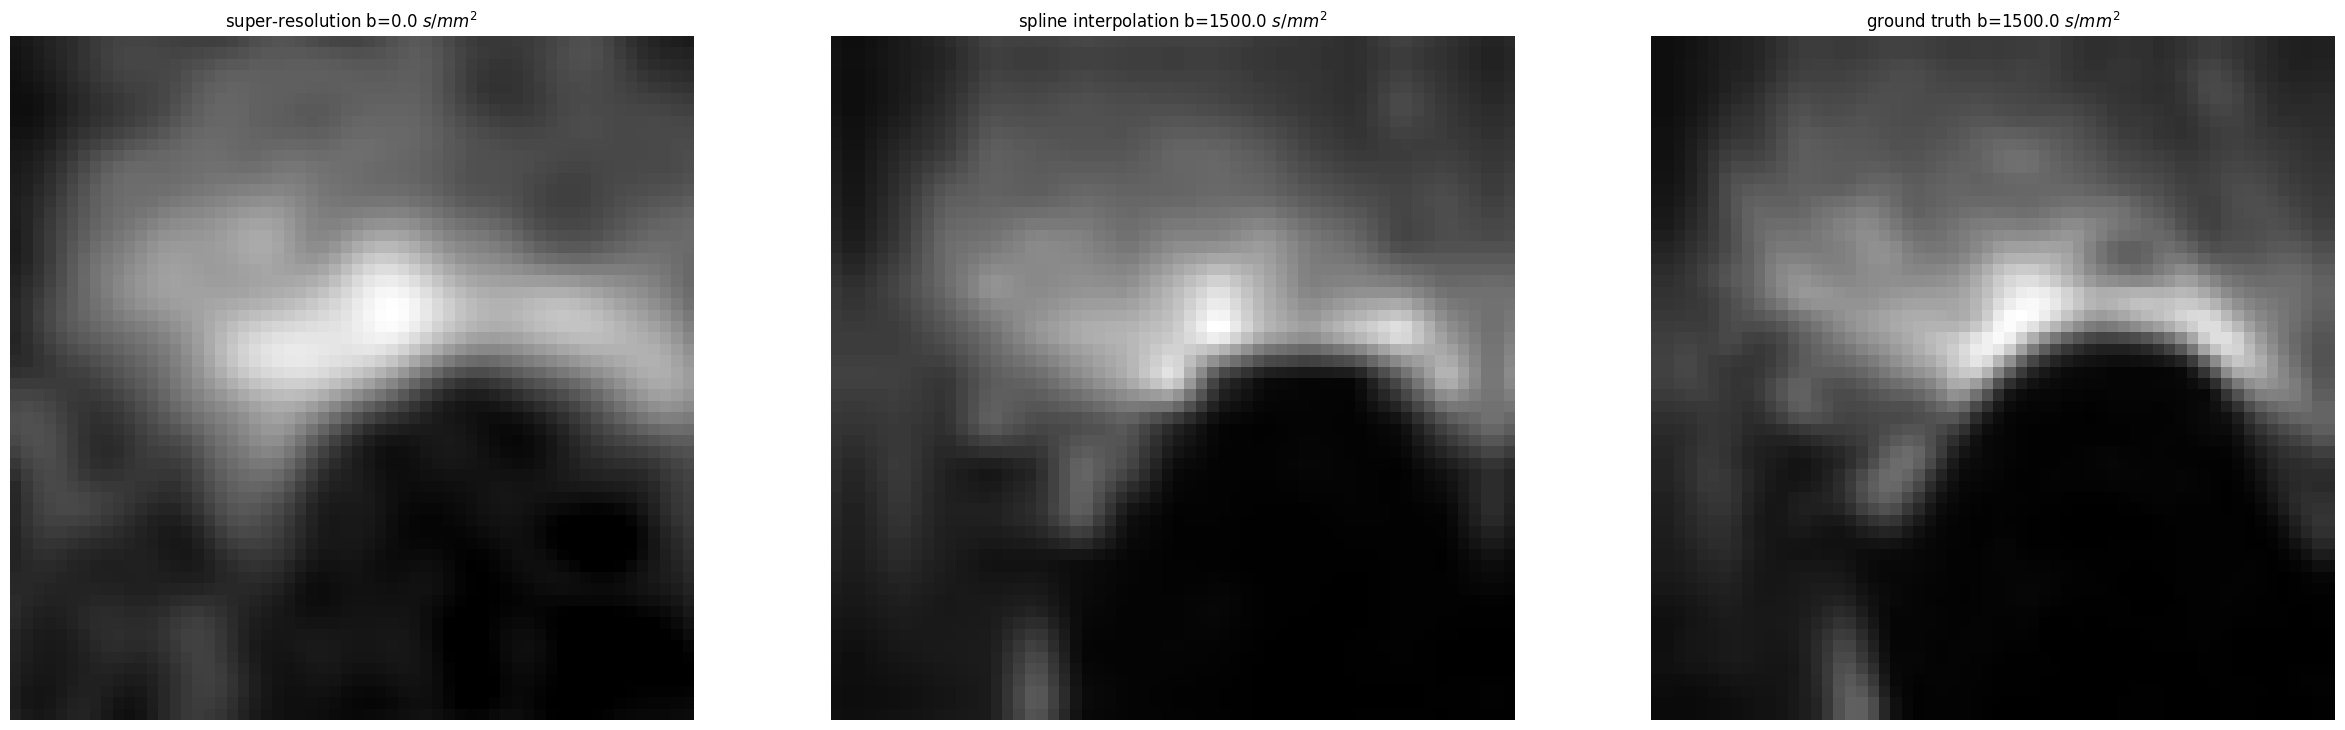

 14%|█▍        | 349/2500 [00:12<00:49, 43.68it/s]

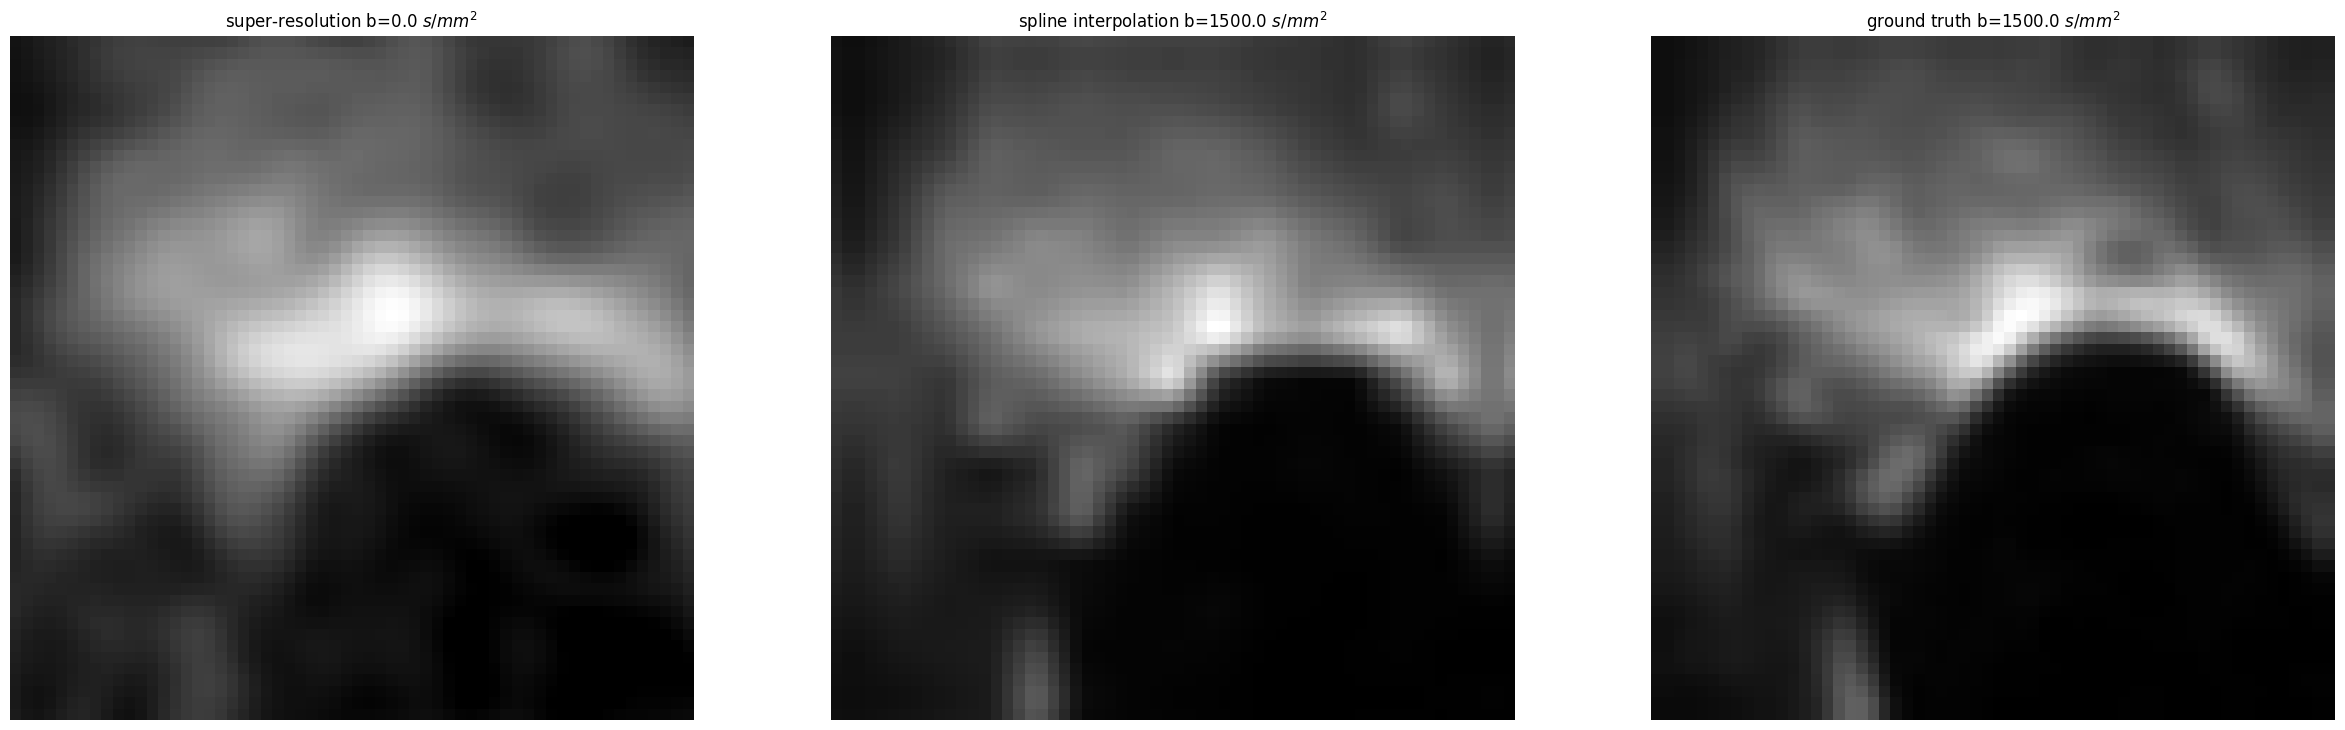

 16%|█▌        | 399/2500 [00:14<00:48, 43.65it/s]

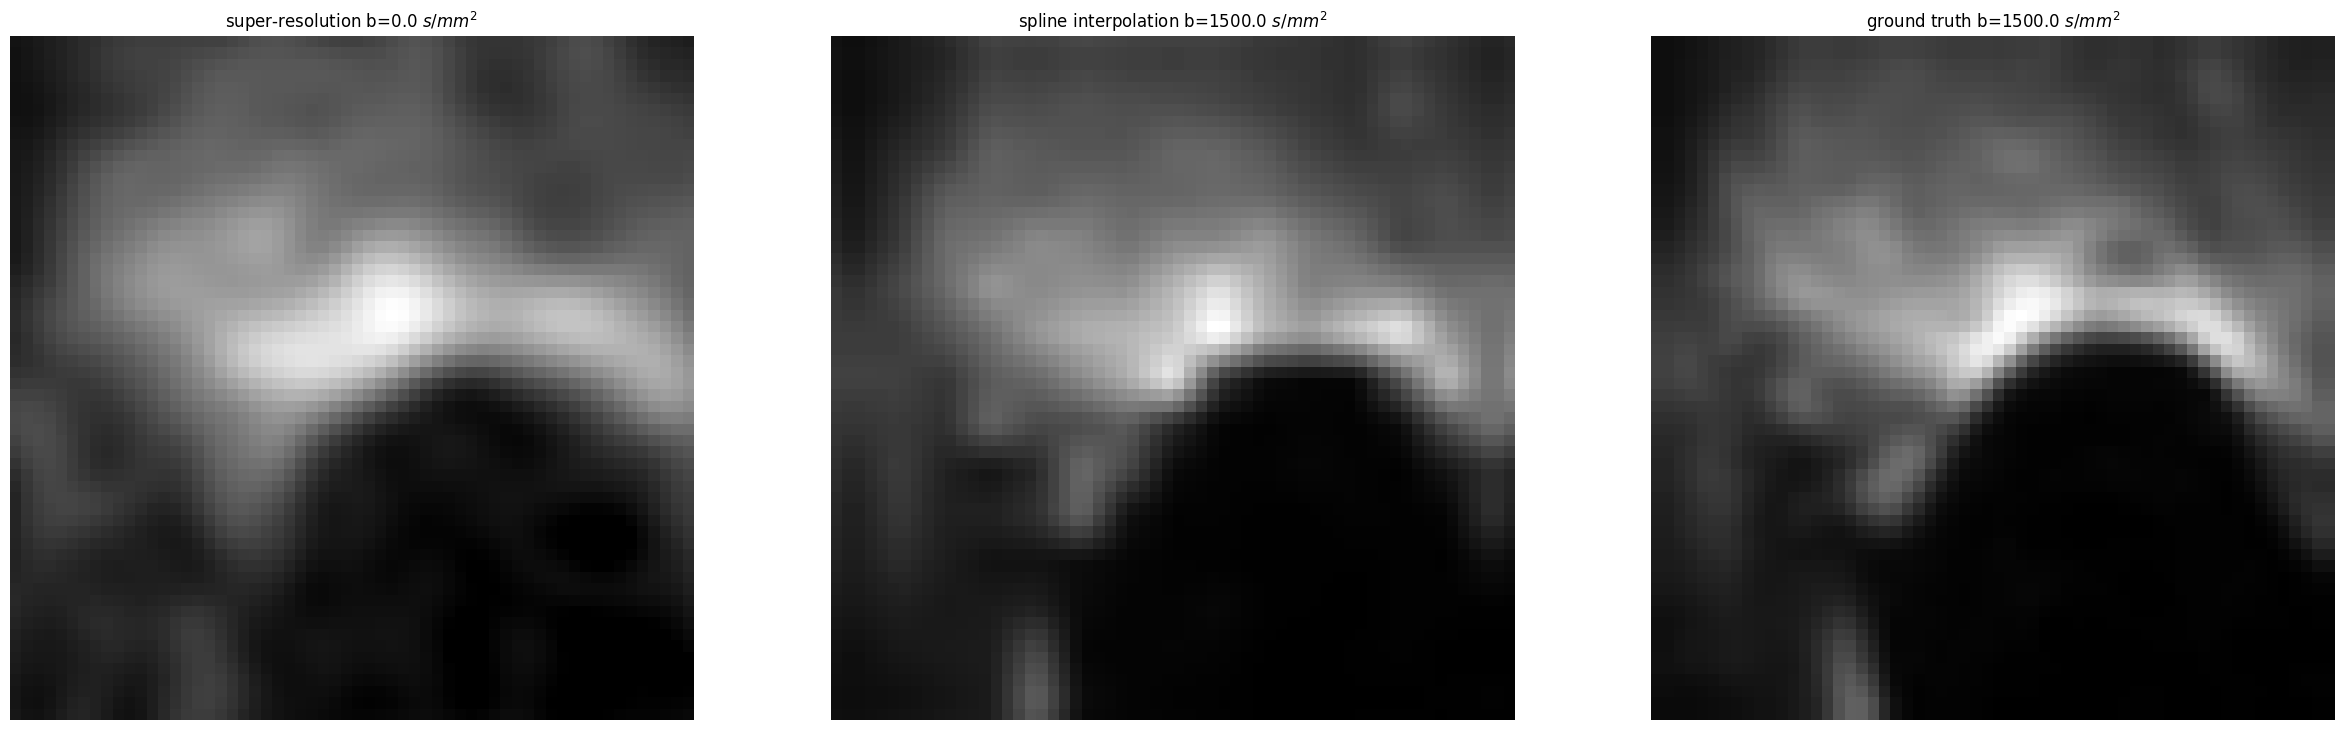

 18%|█▊        | 449/2500 [00:16<00:46, 43.64it/s]

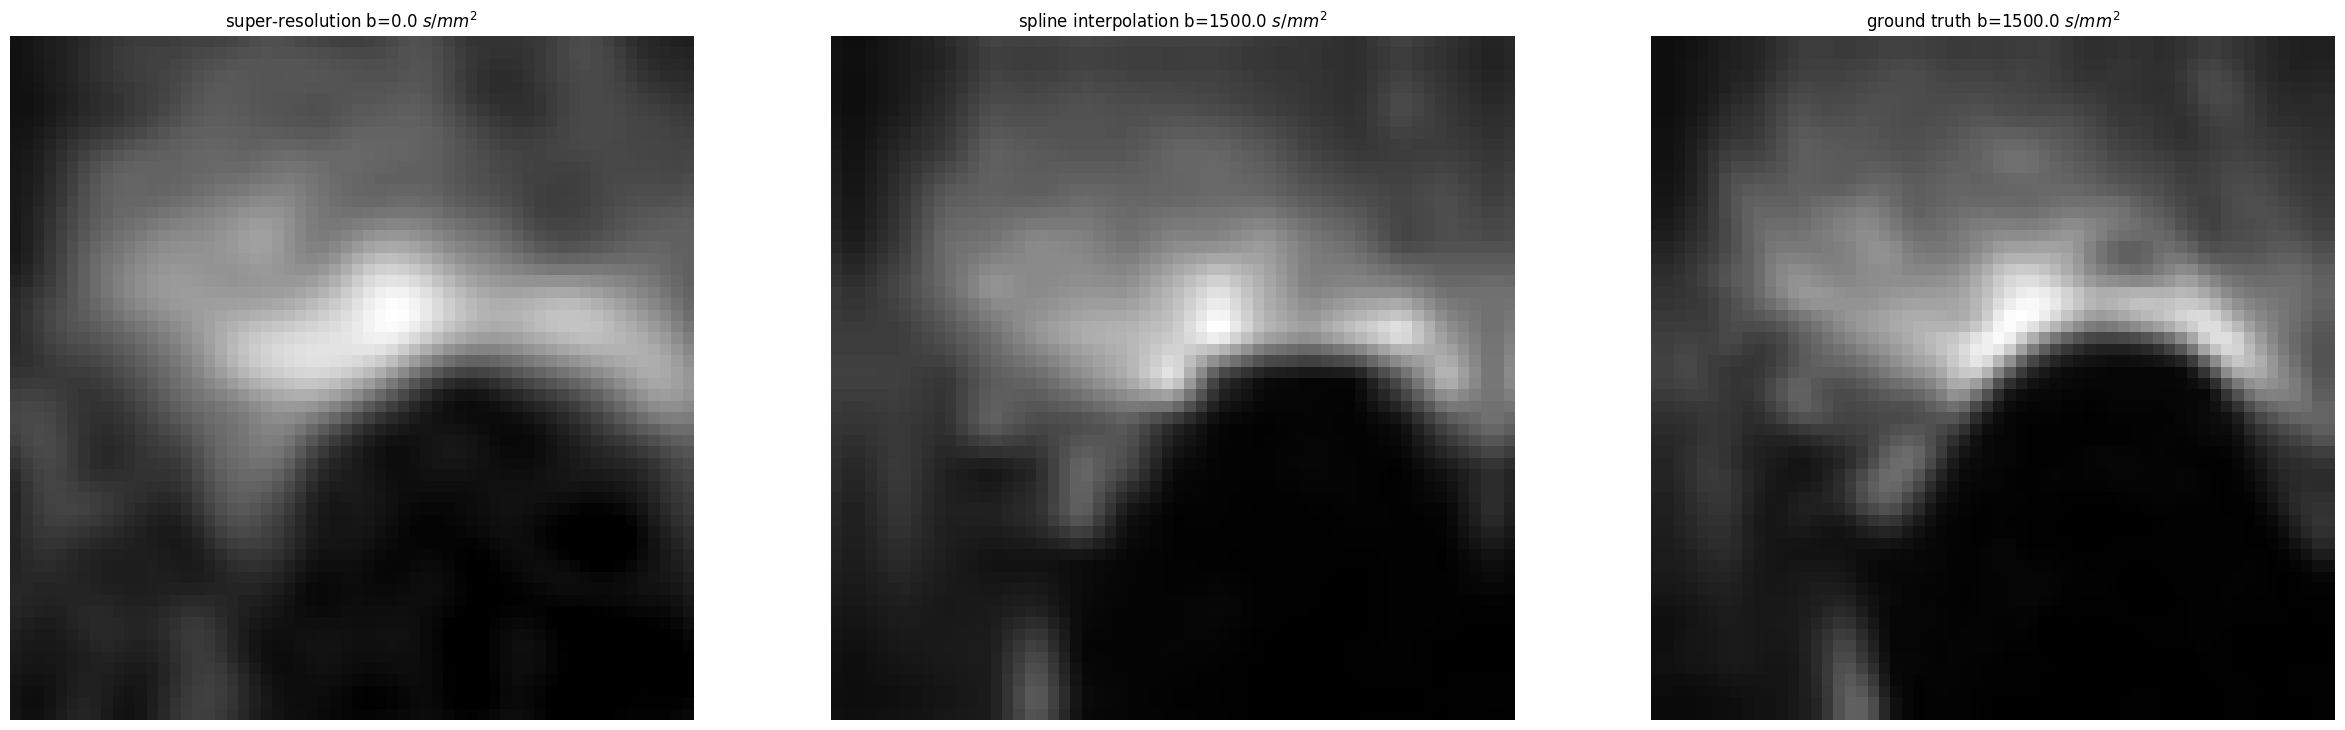

 20%|█▉        | 499/2500 [00:17<00:45, 43.59it/s]

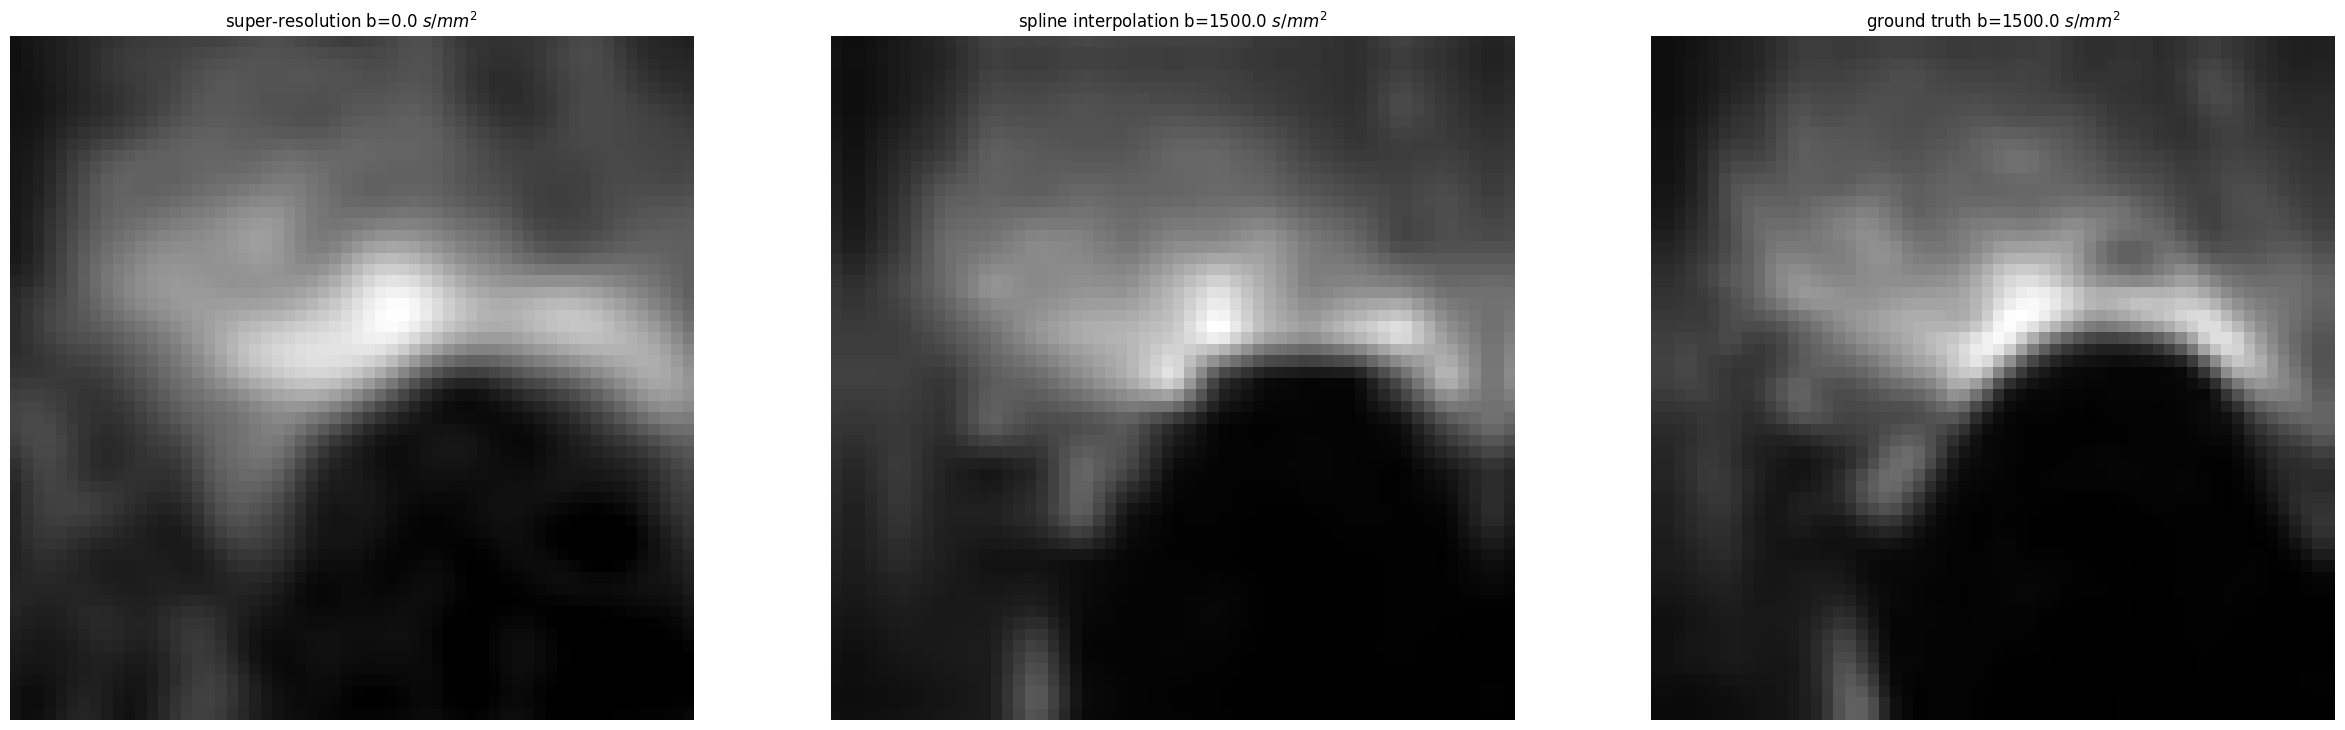

 22%|██▏       | 549/2500 [00:19<00:44, 43.65it/s]

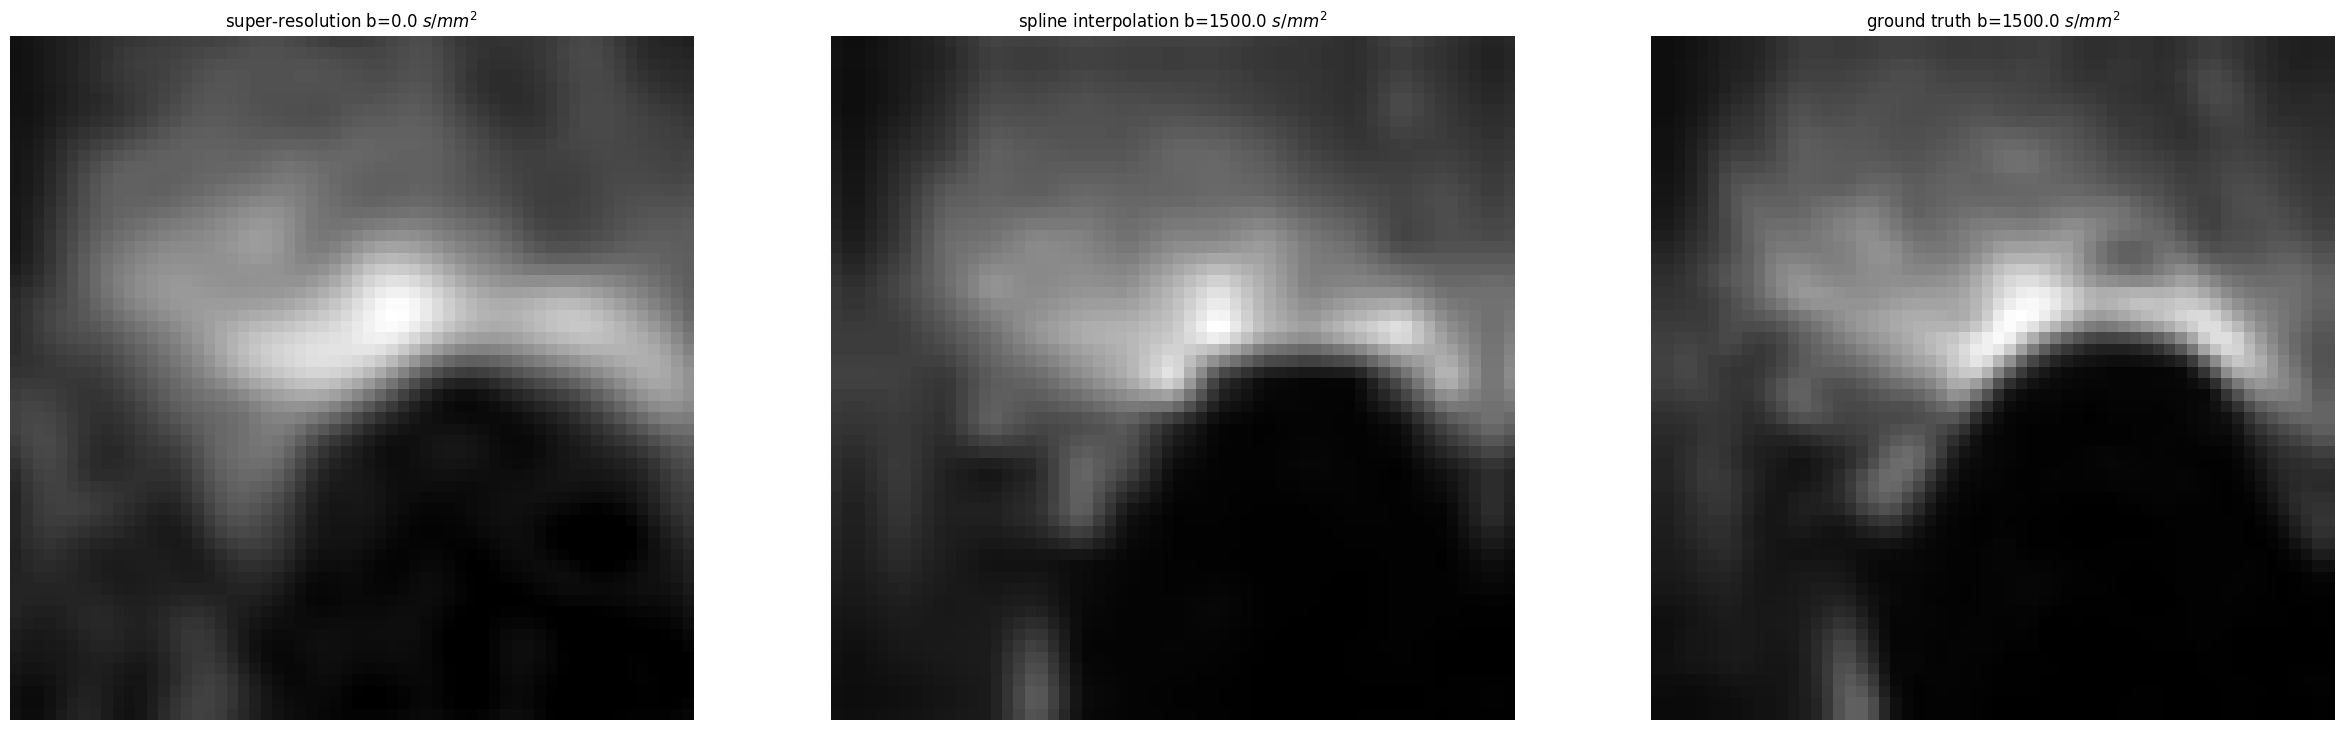

 24%|██▍       | 599/2500 [00:21<00:43, 43.28it/s]

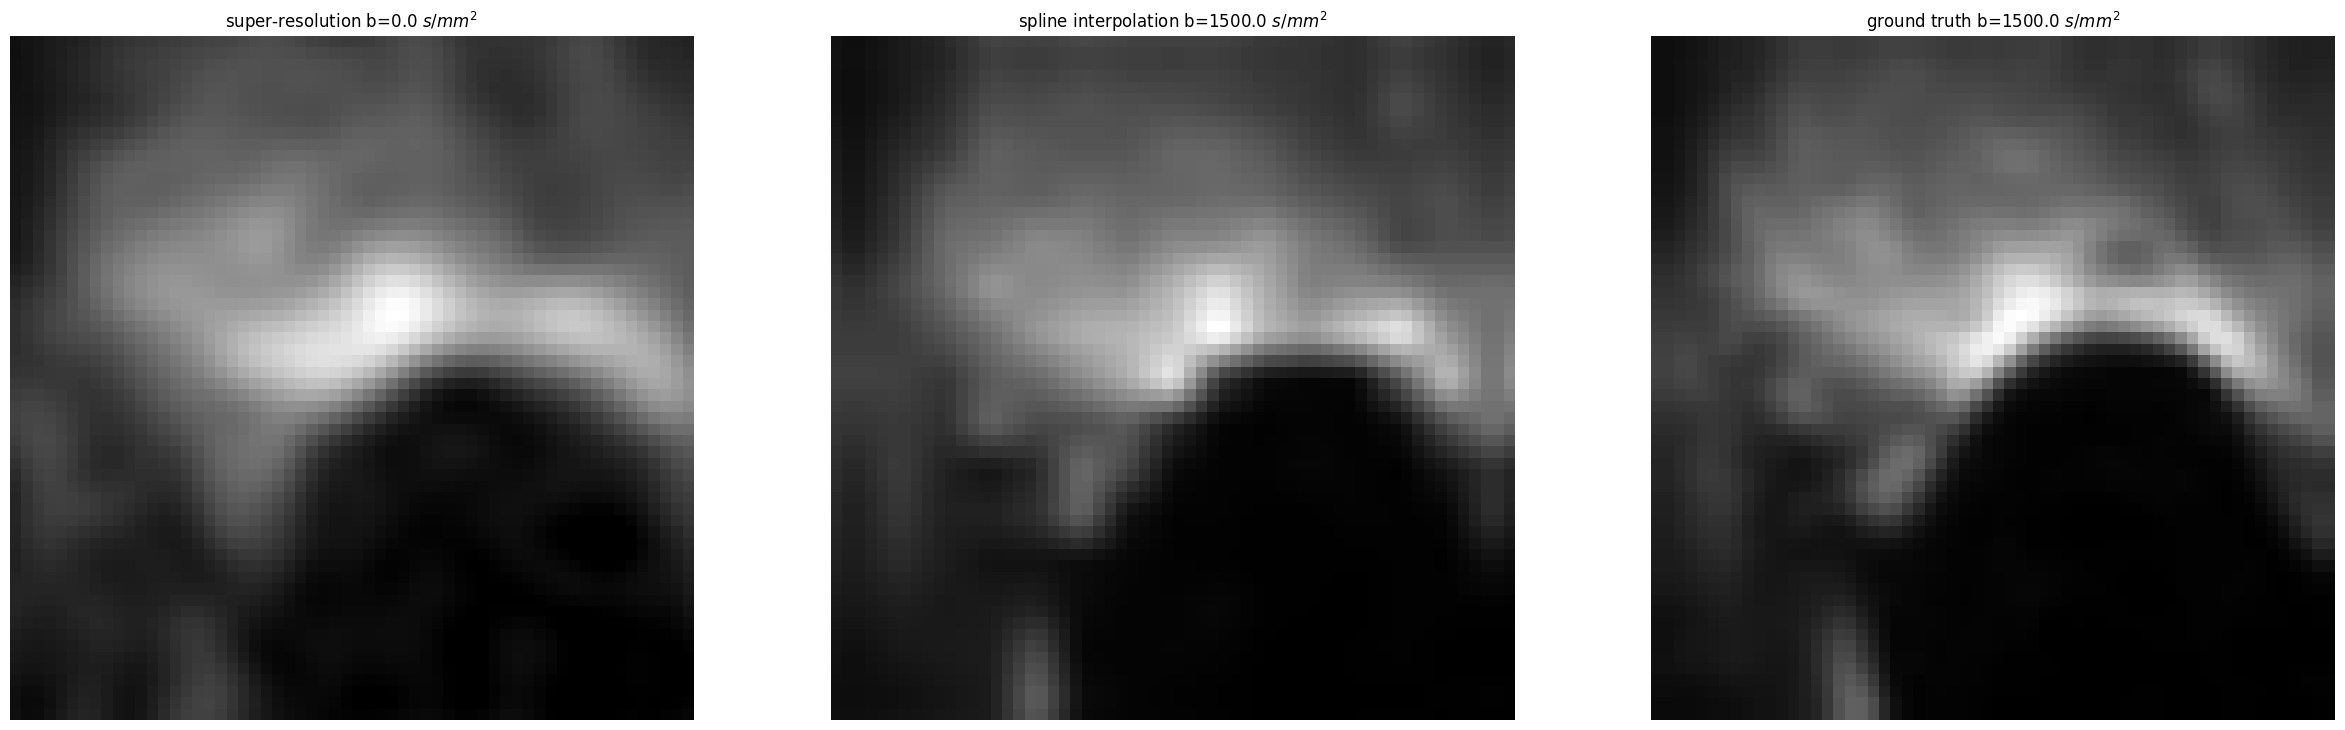

 26%|██▌       | 649/2500 [00:23<00:42, 43.51it/s]

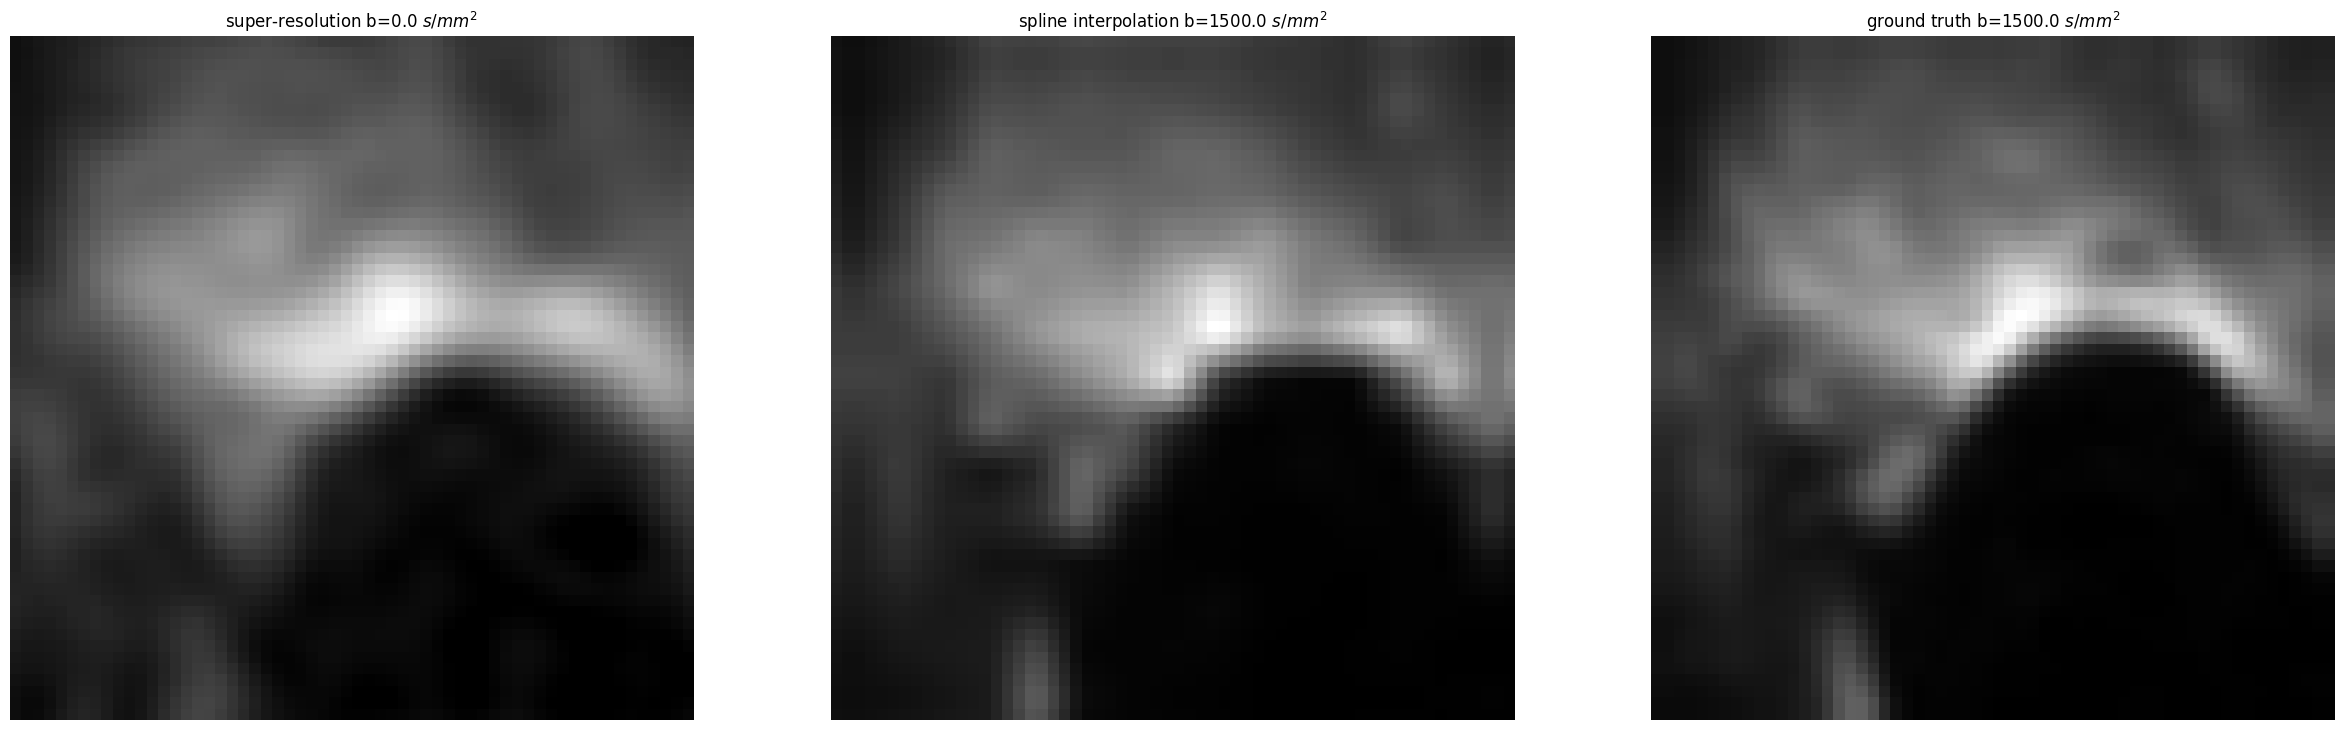

 28%|██▊       | 699/2500 [00:25<00:45, 39.32it/s]

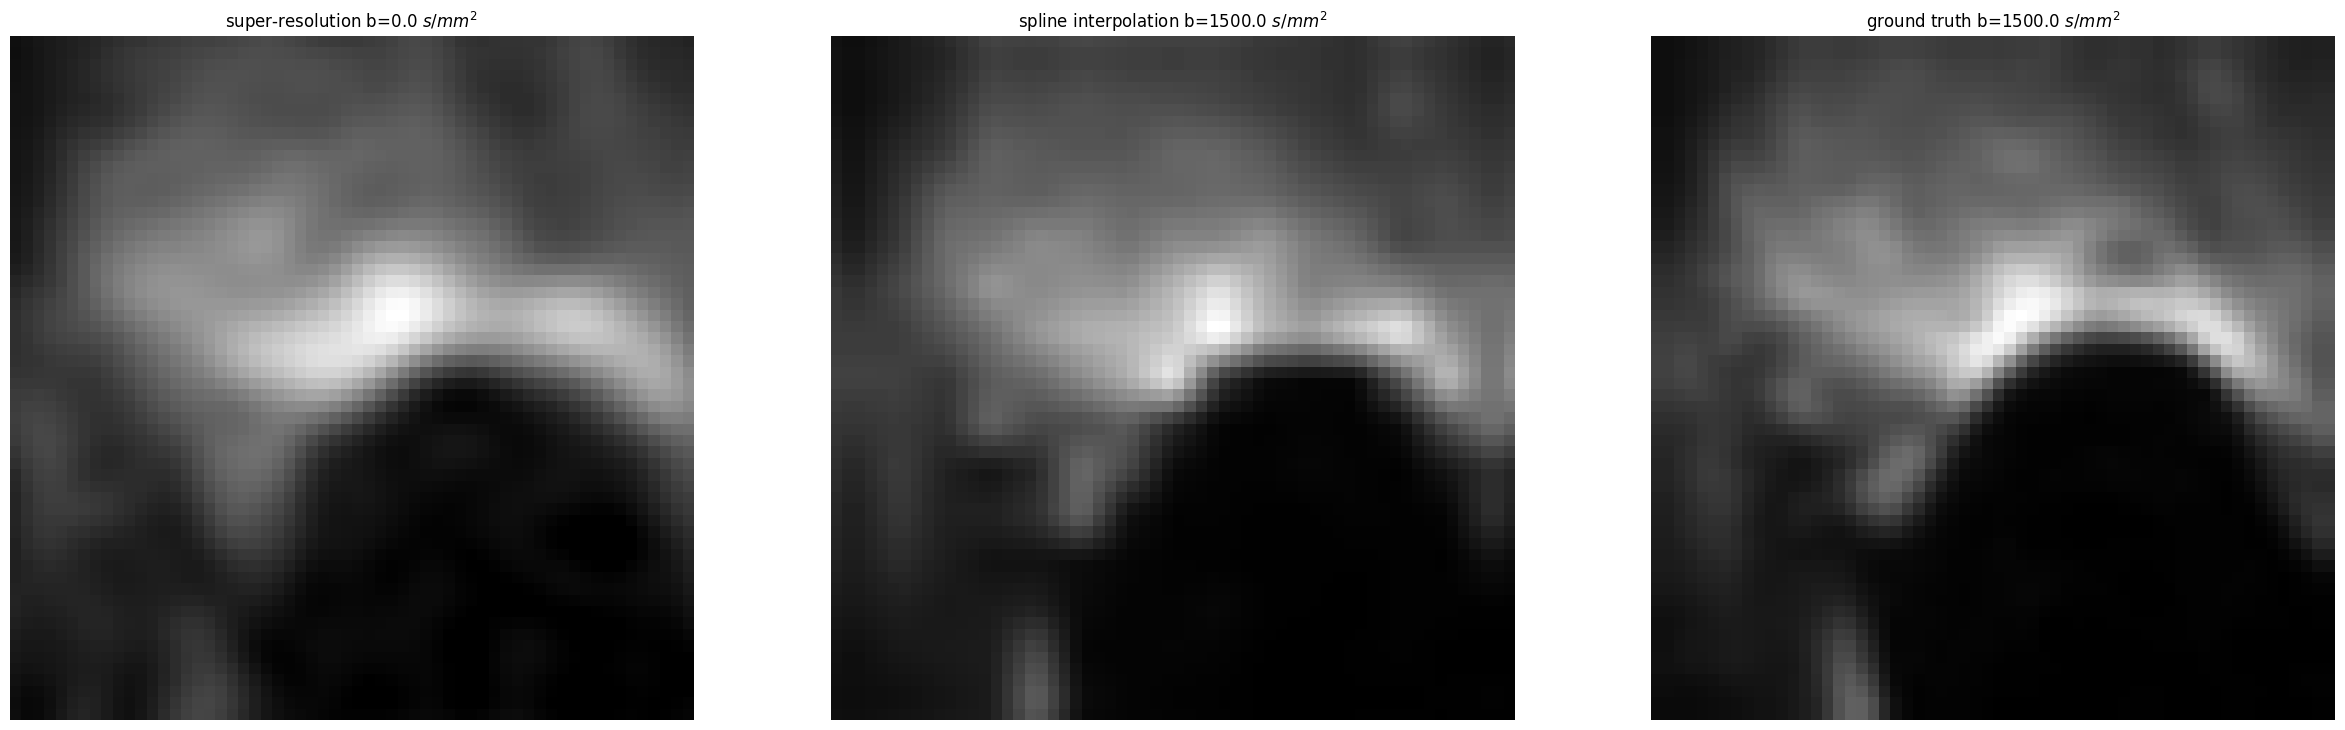

 30%|██▉       | 749/2500 [00:27<00:40, 43.11it/s]

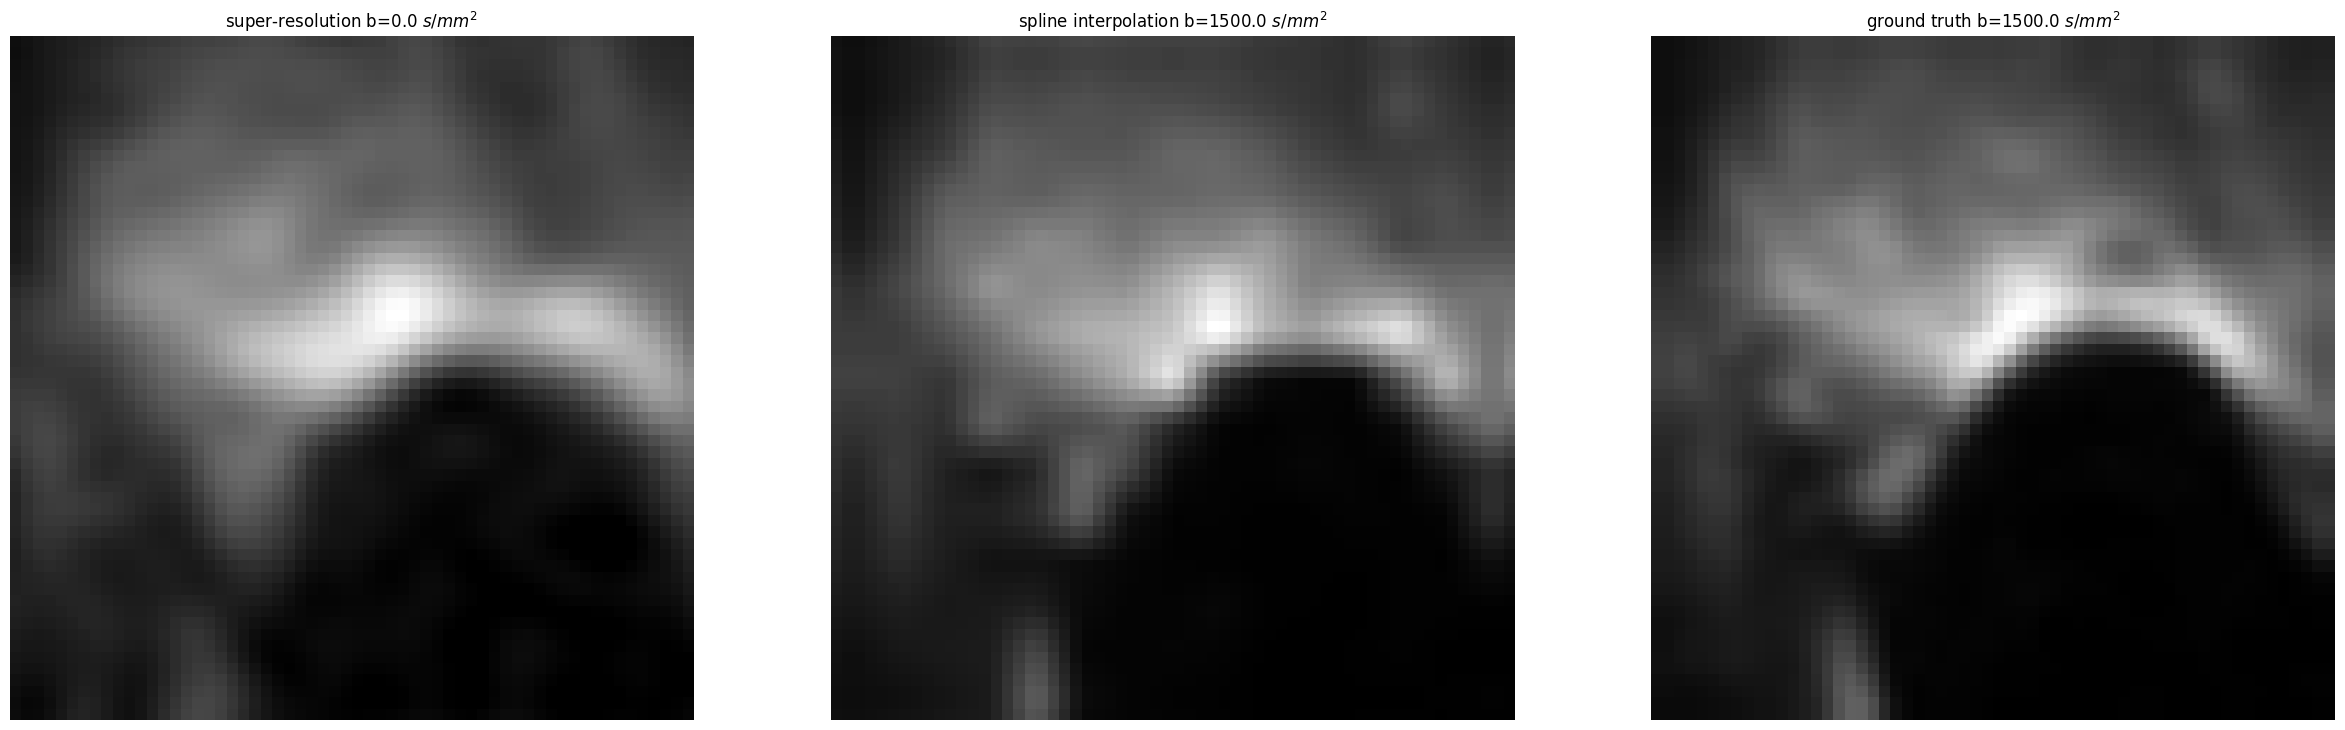

 32%|███▏      | 799/2500 [00:29<00:39, 43.29it/s]

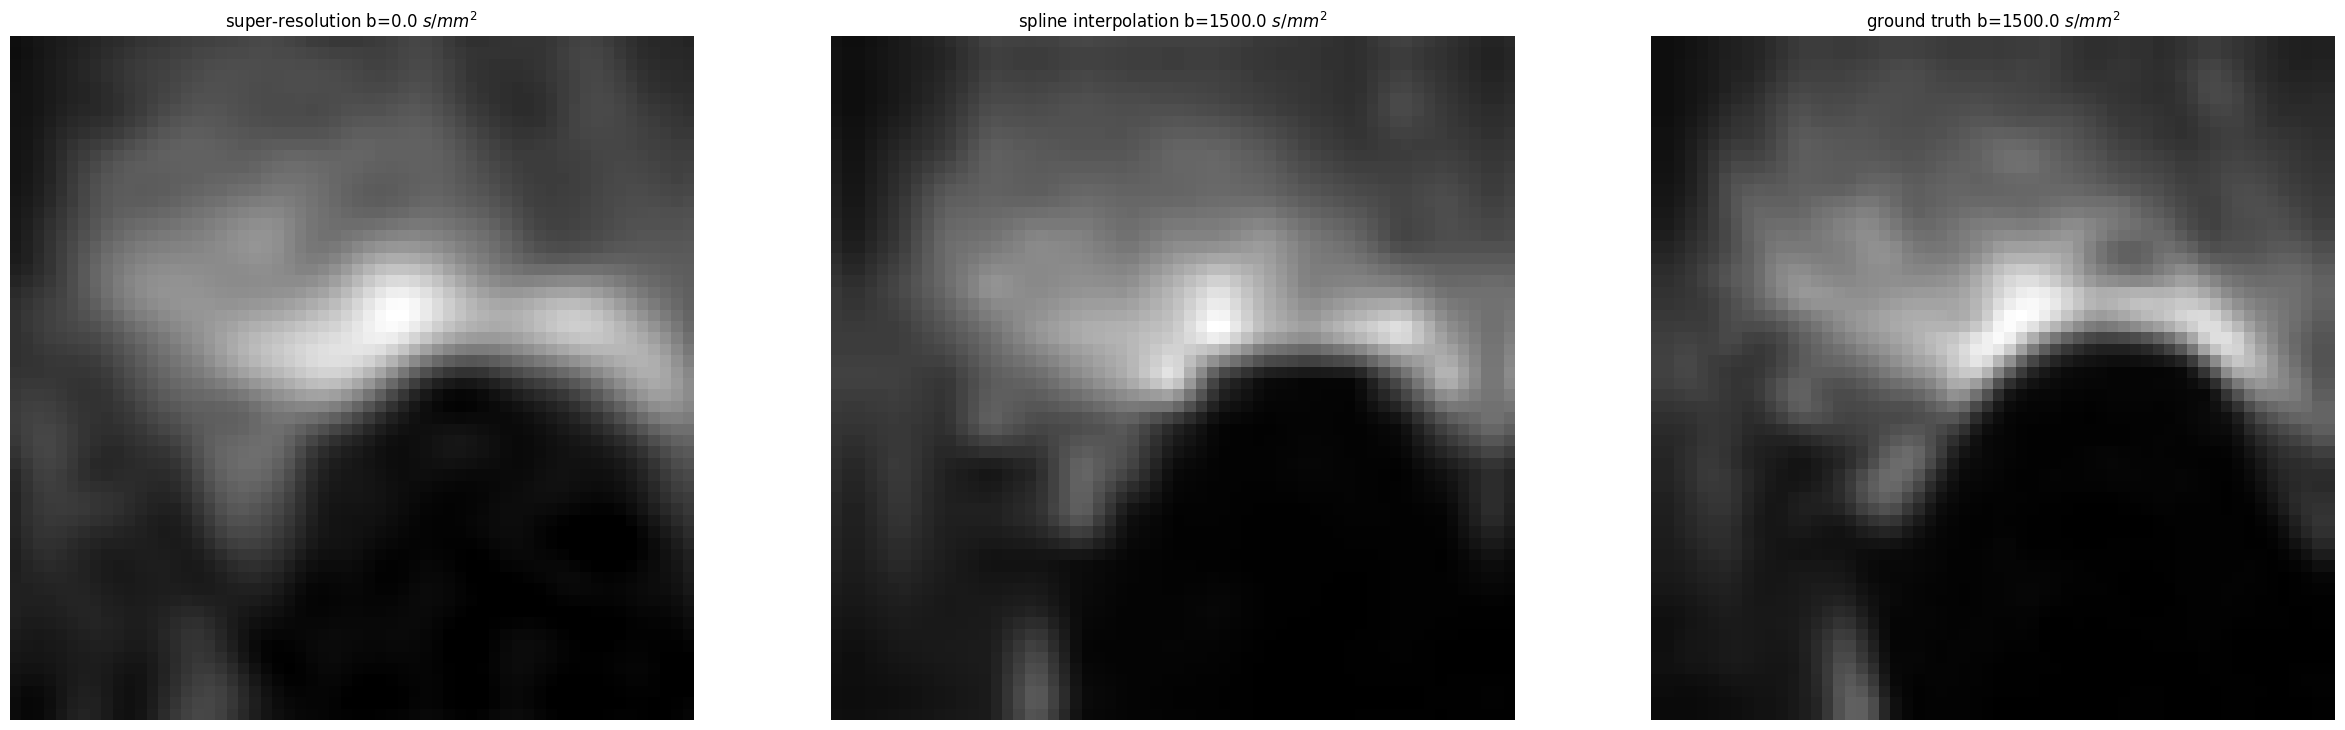

 34%|███▍      | 849/2500 [00:31<00:37, 43.67it/s]

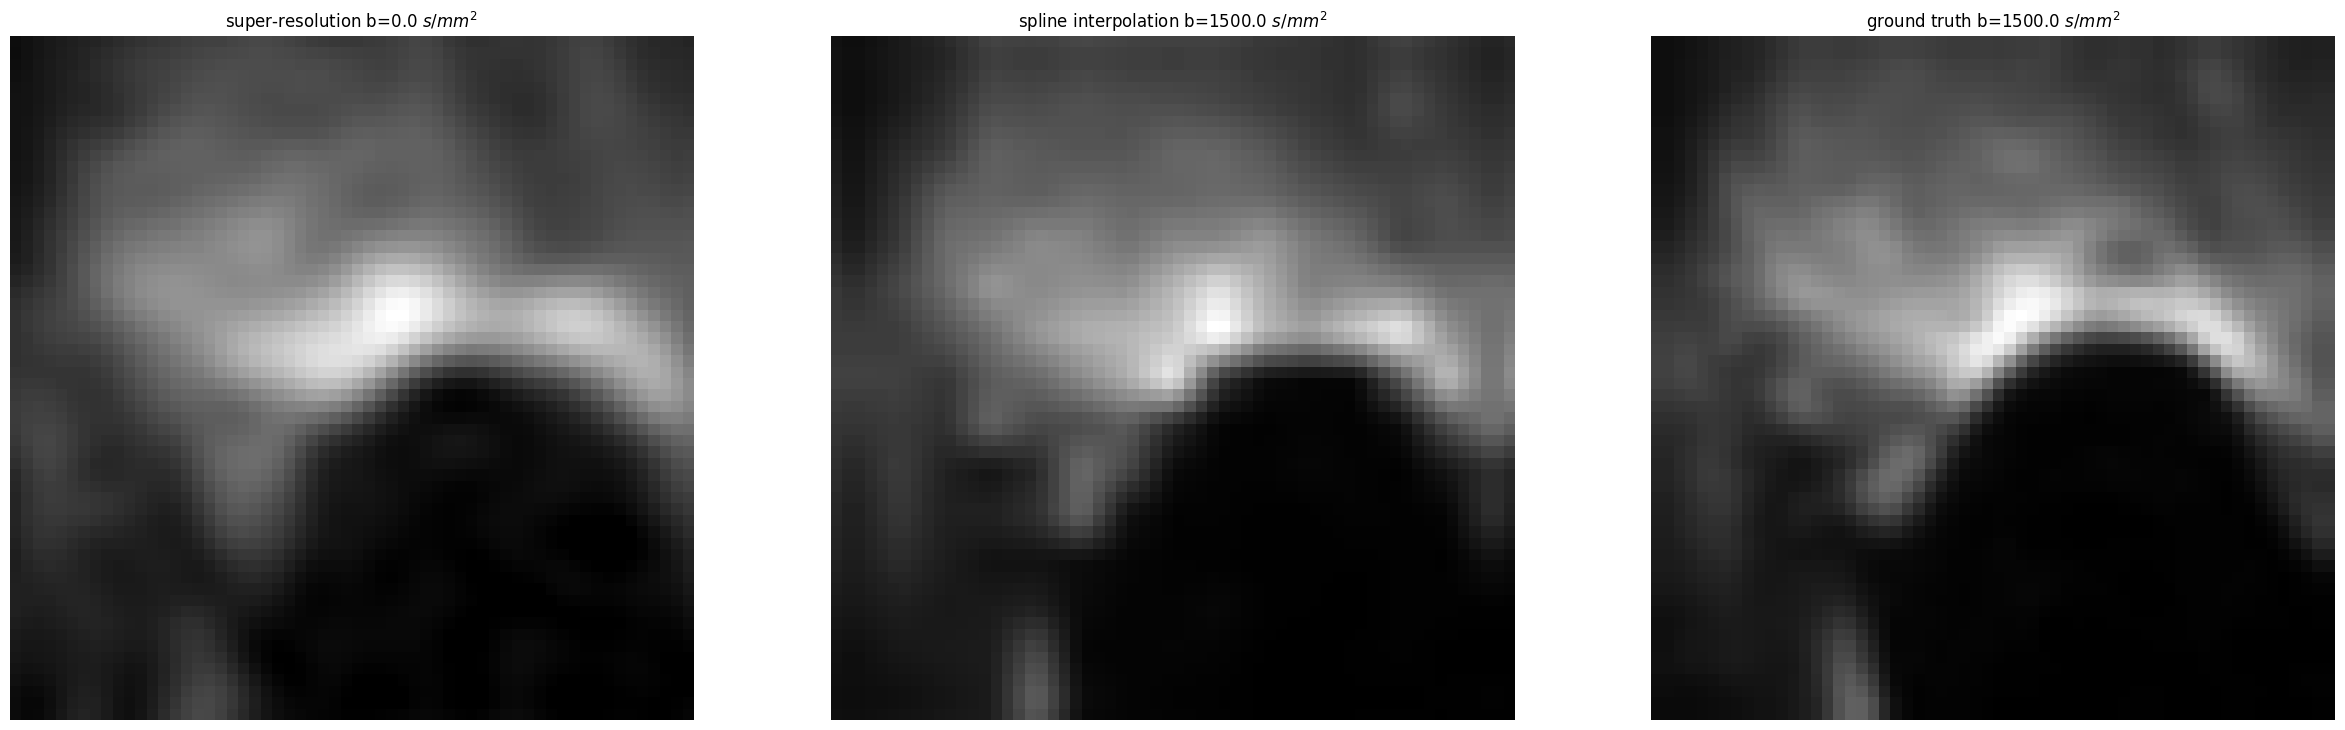

 36%|███▌      | 899/2500 [00:33<00:37, 43.19it/s]

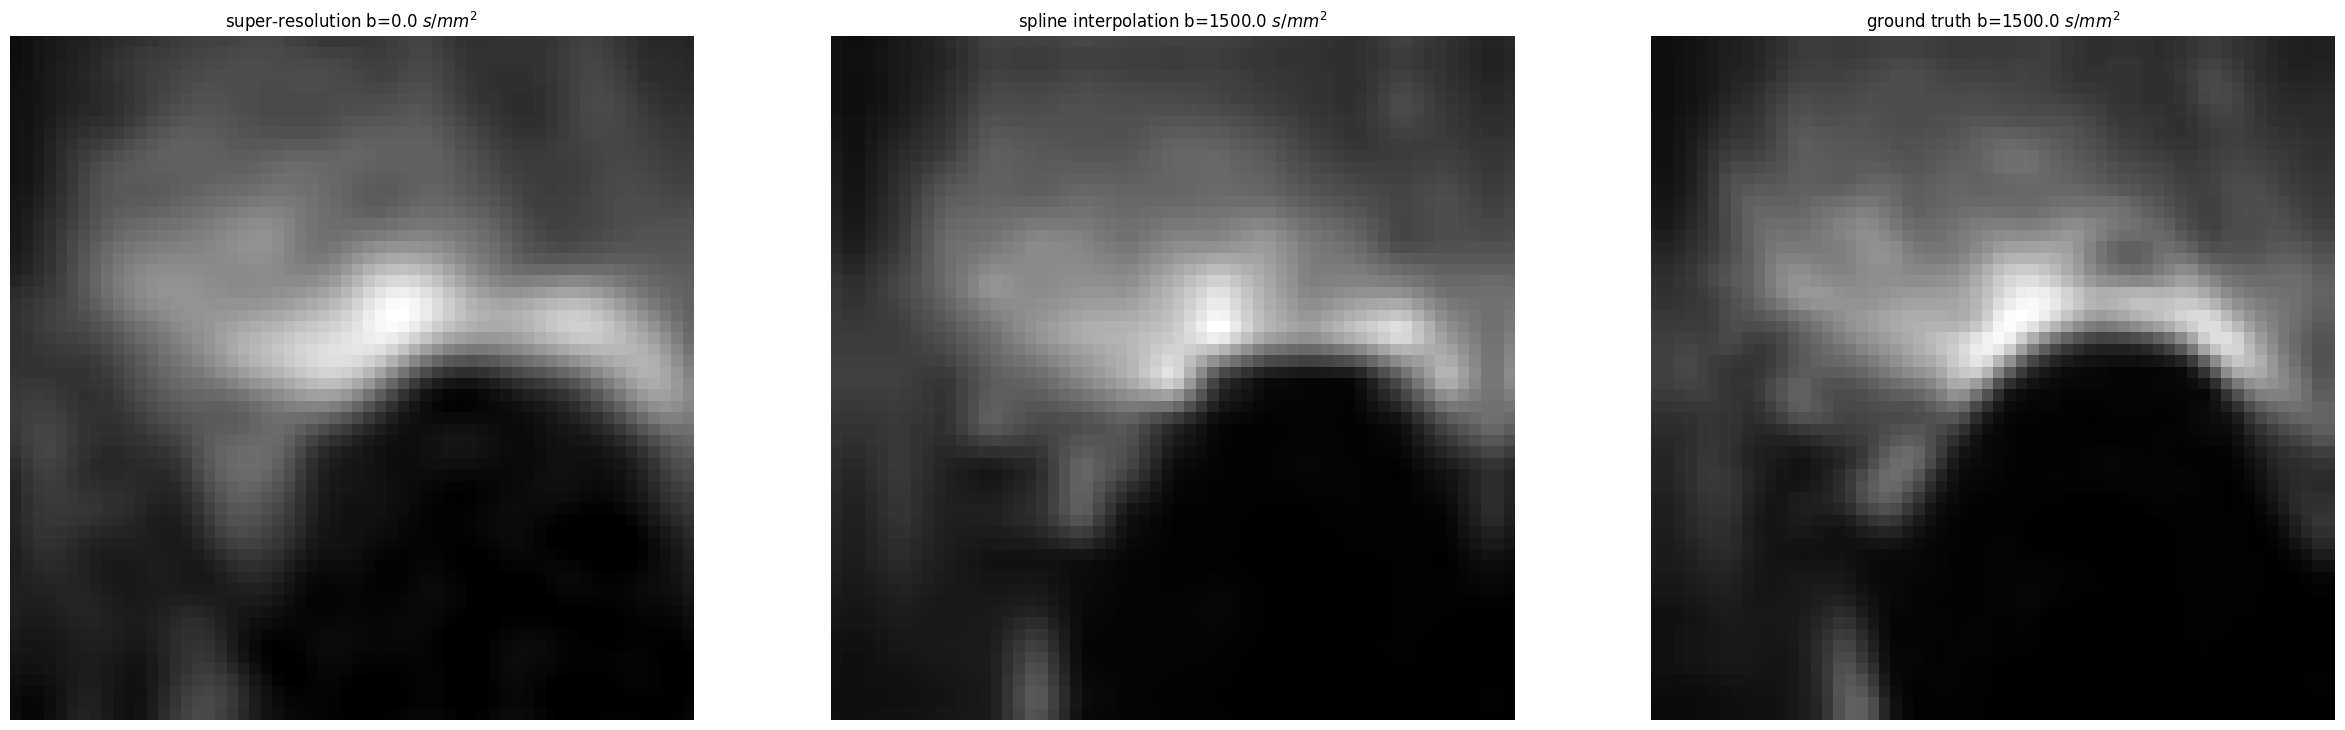

 38%|███▊      | 949/2500 [00:34<00:35, 43.53it/s]

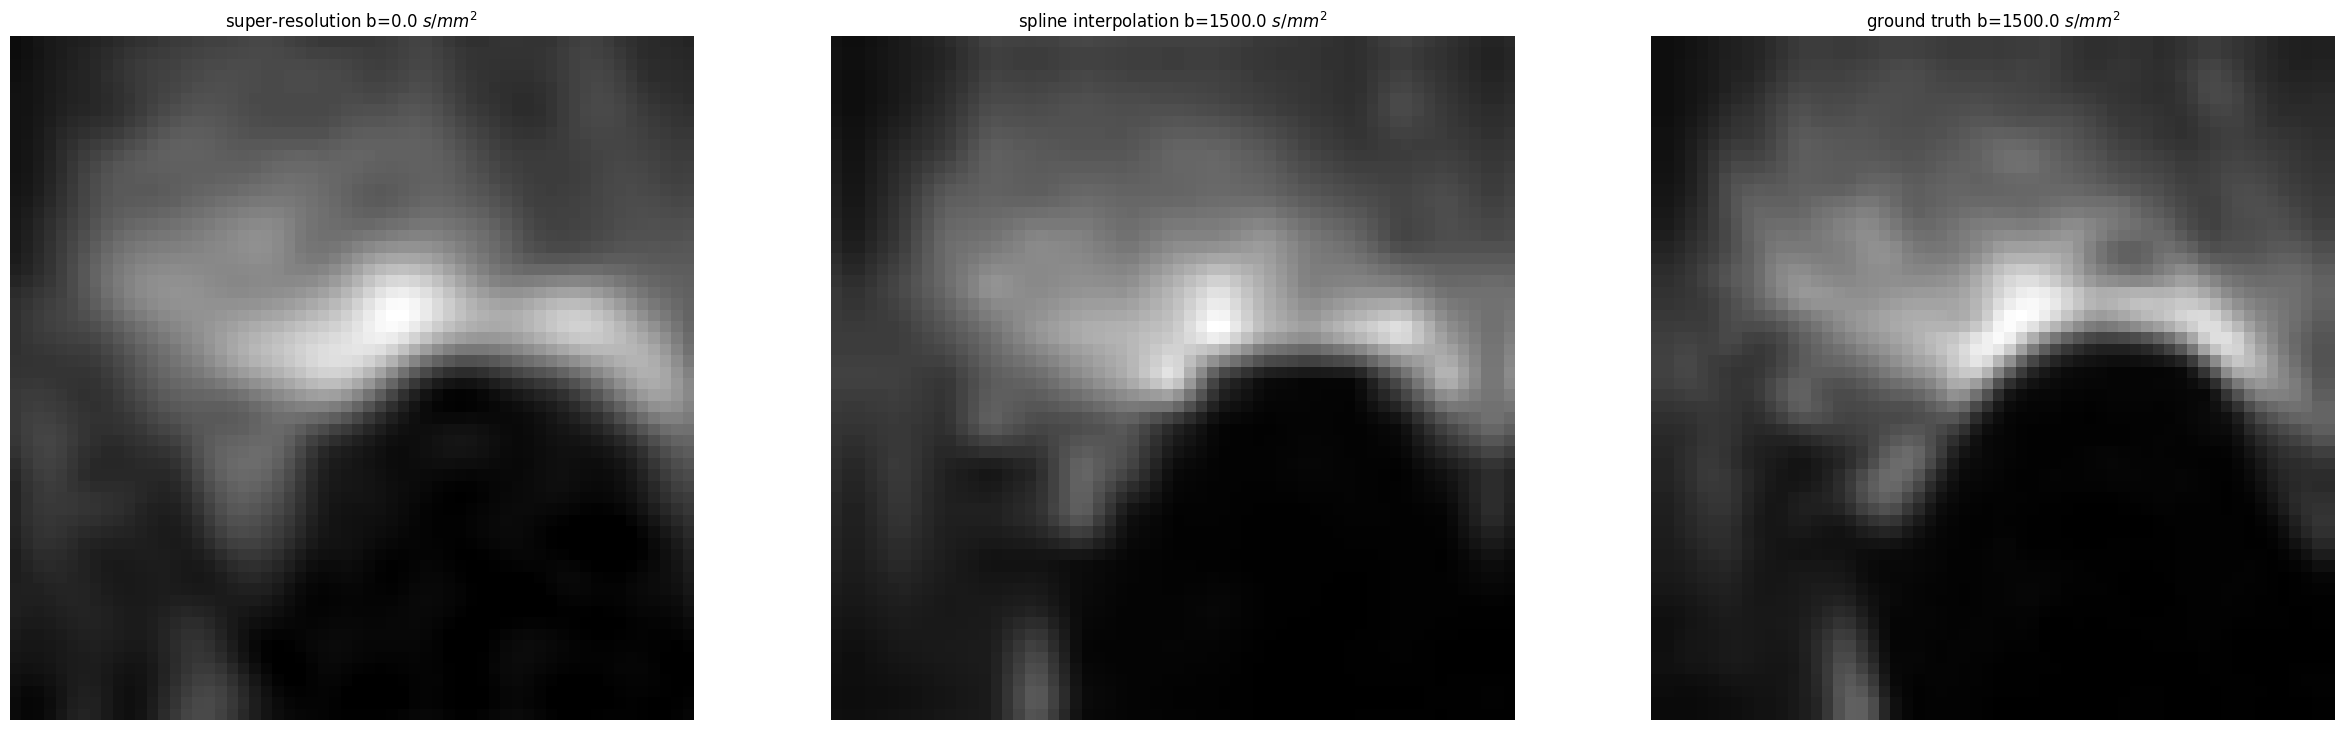

 40%|███▉      | 999/2500 [00:36<00:34, 43.56it/s]

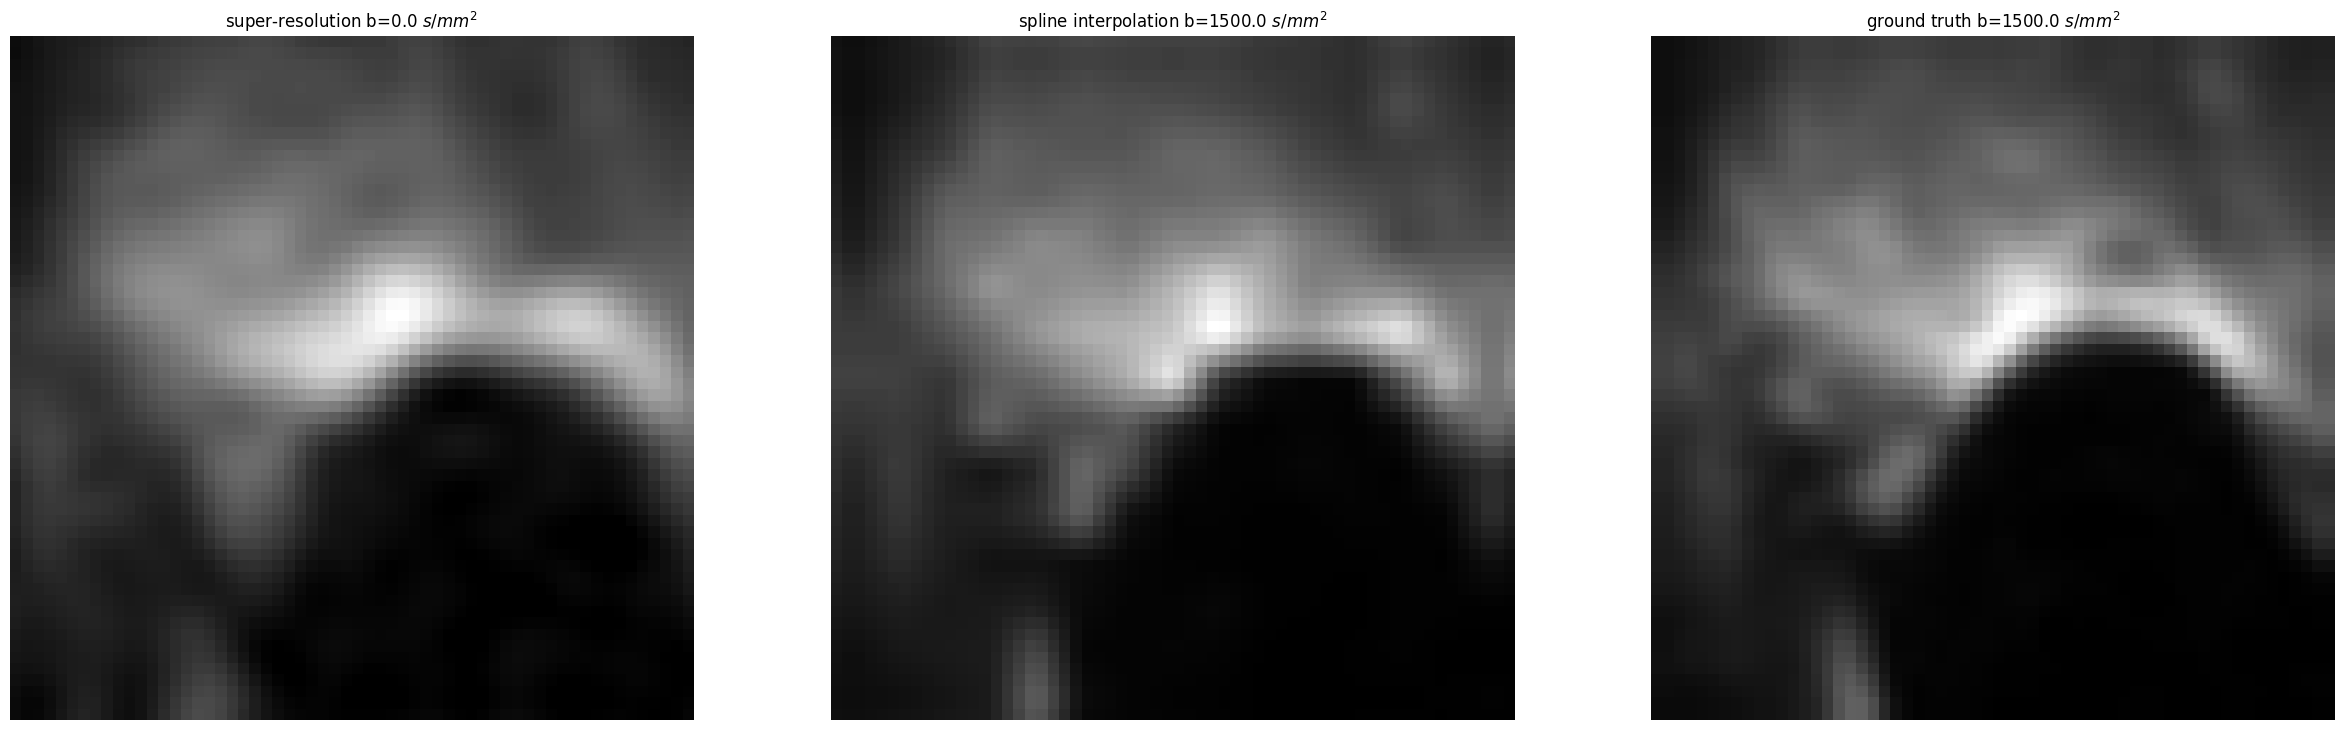

 42%|████▏     | 1049/2500 [00:38<00:33, 43.66it/s]

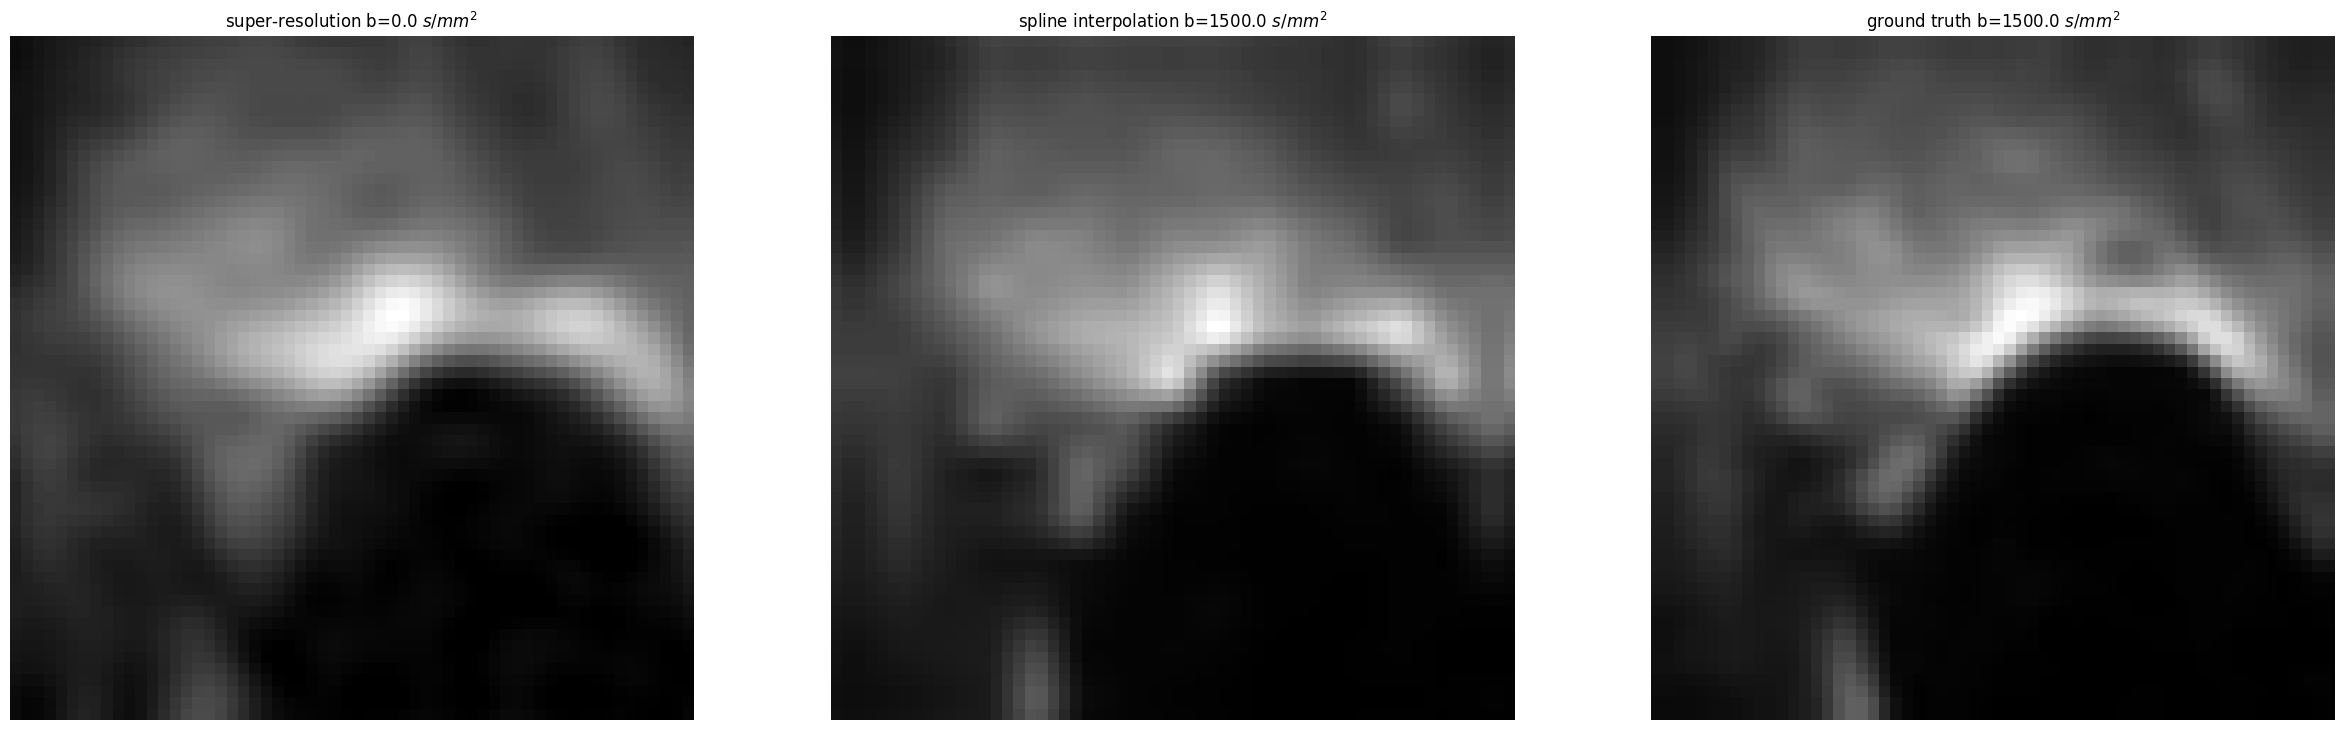

 44%|████▍     | 1099/2500 [00:40<00:32, 43.66it/s]

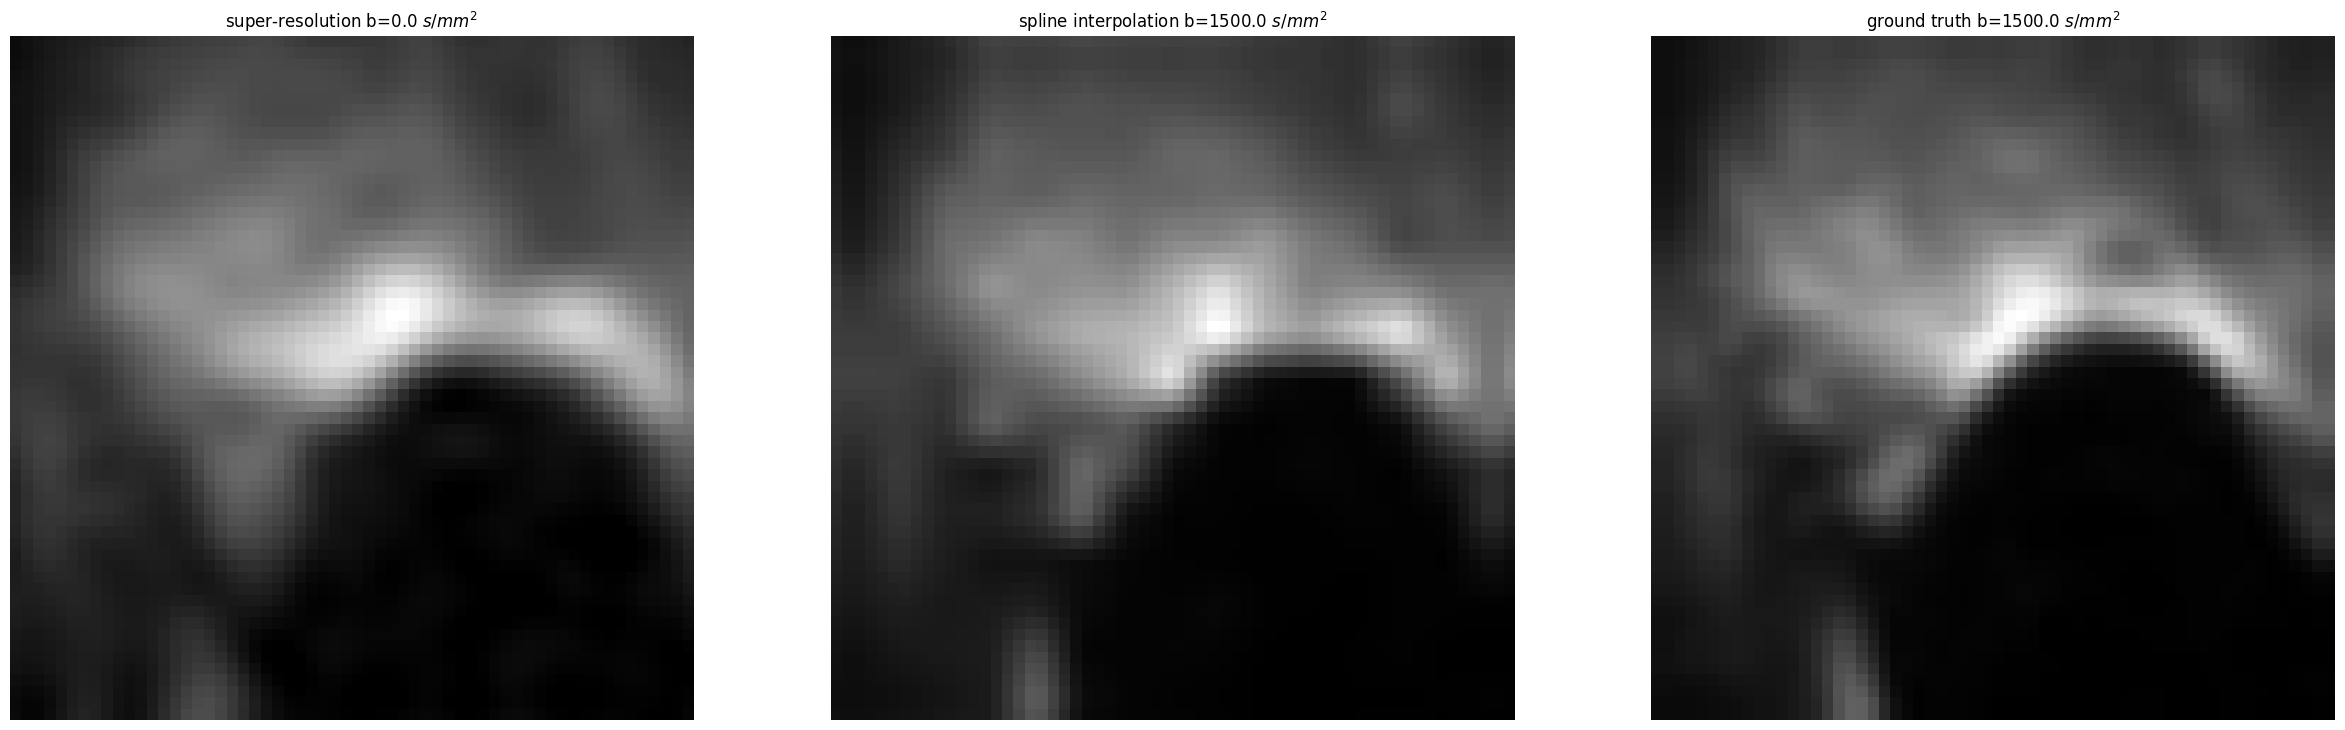

 46%|████▌     | 1149/2500 [00:42<00:31, 43.37it/s]

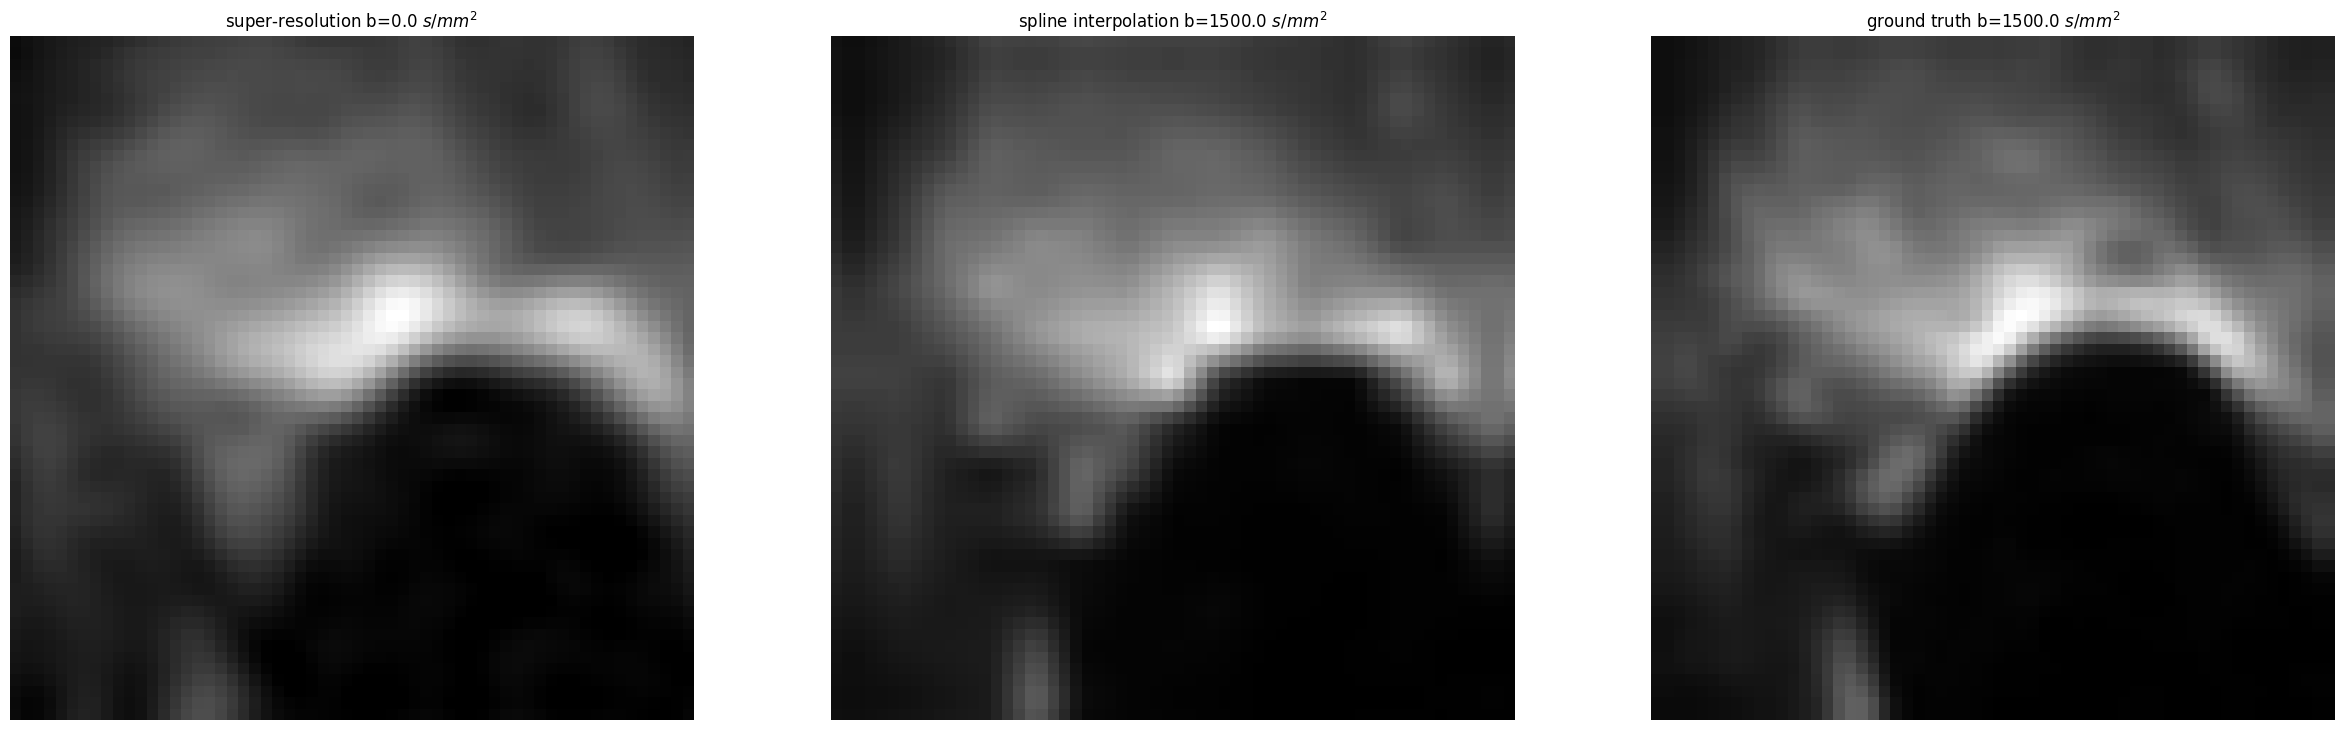

 48%|████▊     | 1199/2500 [00:44<00:29, 43.45it/s]

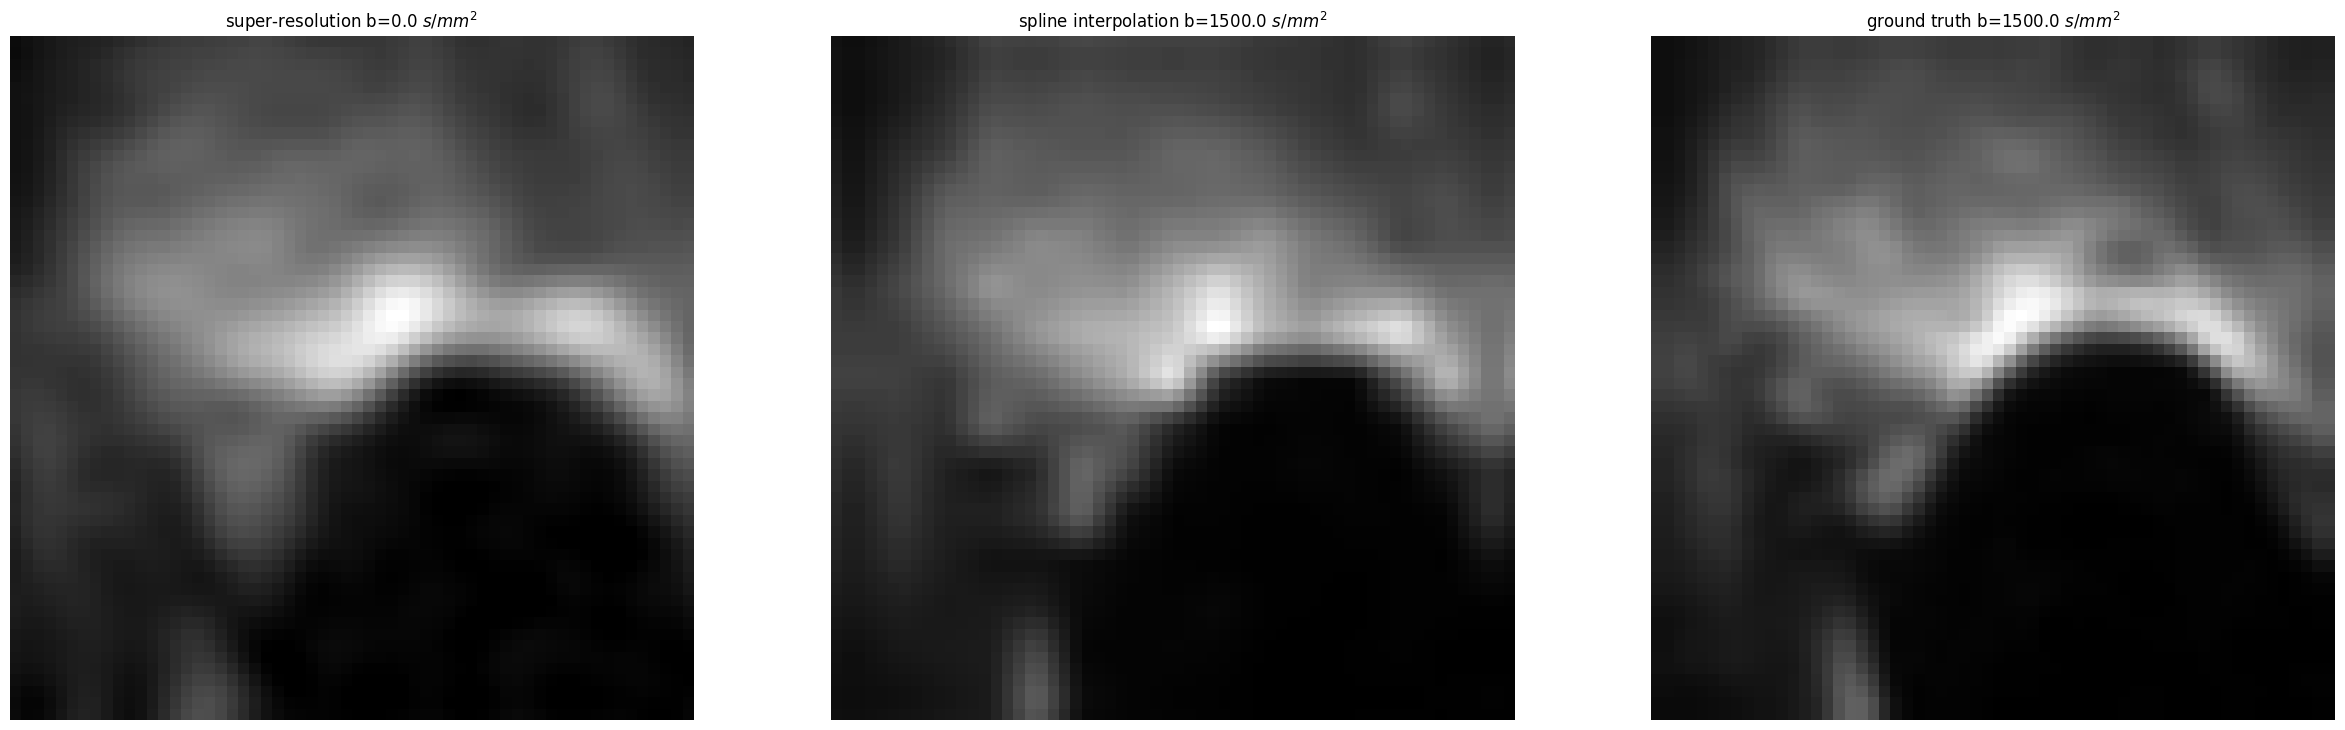

 50%|████▉     | 1249/2500 [00:45<00:28, 43.63it/s]

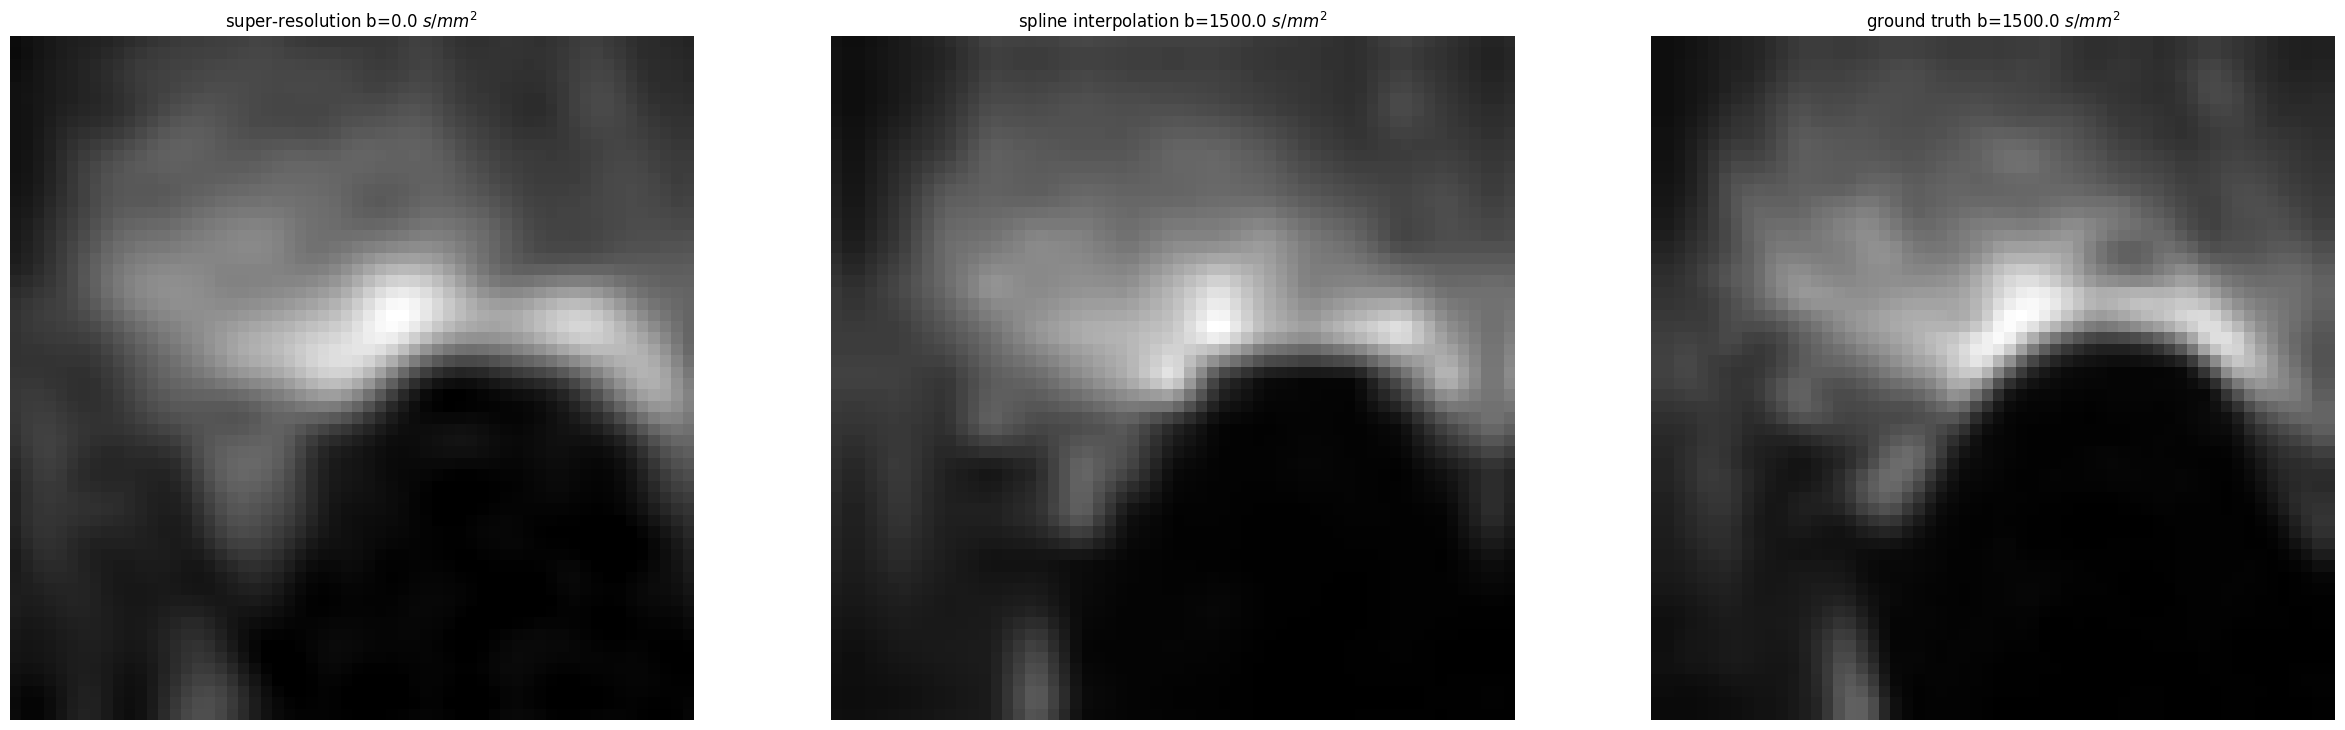

 52%|█████▏    | 1299/2500 [00:47<00:27, 43.47it/s]

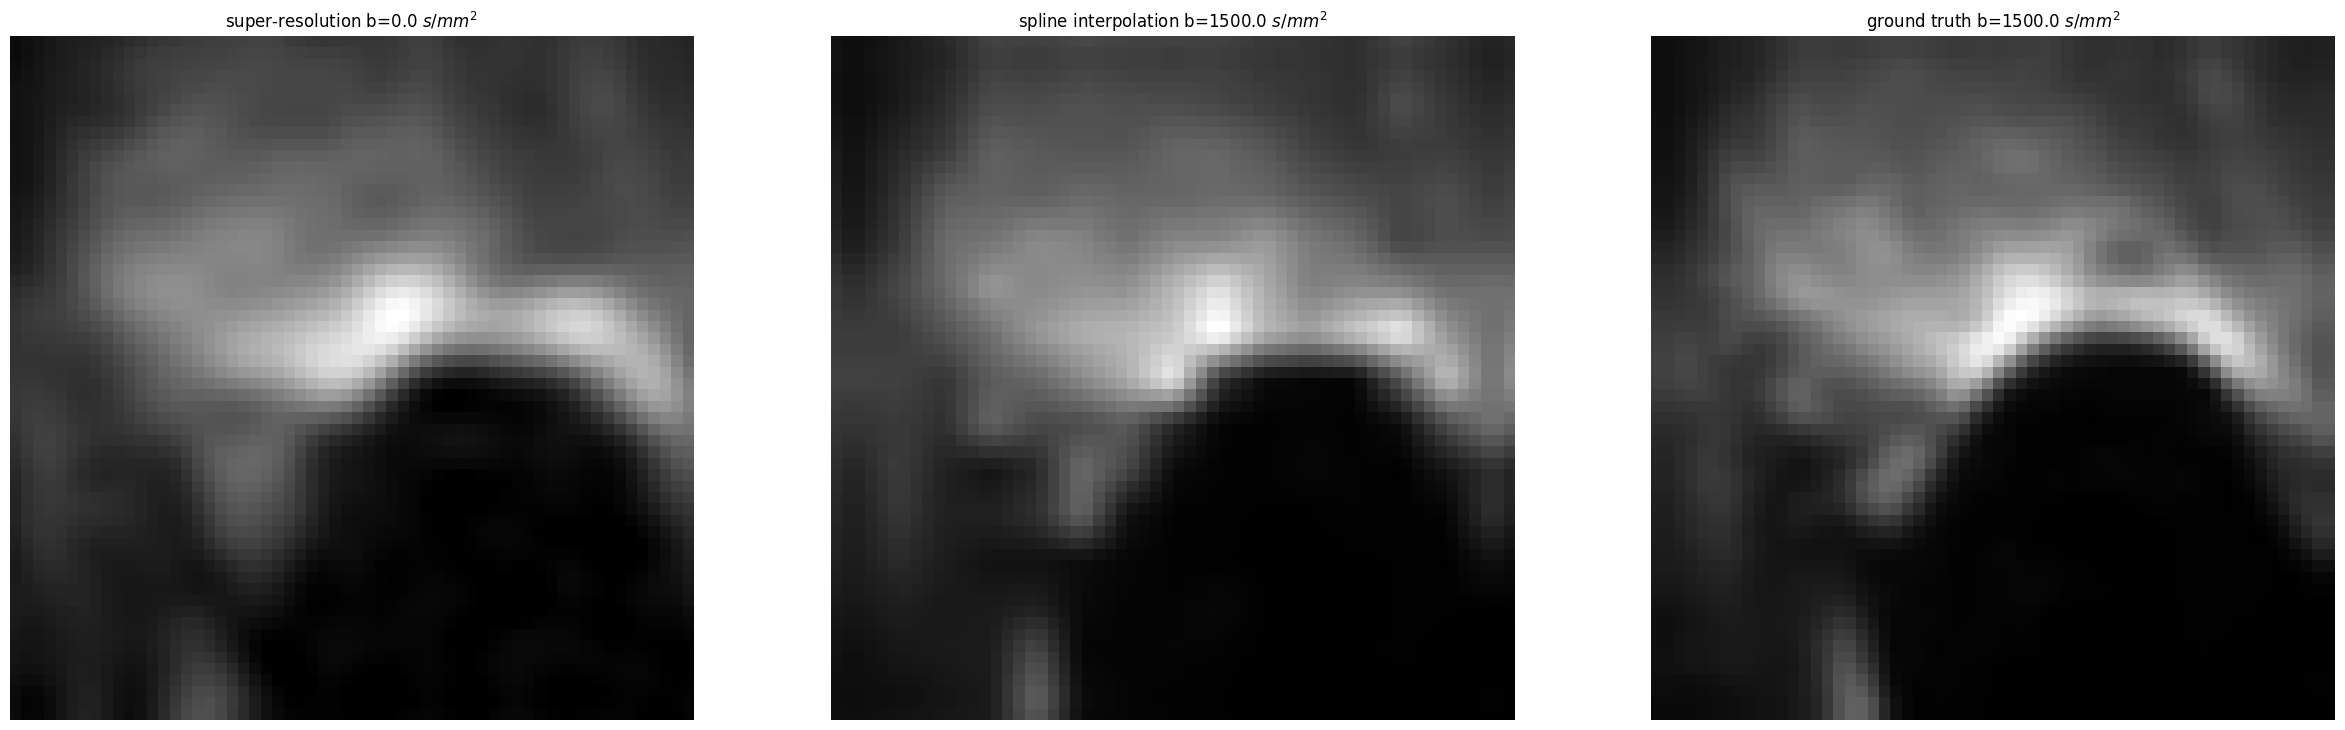

 54%|█████▍    | 1349/2500 [00:49<00:26, 44.04it/s]

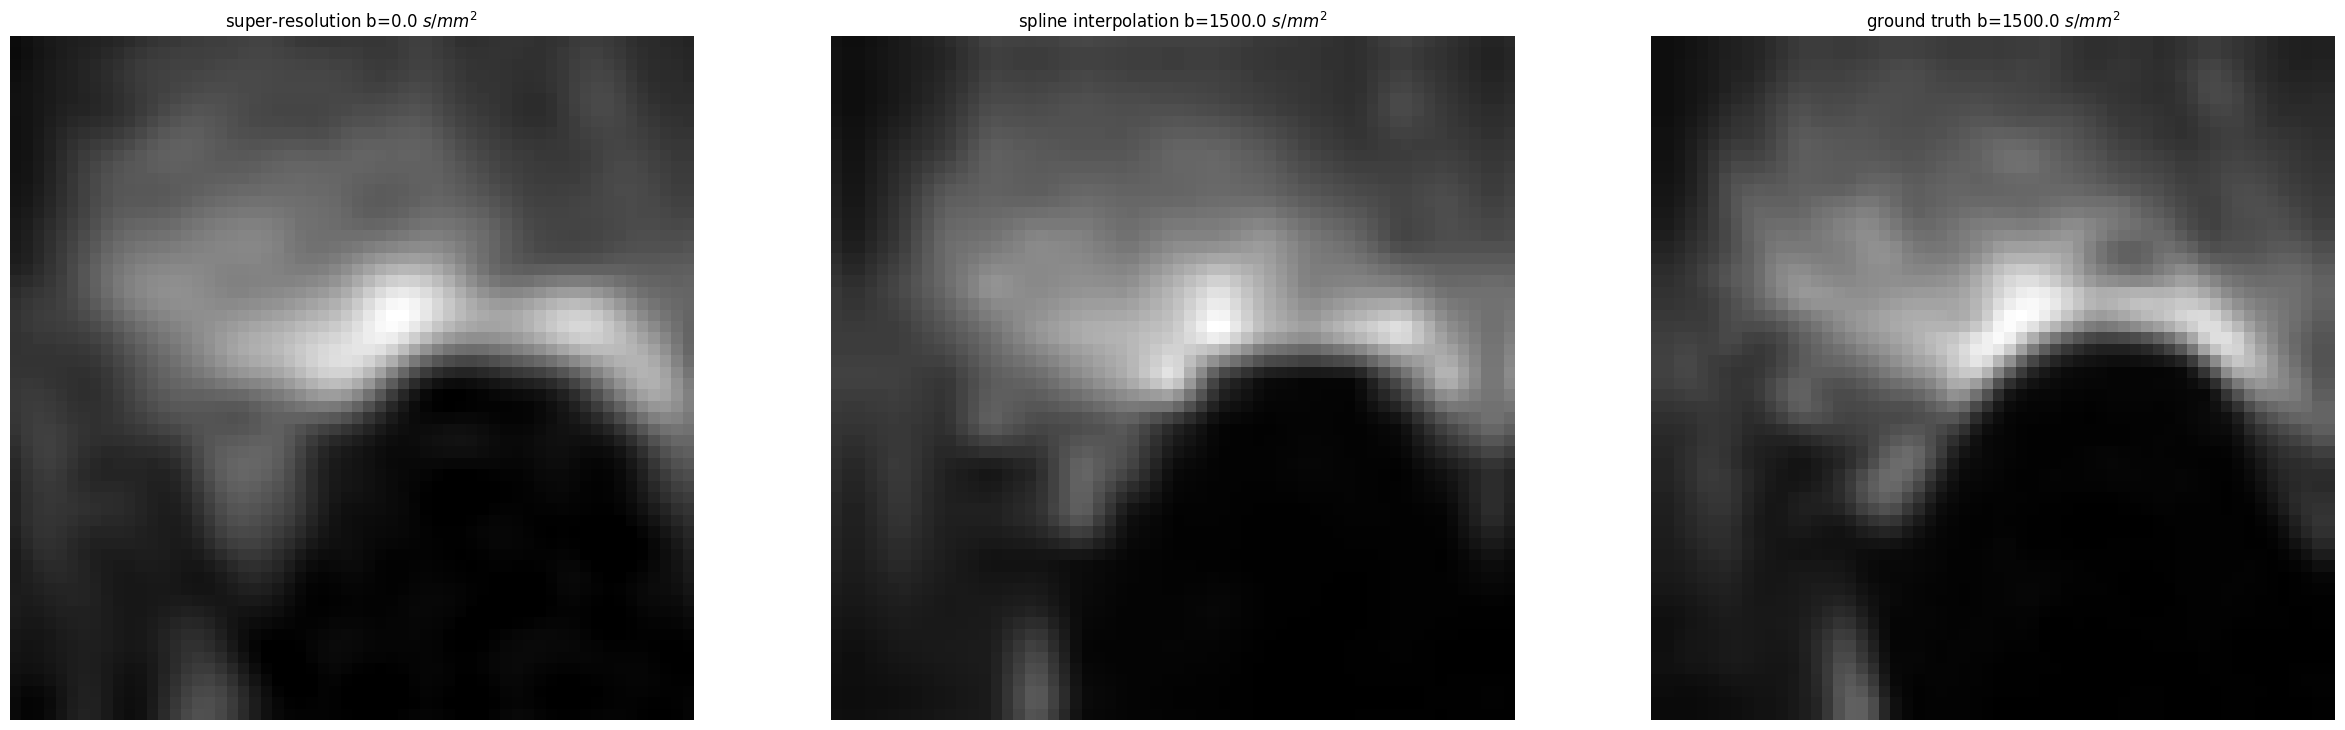

 56%|█████▌    | 1399/2500 [00:51<00:24, 44.28it/s]

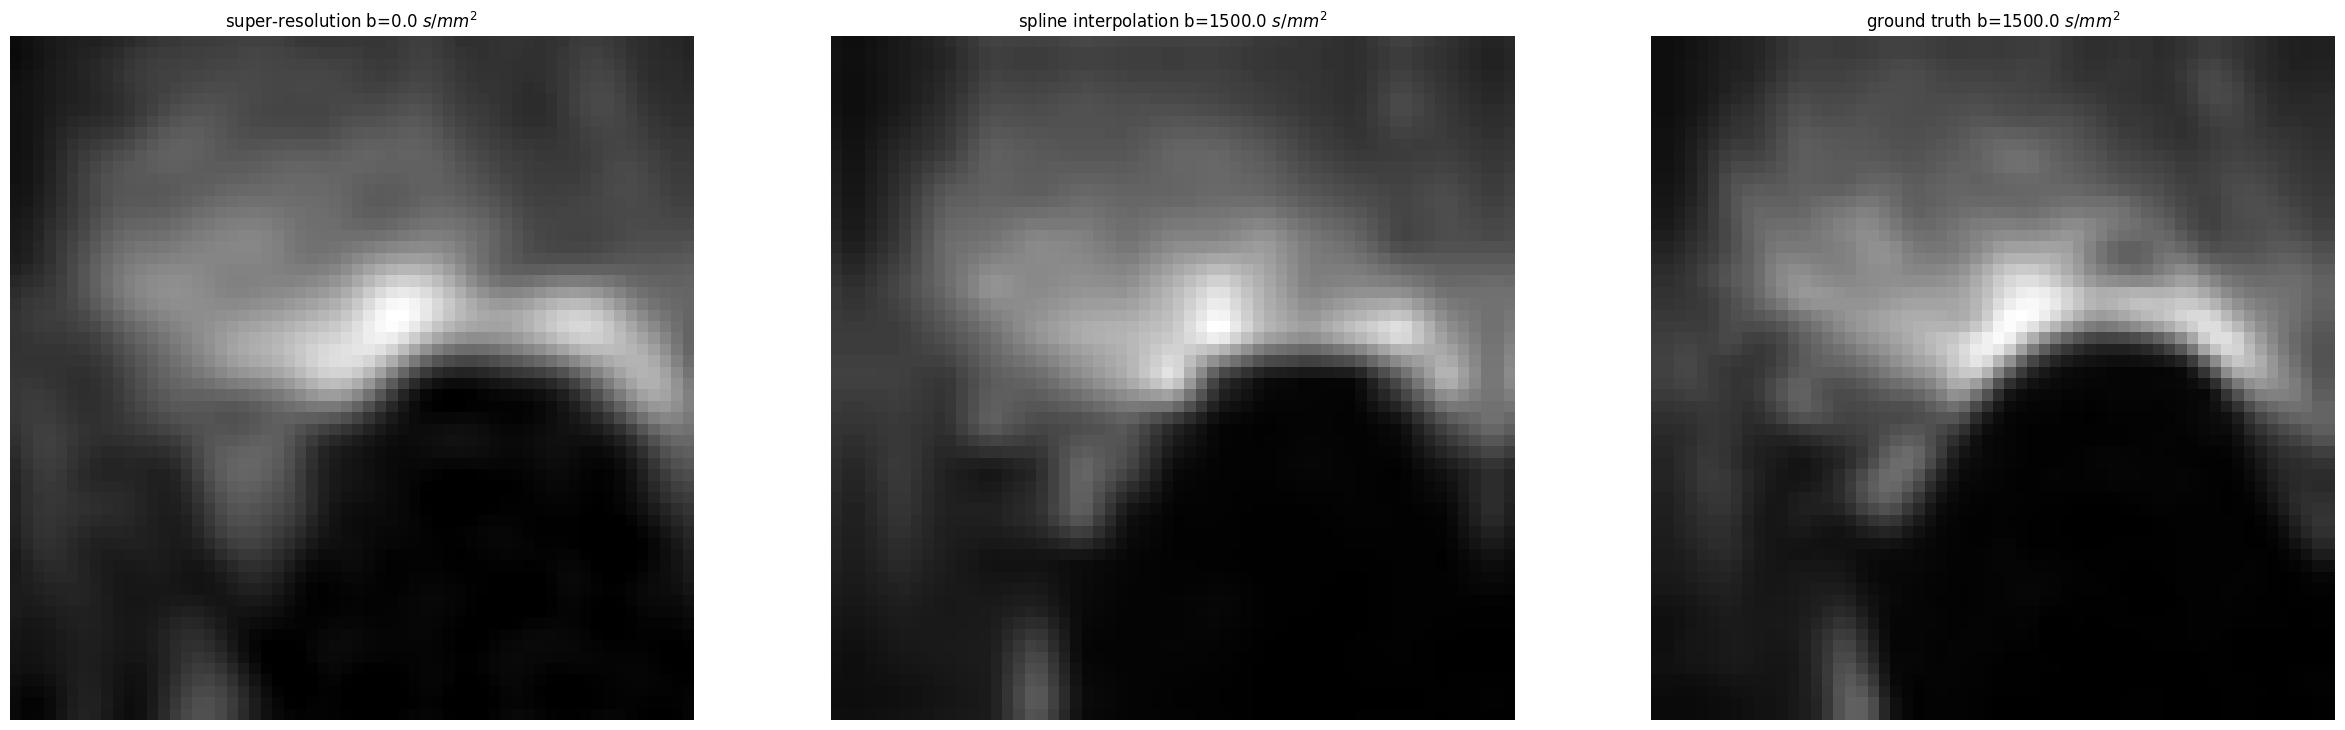

 58%|█████▊    | 1449/2500 [00:52<00:24, 43.71it/s]

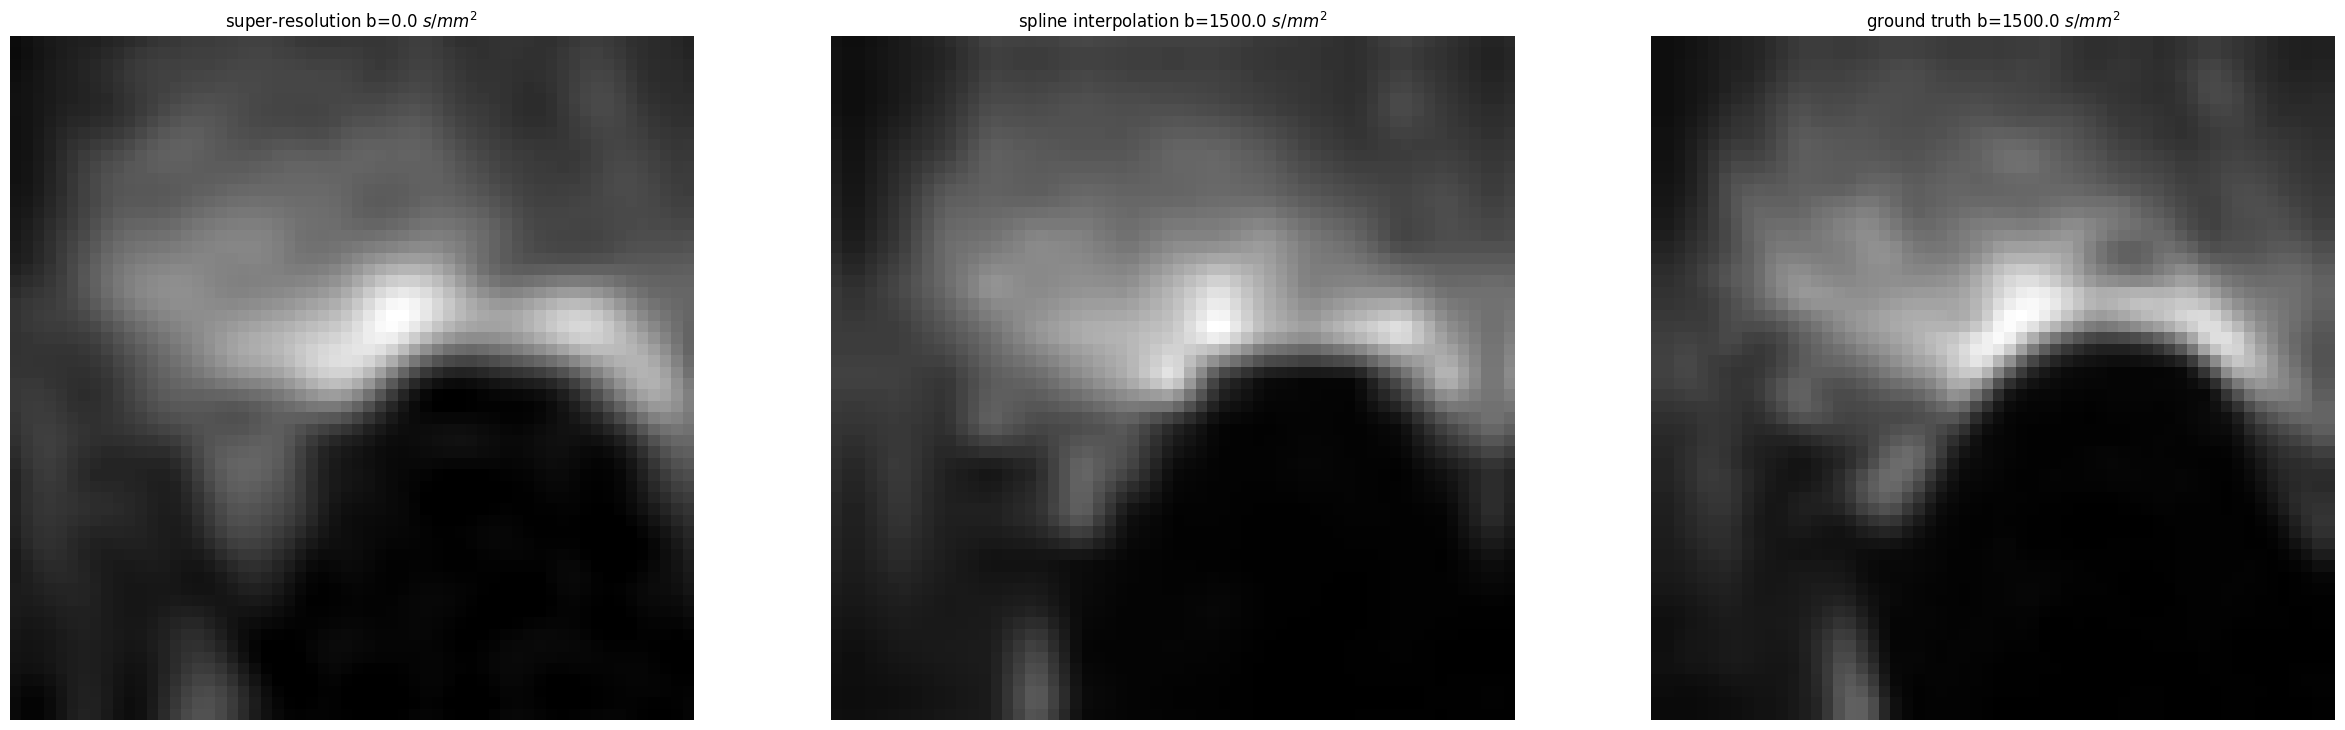

 60%|█████▉    | 1499/2500 [00:54<00:22, 43.63it/s]

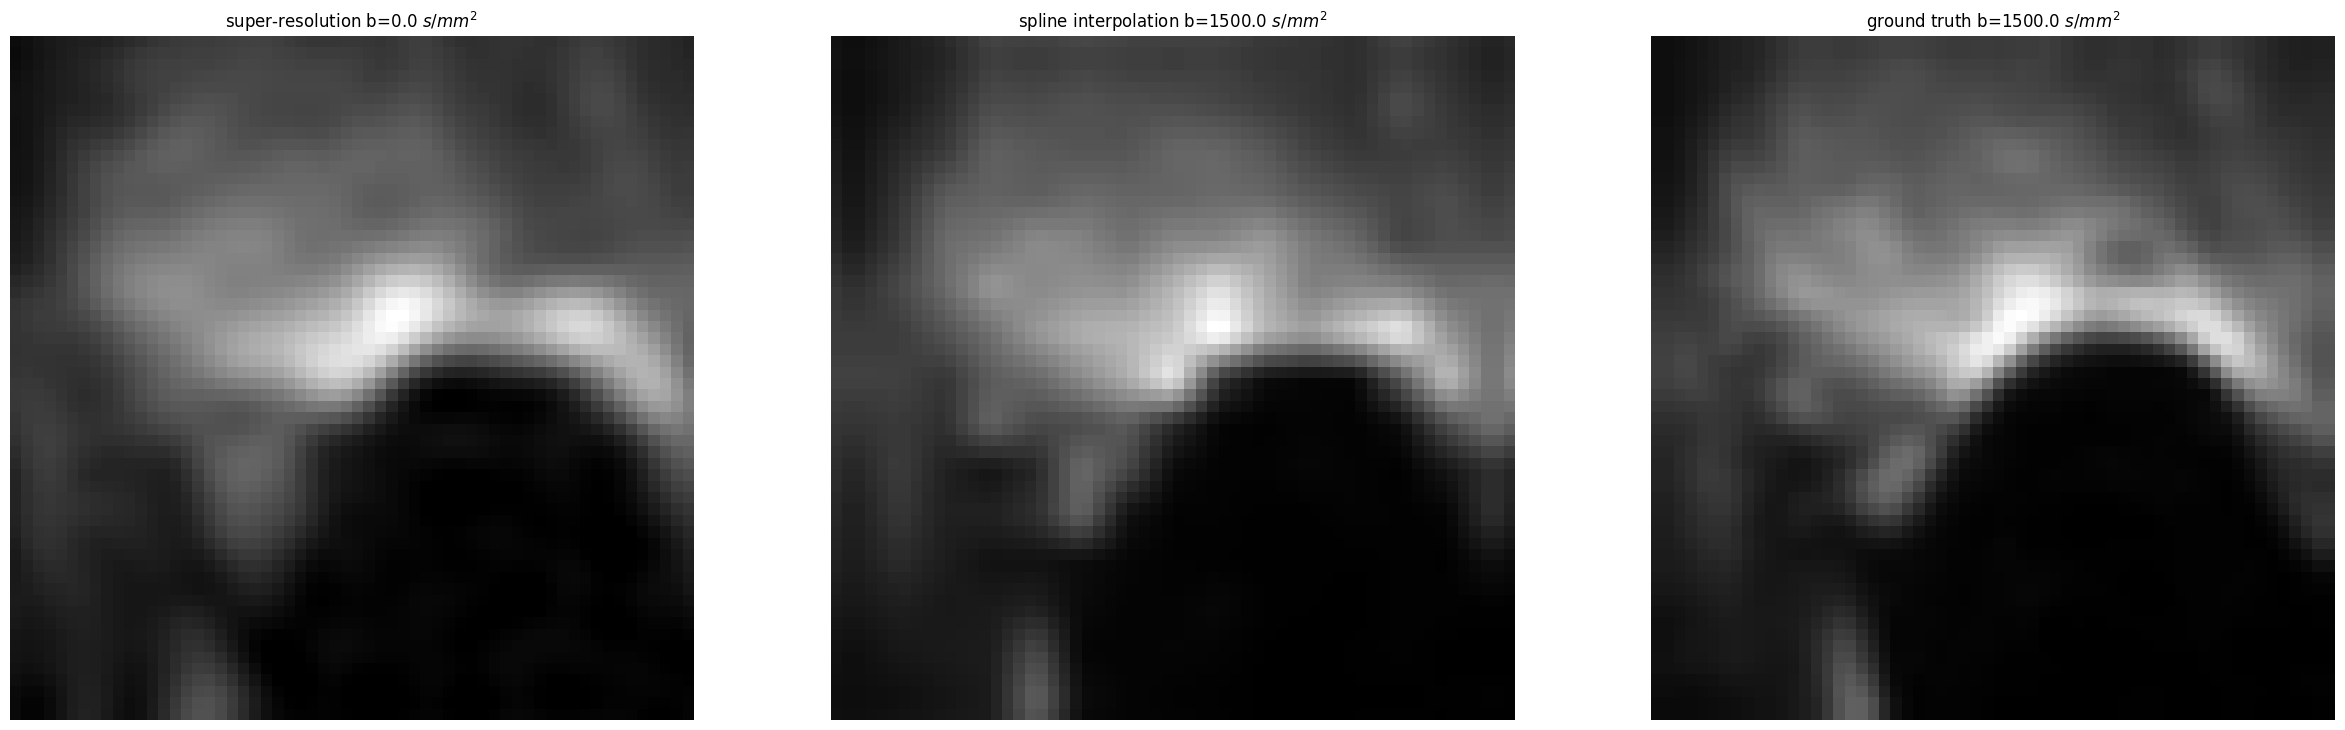

 62%|██████▏   | 1549/2500 [00:57<00:23, 39.97it/s]

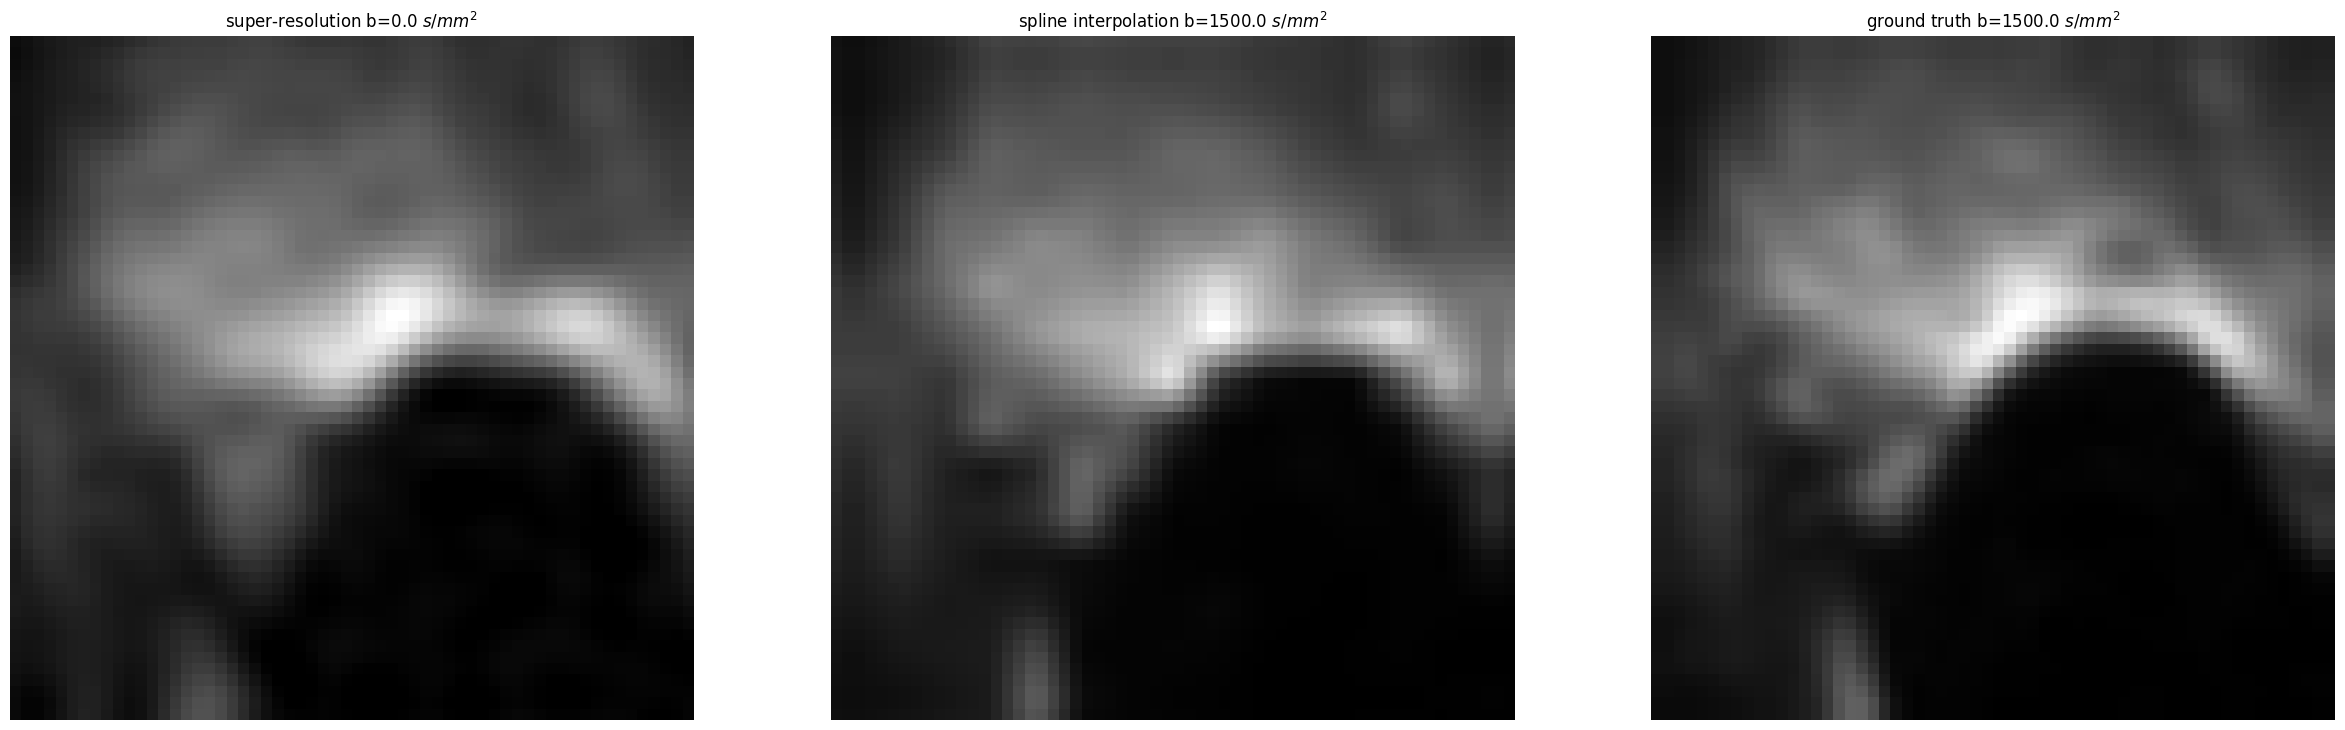

 64%|██████▍   | 1599/2500 [00:58<00:20, 43.40it/s]

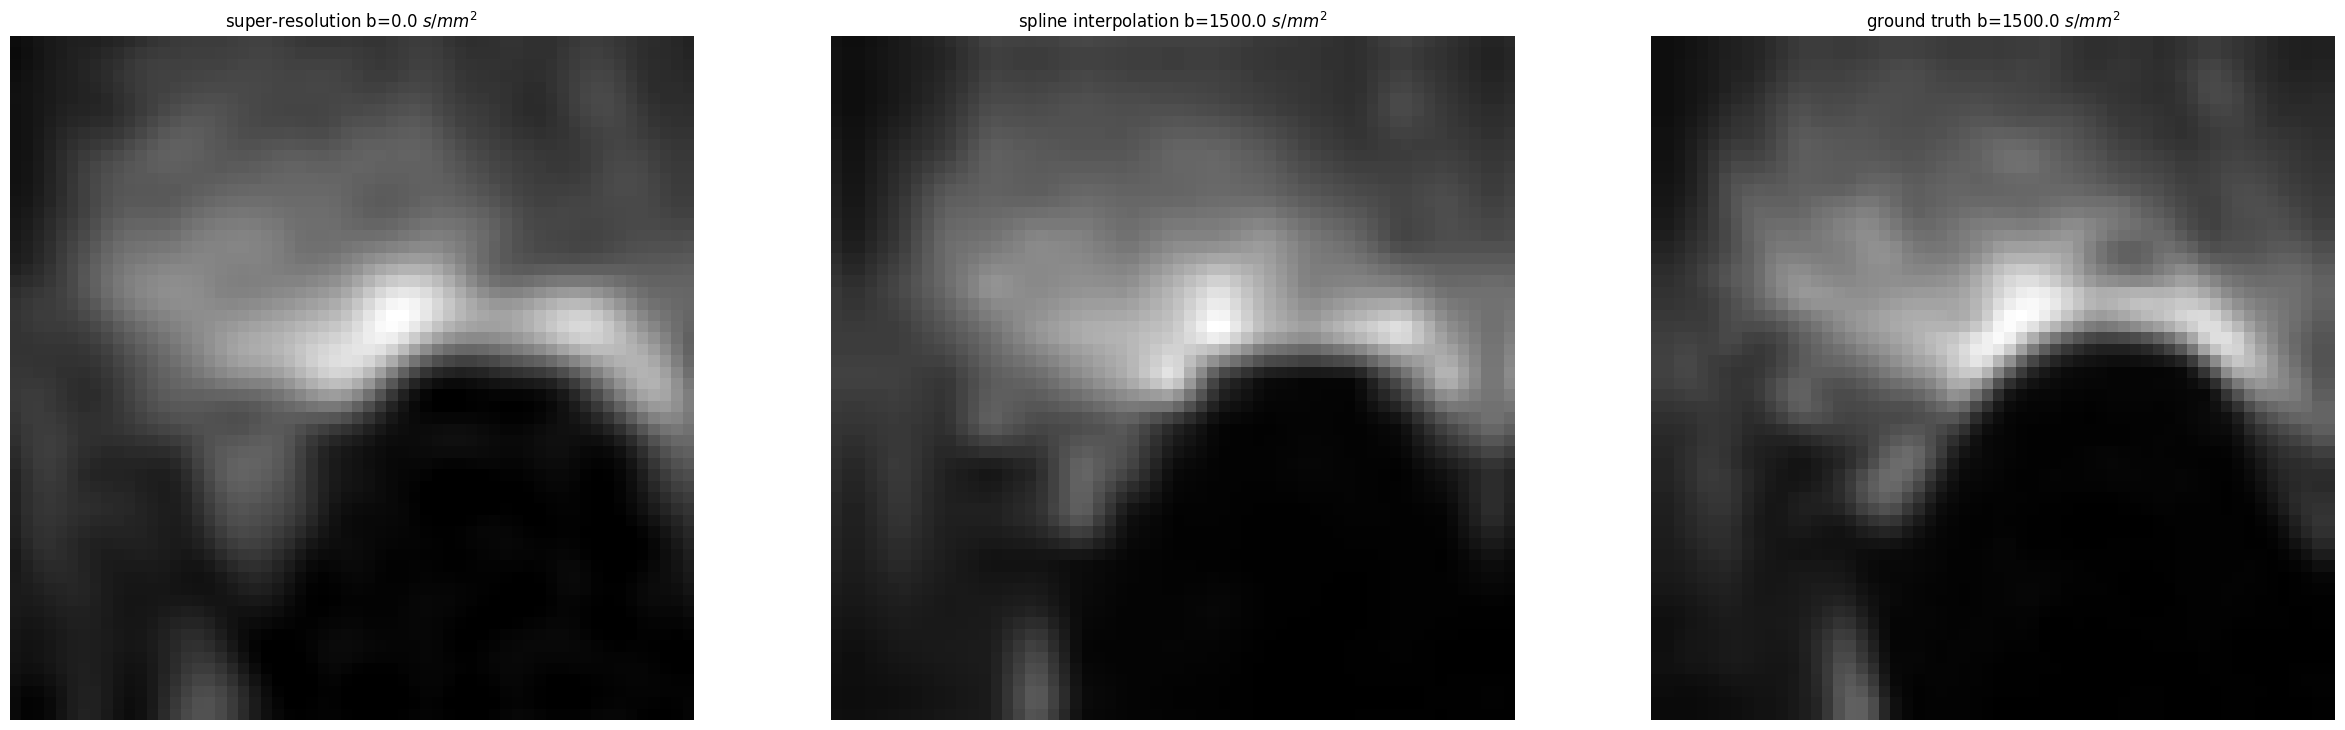

 66%|██████▌   | 1649/2500 [01:00<00:19, 43.65it/s]

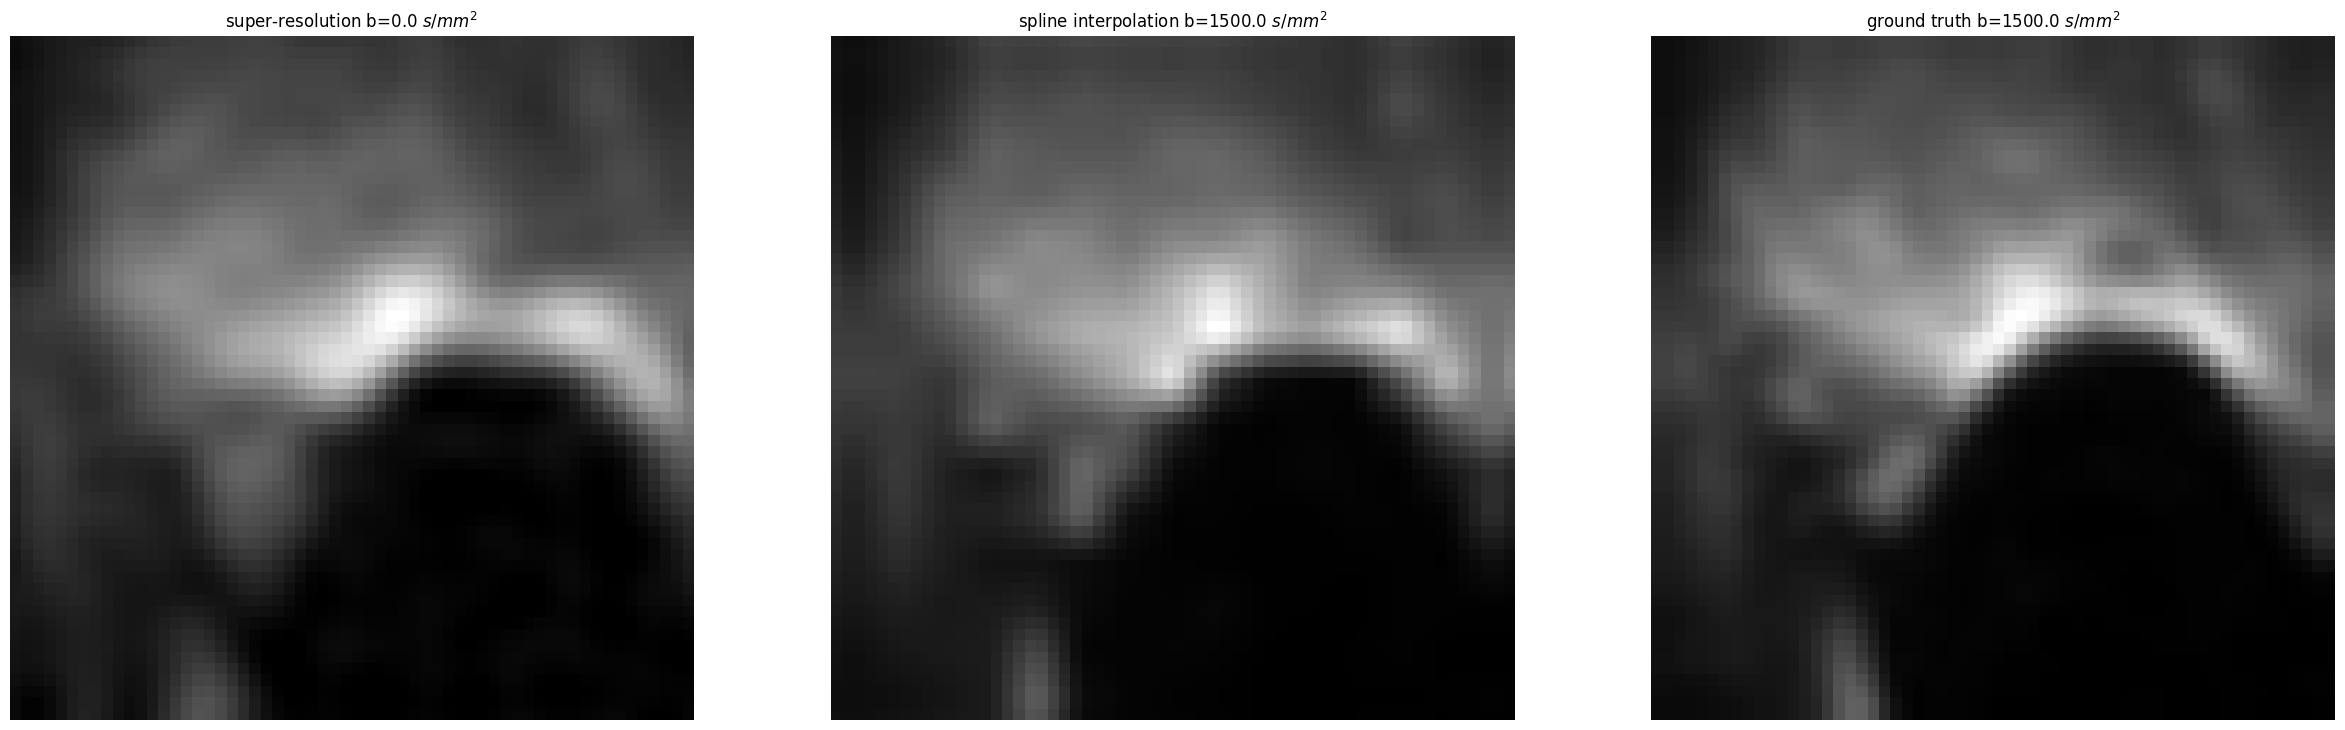

 68%|██████▊   | 1699/2500 [01:02<00:18, 43.69it/s]

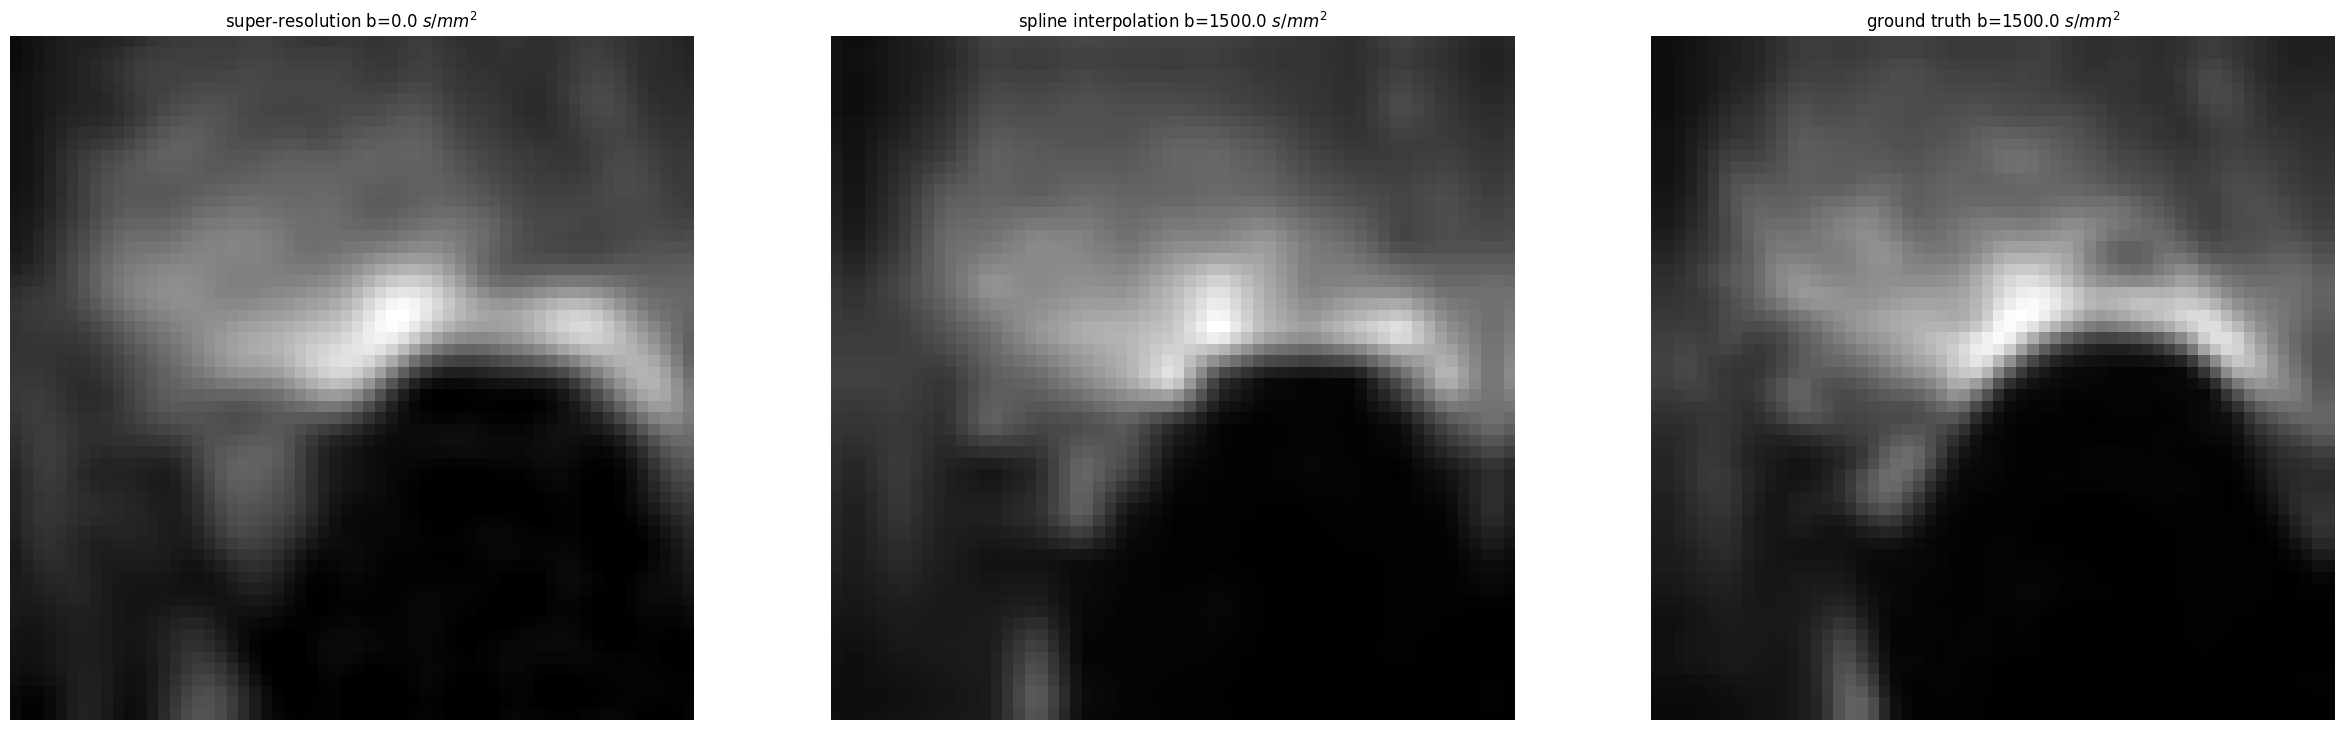

 70%|██████▉   | 1749/2500 [01:04<00:17, 43.97it/s]

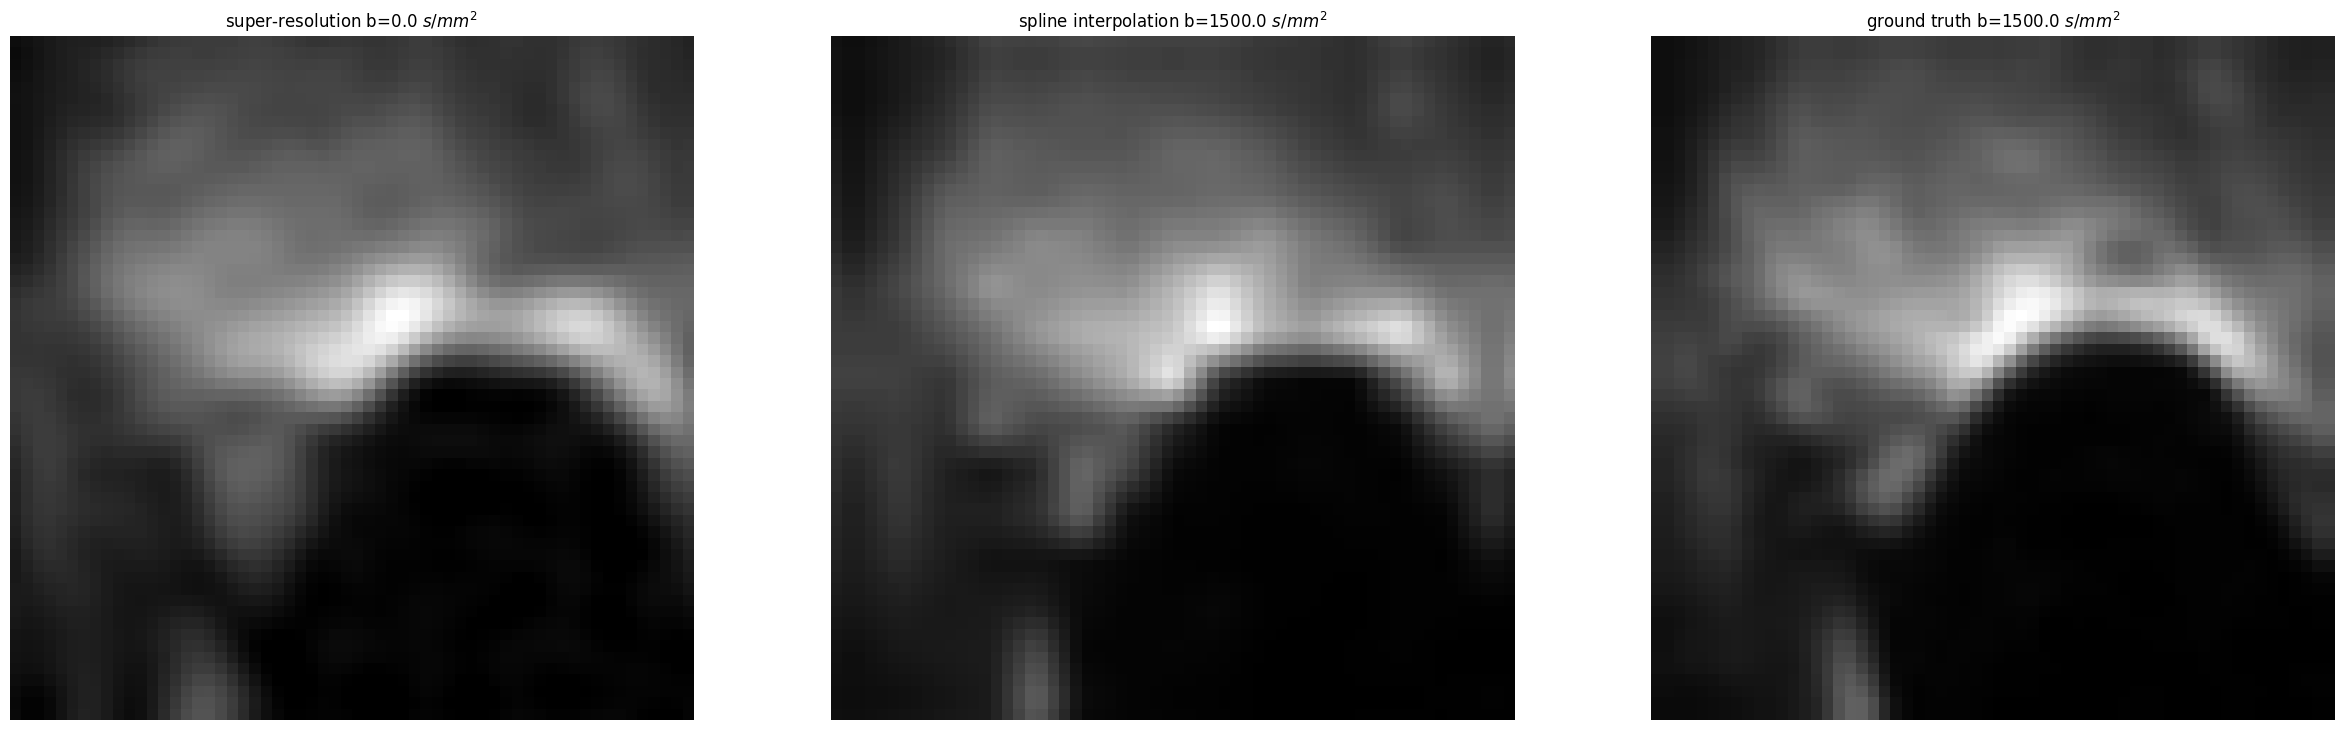

 72%|███████▏  | 1799/2500 [01:06<00:16, 42.91it/s]

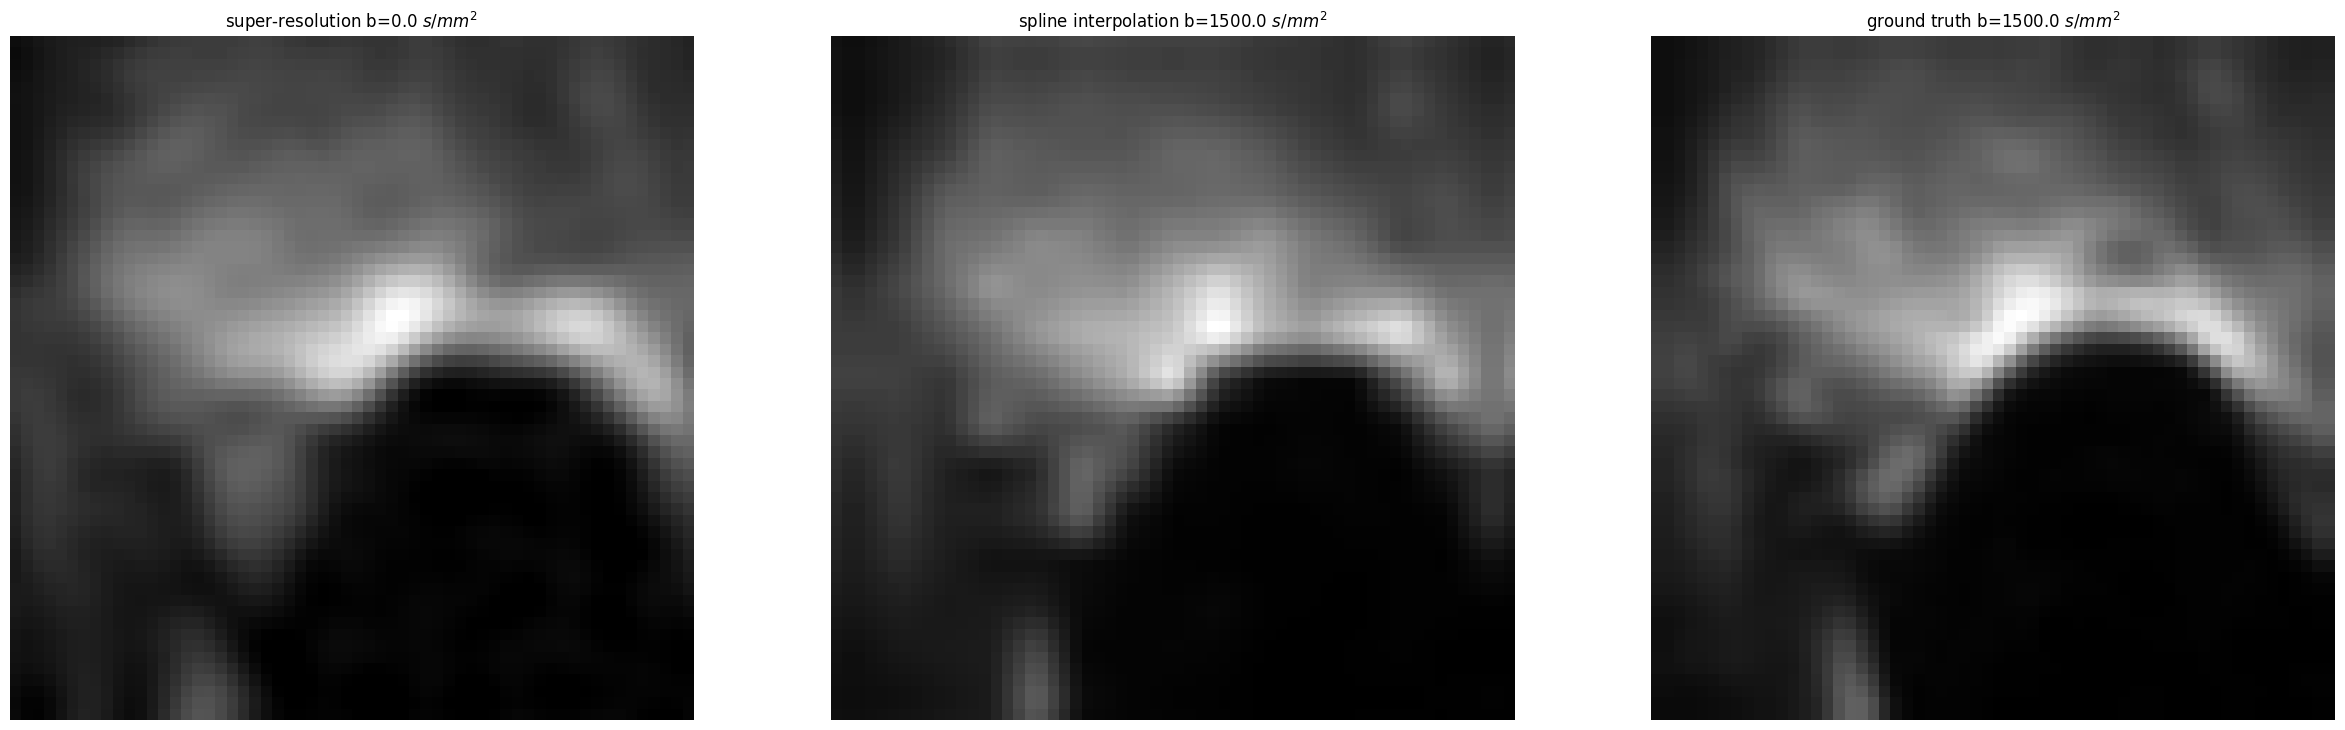

 74%|███████▍  | 1849/2500 [01:07<00:14, 43.71it/s]

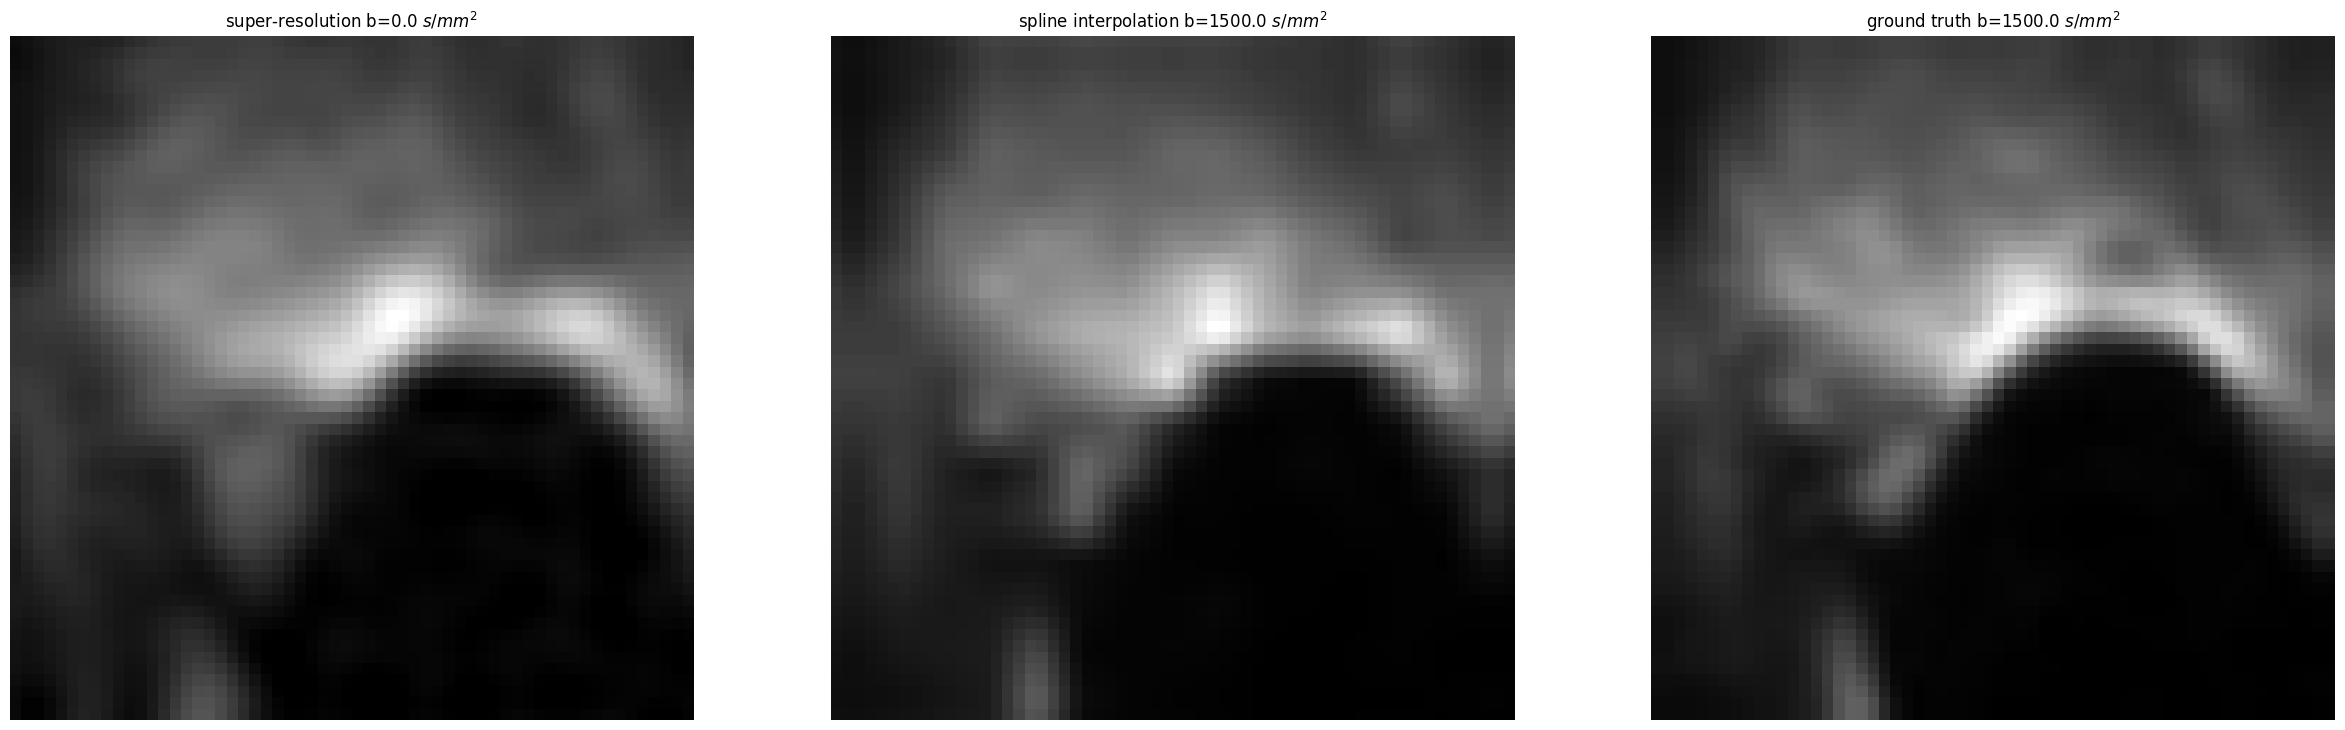

 76%|███████▌  | 1899/2500 [01:09<00:13, 43.66it/s]

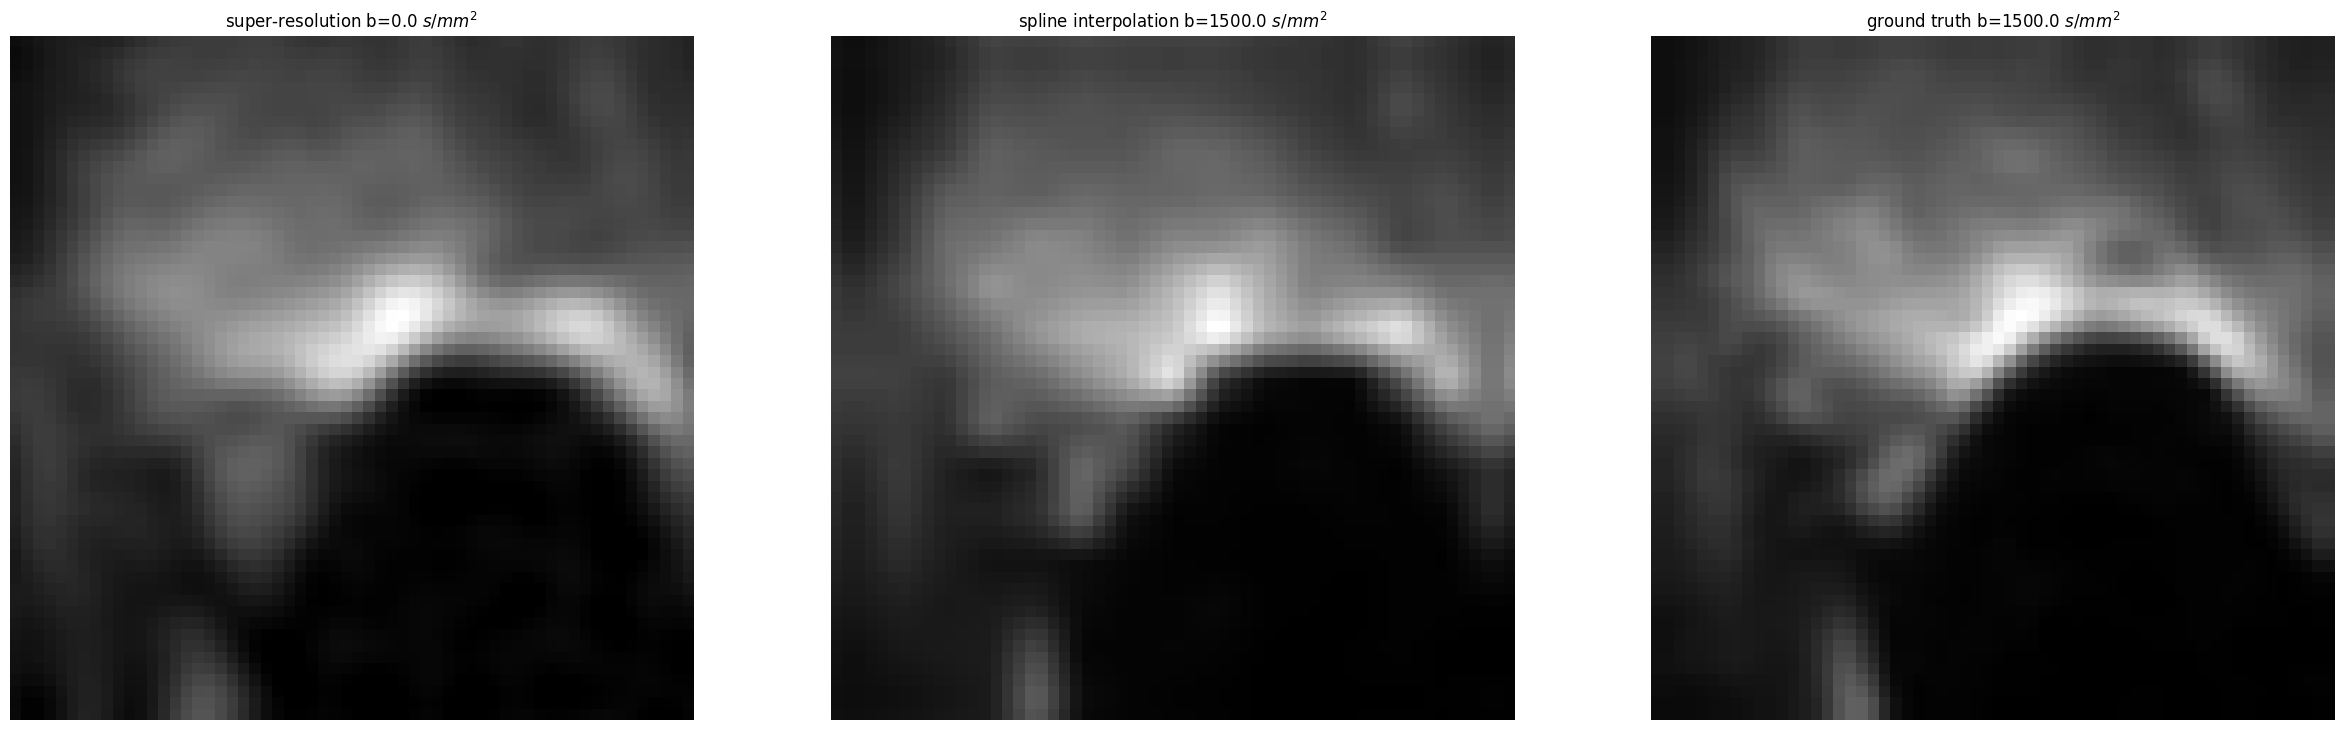

 78%|███████▊  | 1949/2500 [01:11<00:12, 43.98it/s]

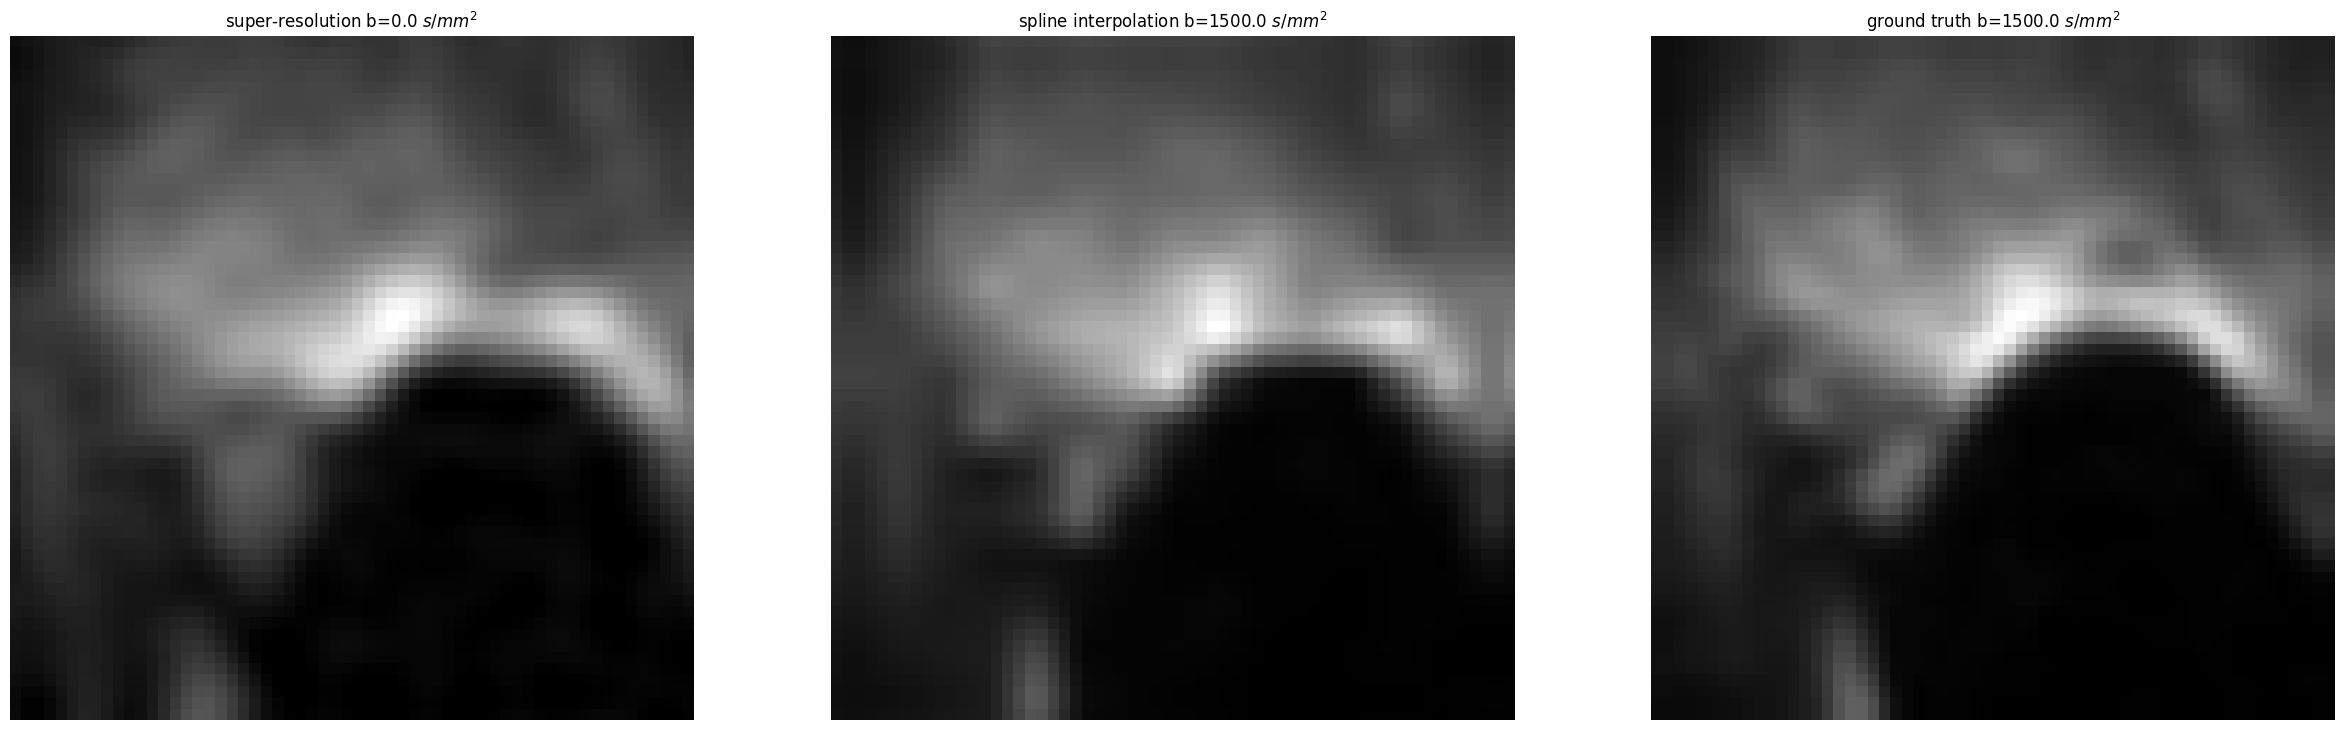

 80%|███████▉  | 1999/2500 [01:13<00:11, 43.15it/s]

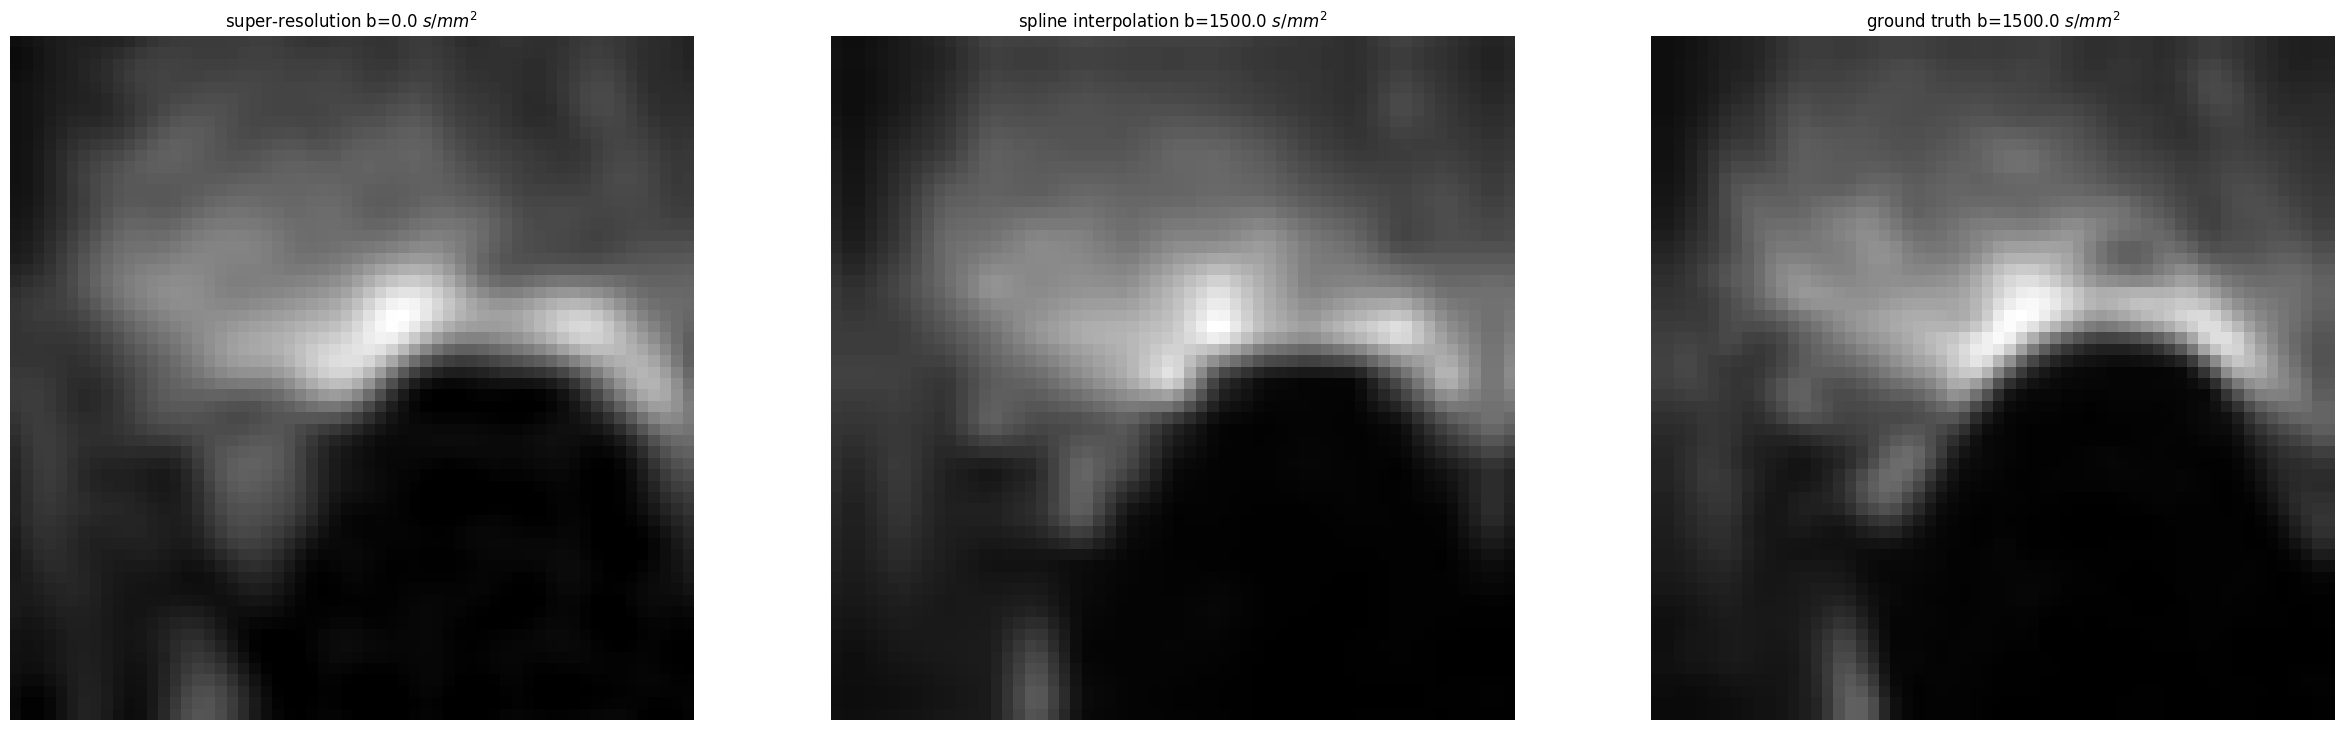

 82%|████████▏ | 2049/2500 [01:15<00:10, 43.20it/s]

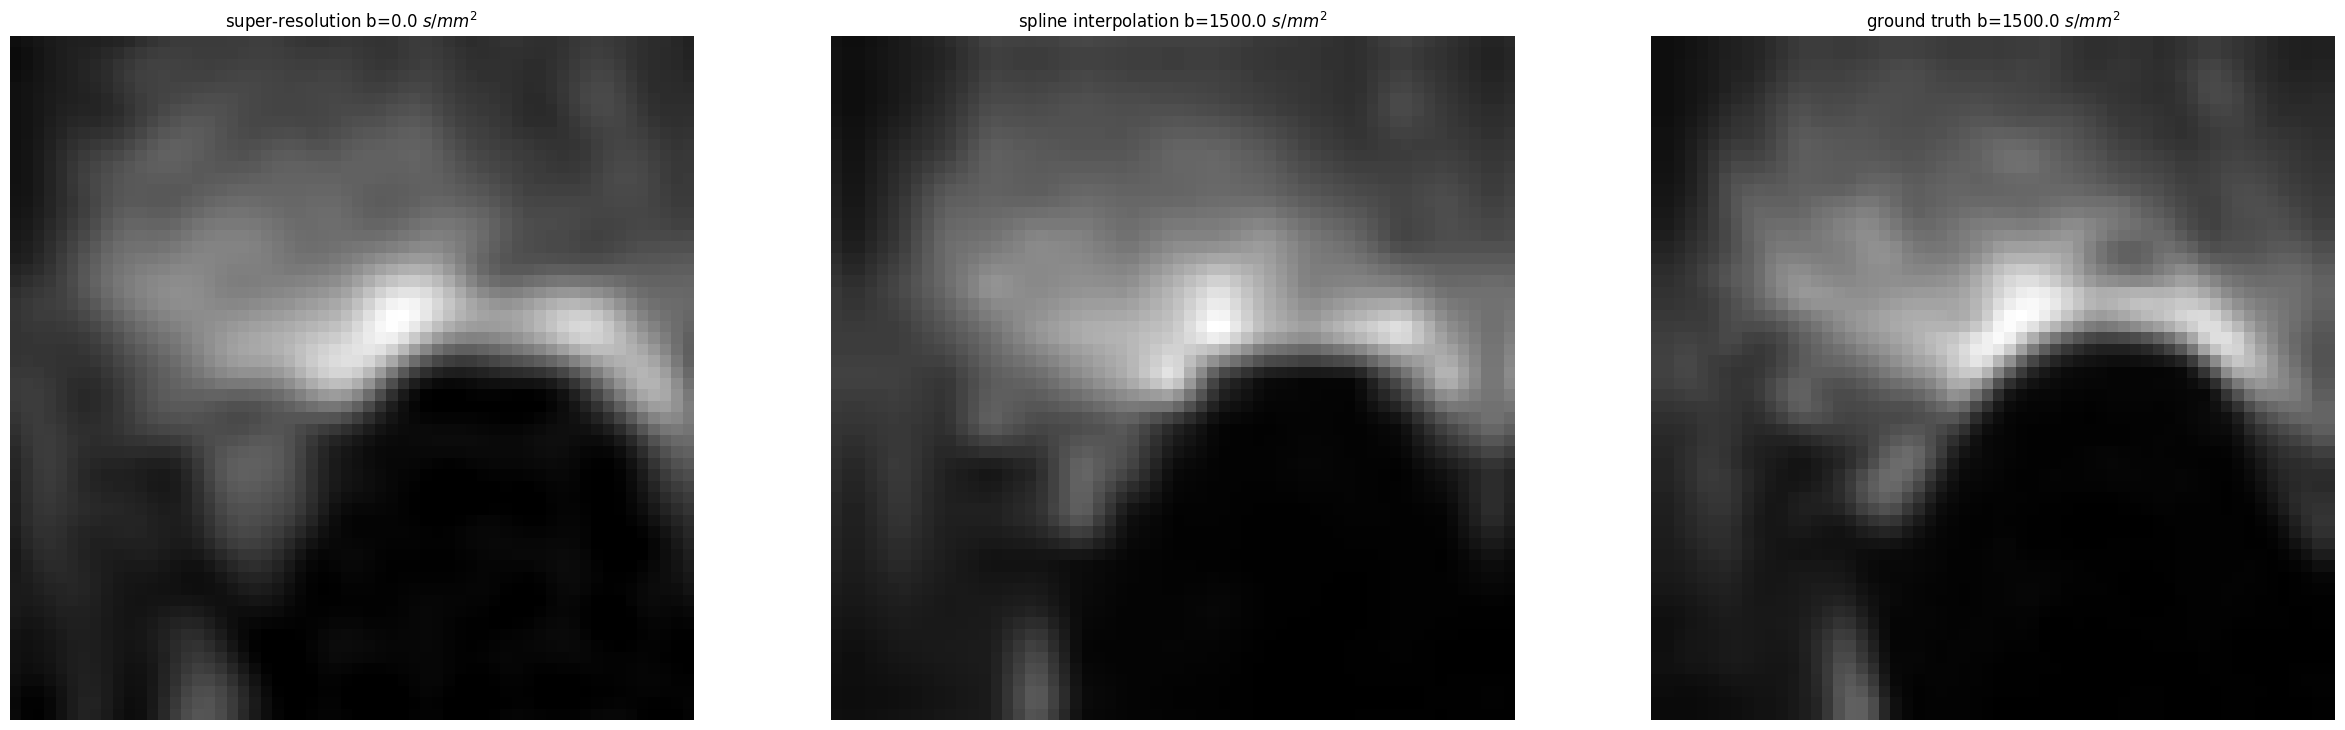

 84%|████████▍ | 2099/2500 [01:17<00:09, 43.18it/s]

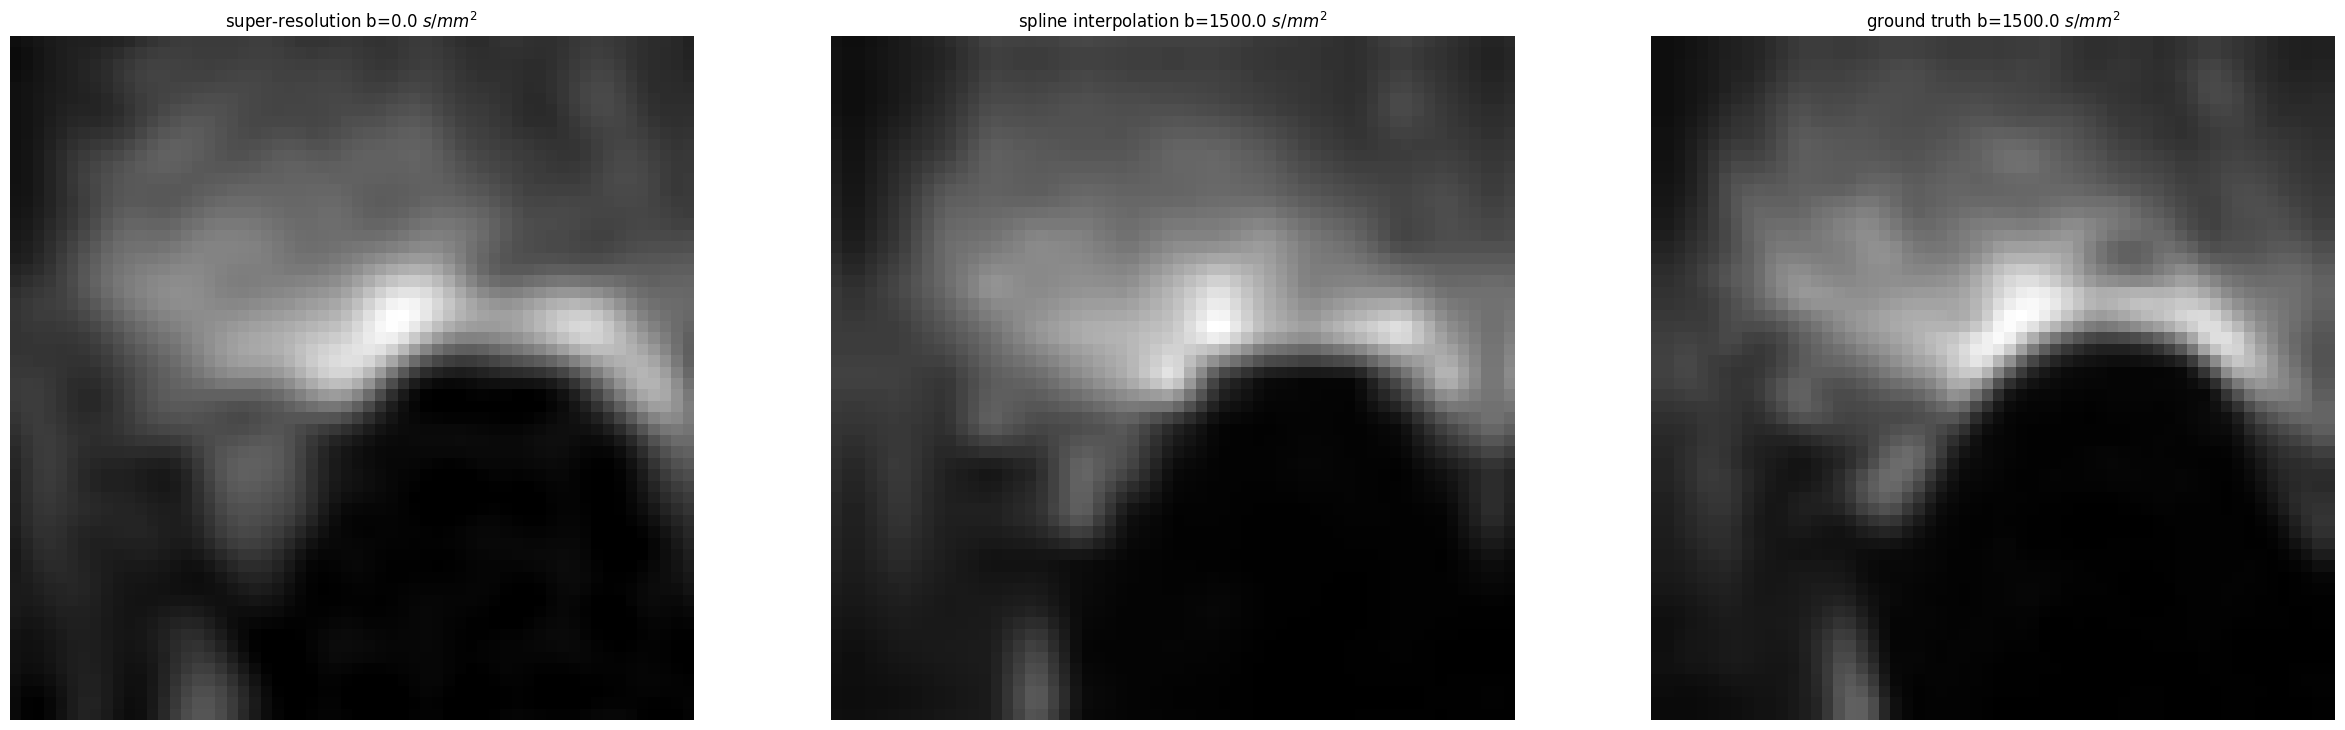

 86%|████████▌ | 2149/2500 [01:18<00:08, 43.30it/s]

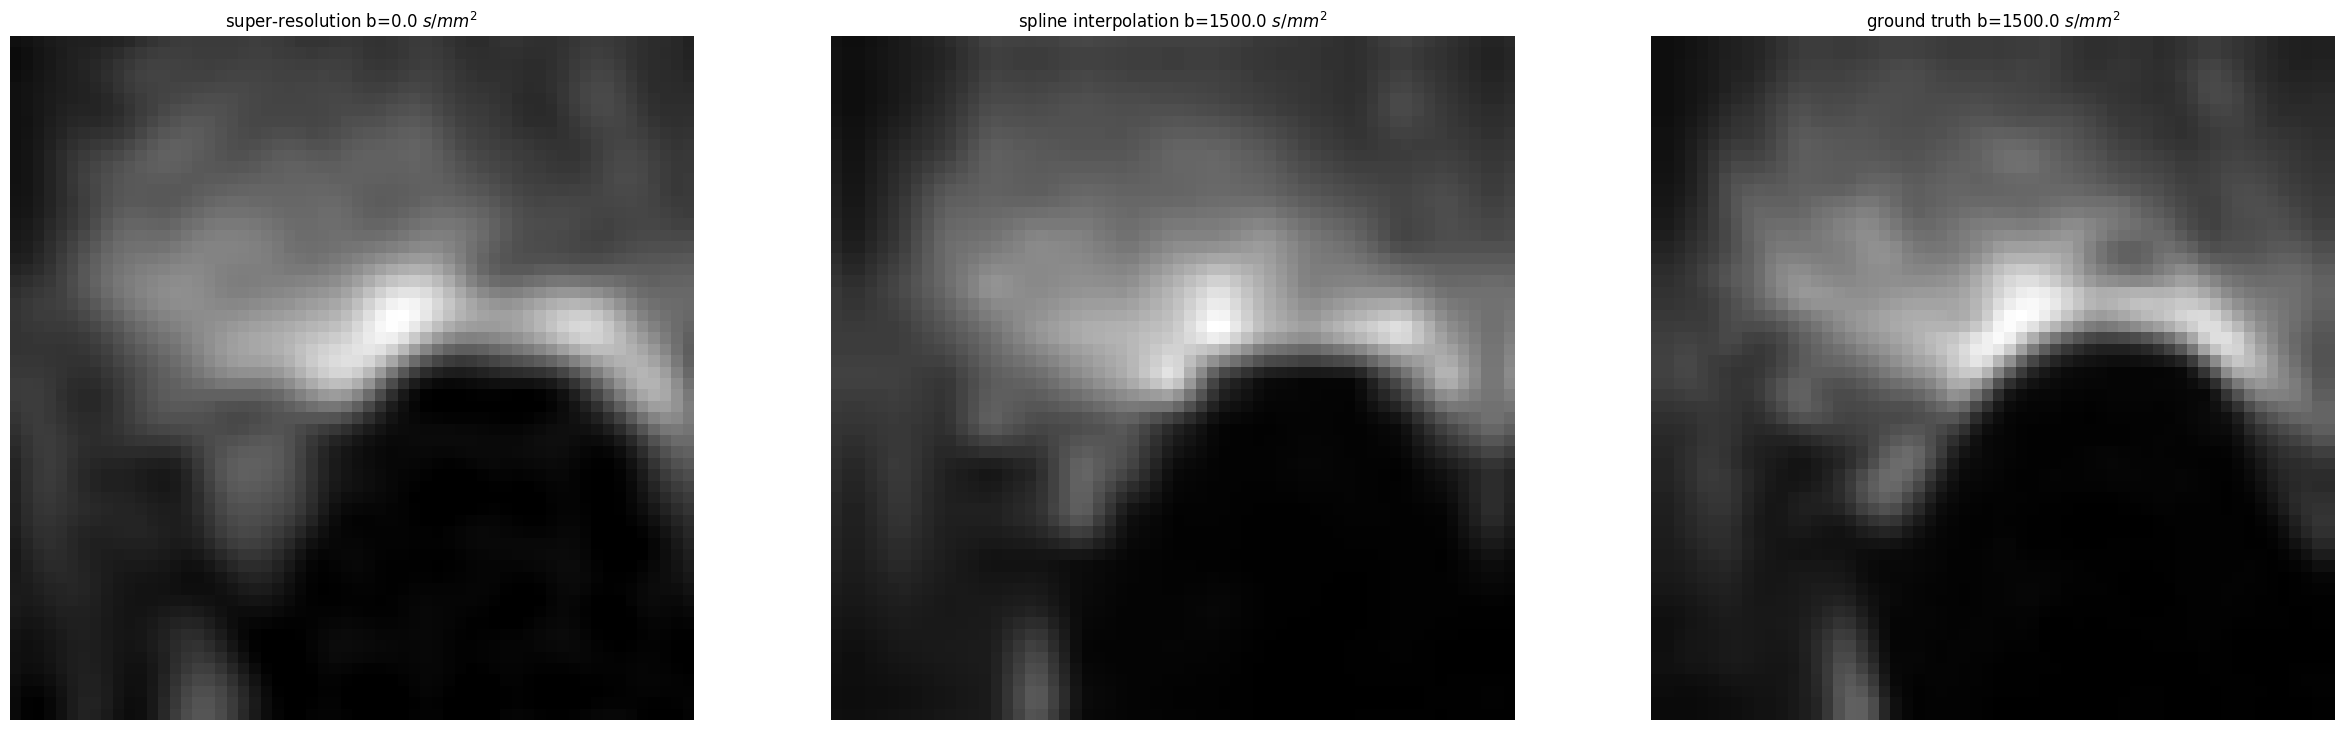

 88%|████████▊ | 2199/2500 [01:20<00:06, 43.26it/s]

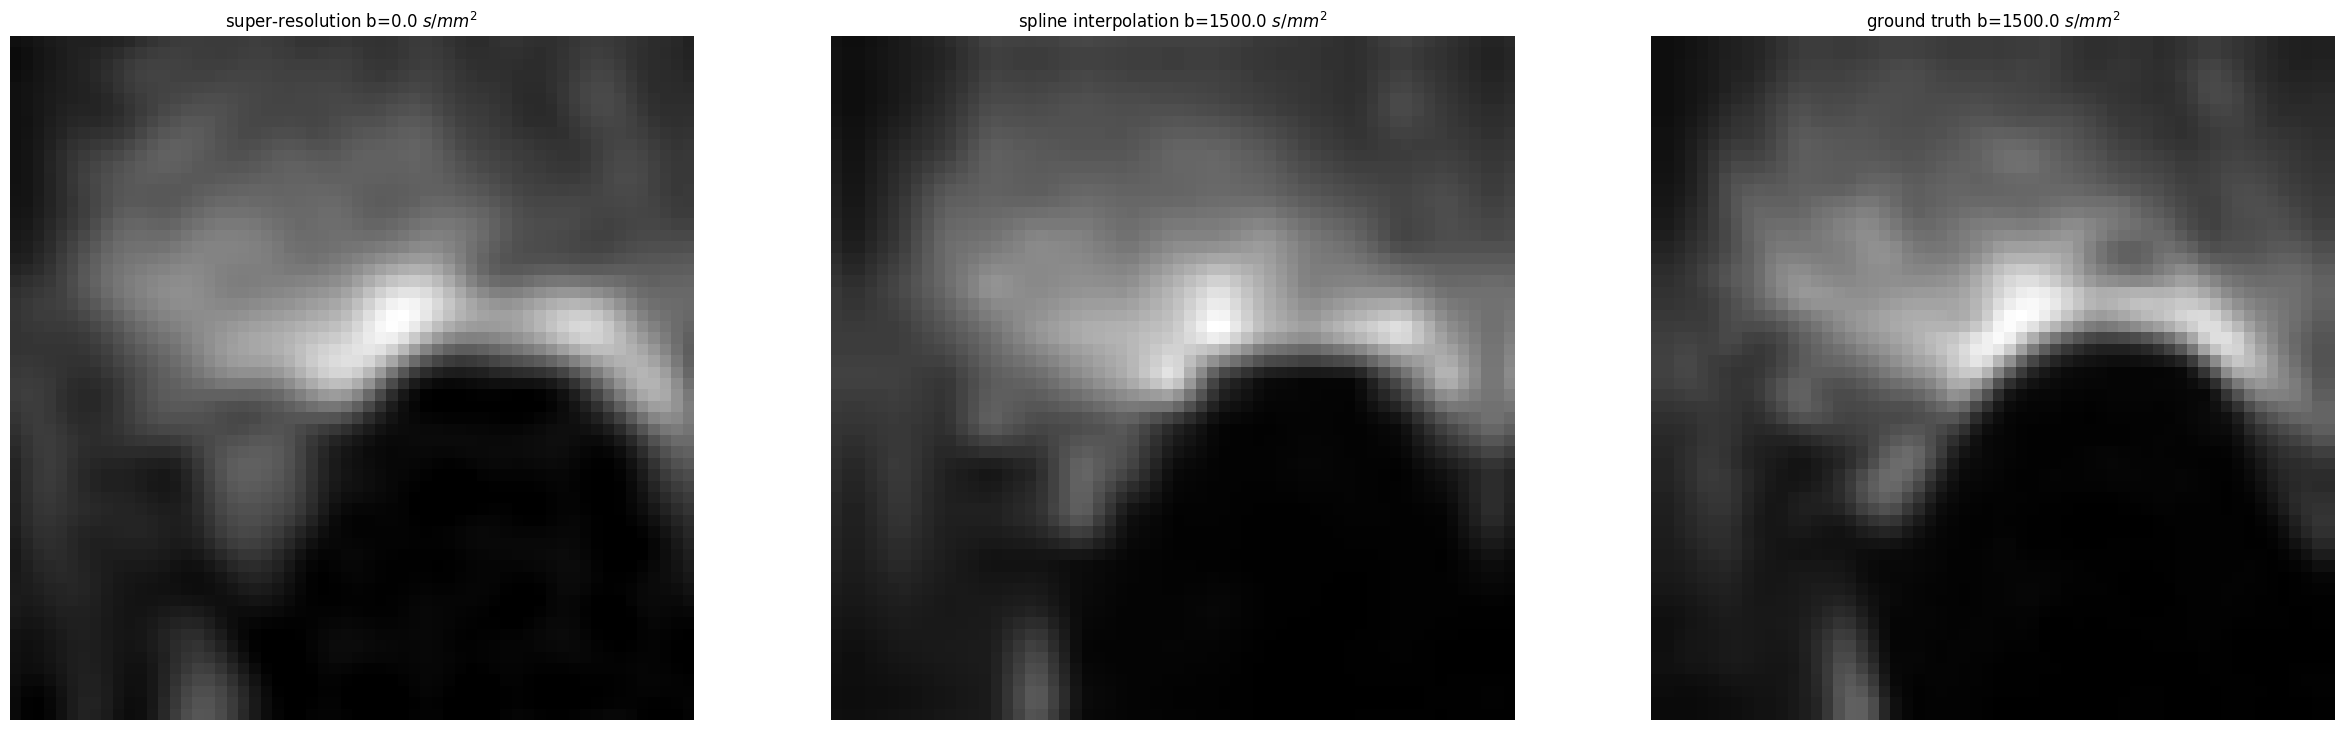

 90%|████████▉ | 2249/2500 [01:22<00:05, 43.23it/s]

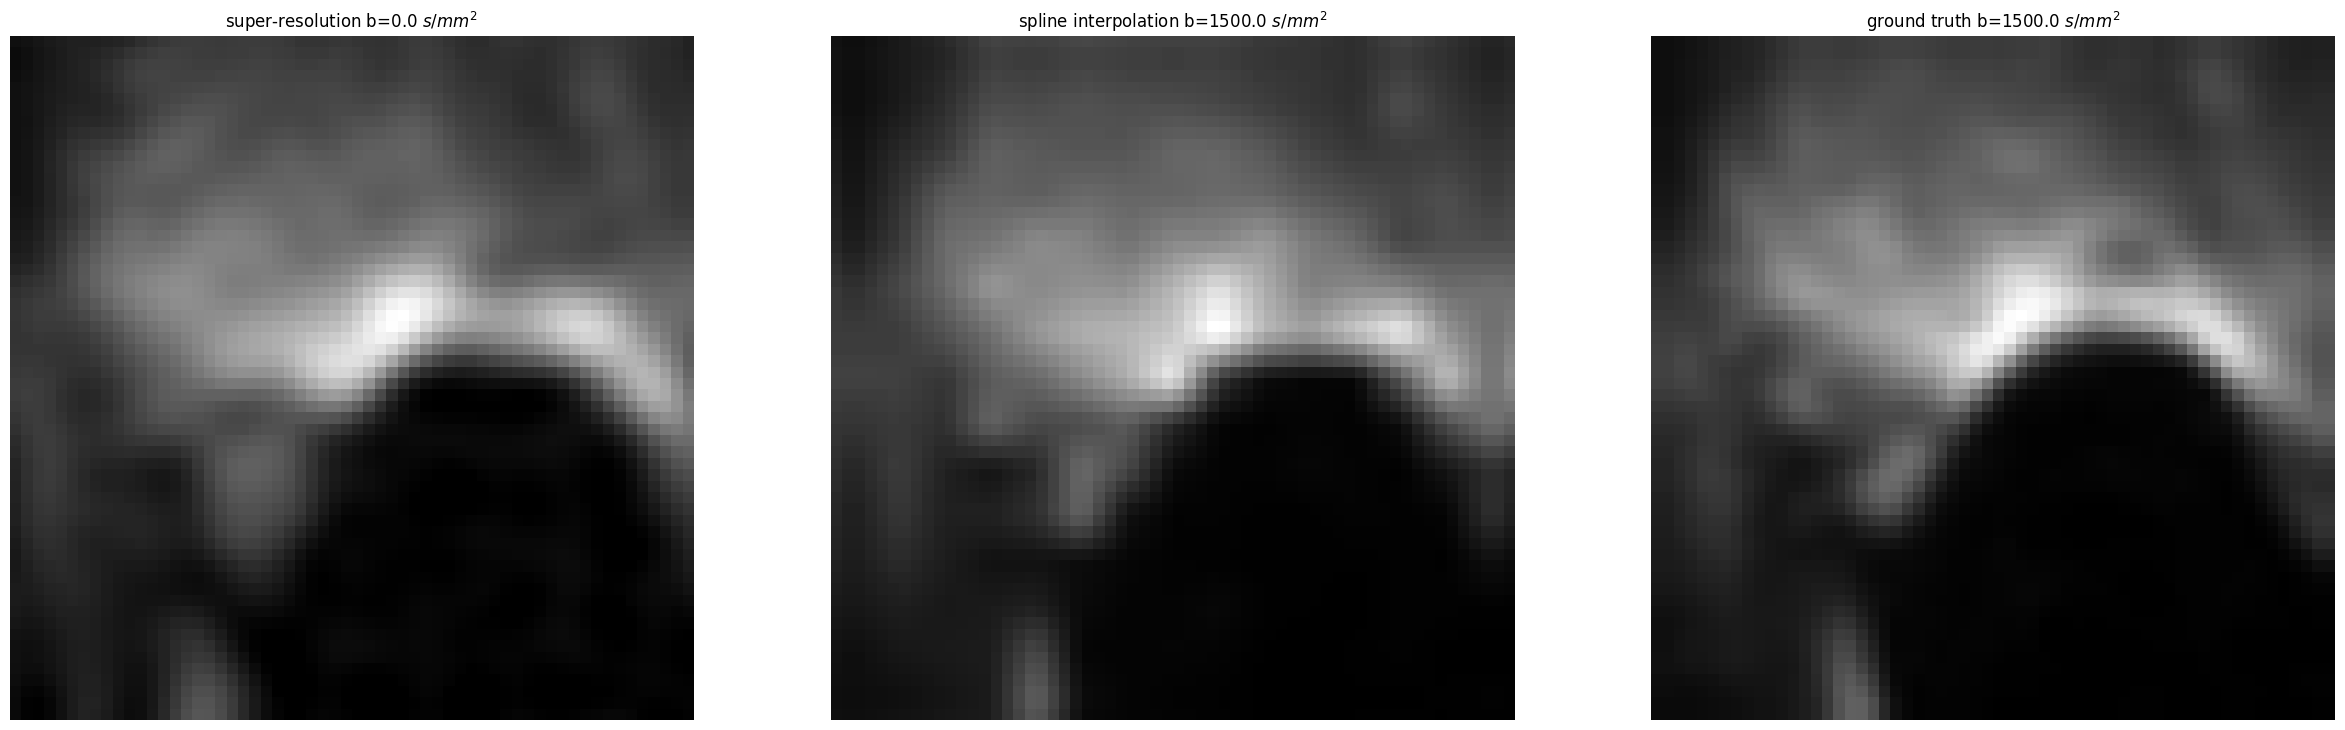

 92%|█████████▏| 2299/2500 [01:24<00:04, 43.09it/s]

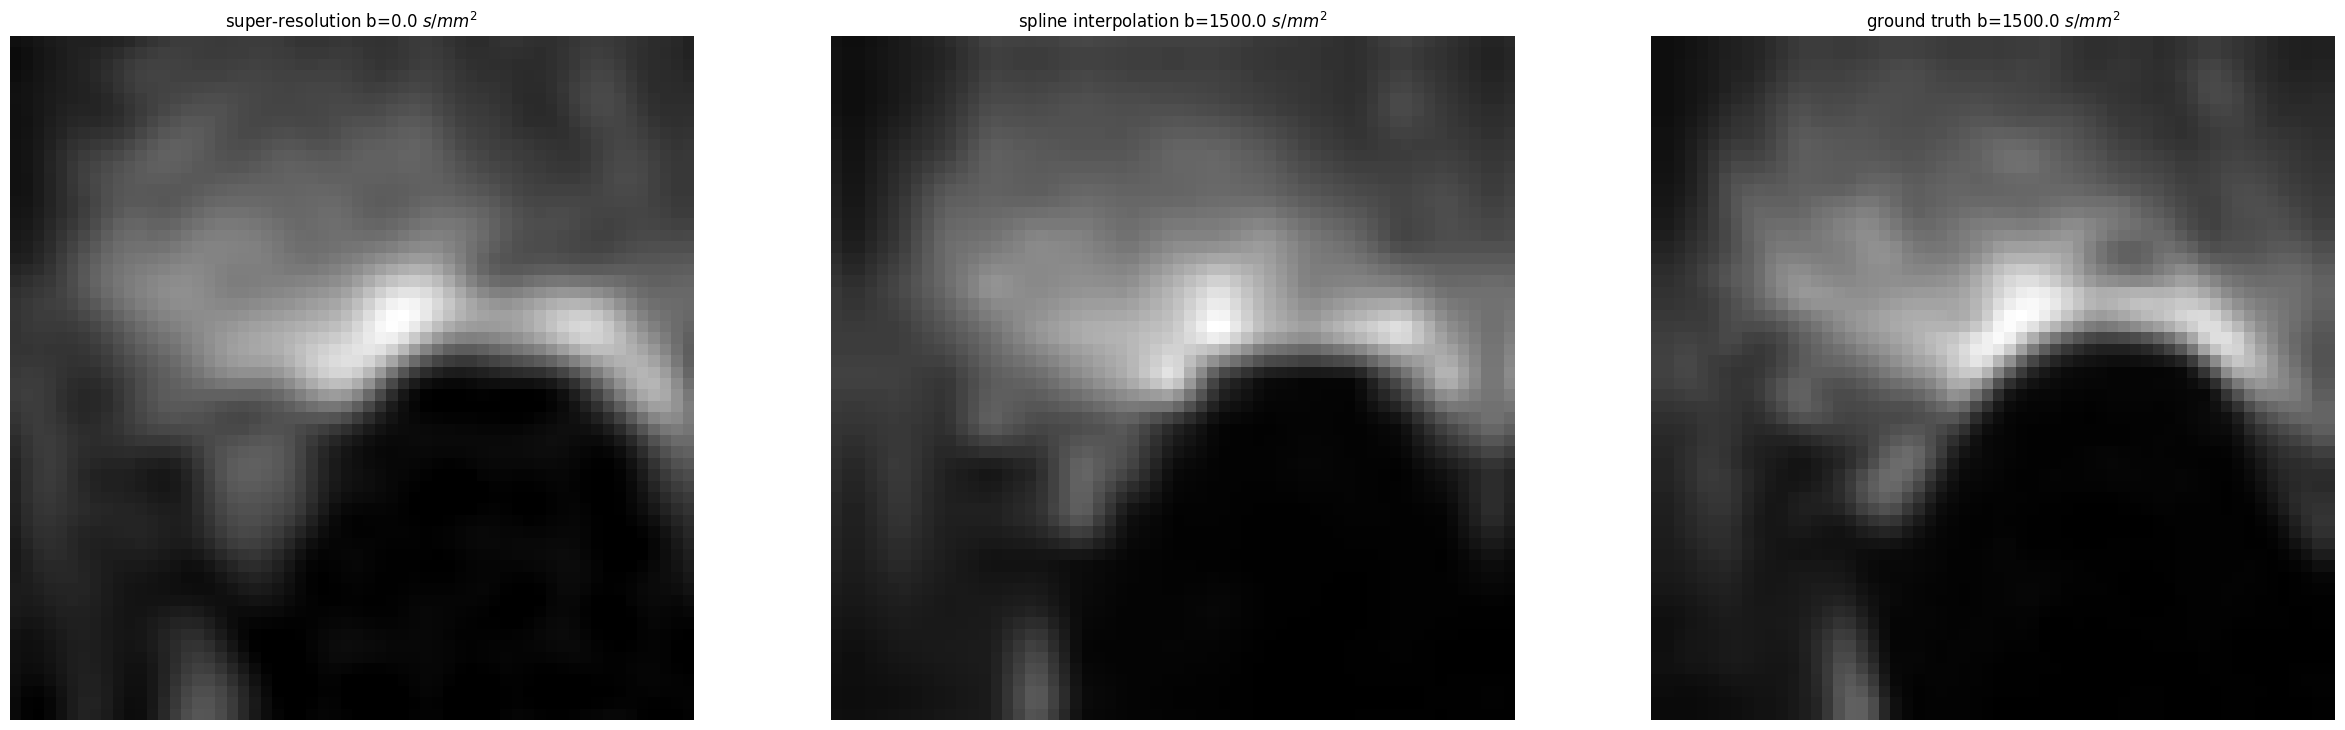

 94%|█████████▍| 2349/2500 [01:26<00:03, 43.26it/s]

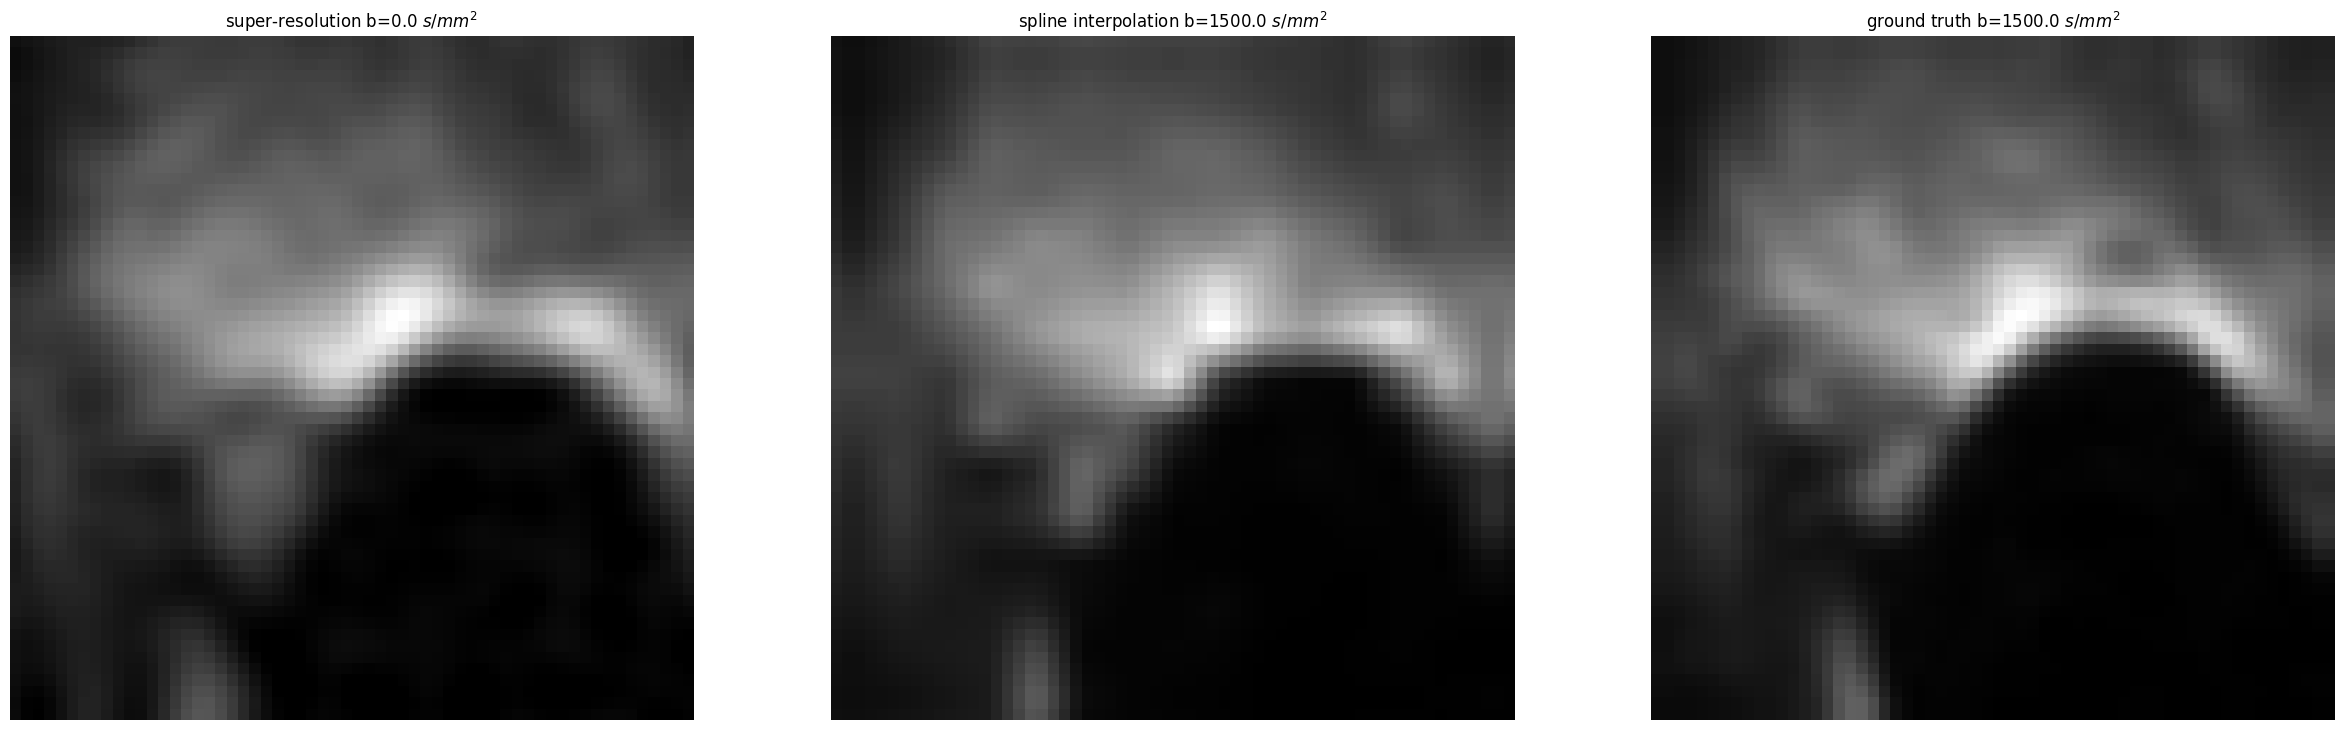

 96%|█████████▌| 2399/2500 [01:28<00:02, 43.50it/s]

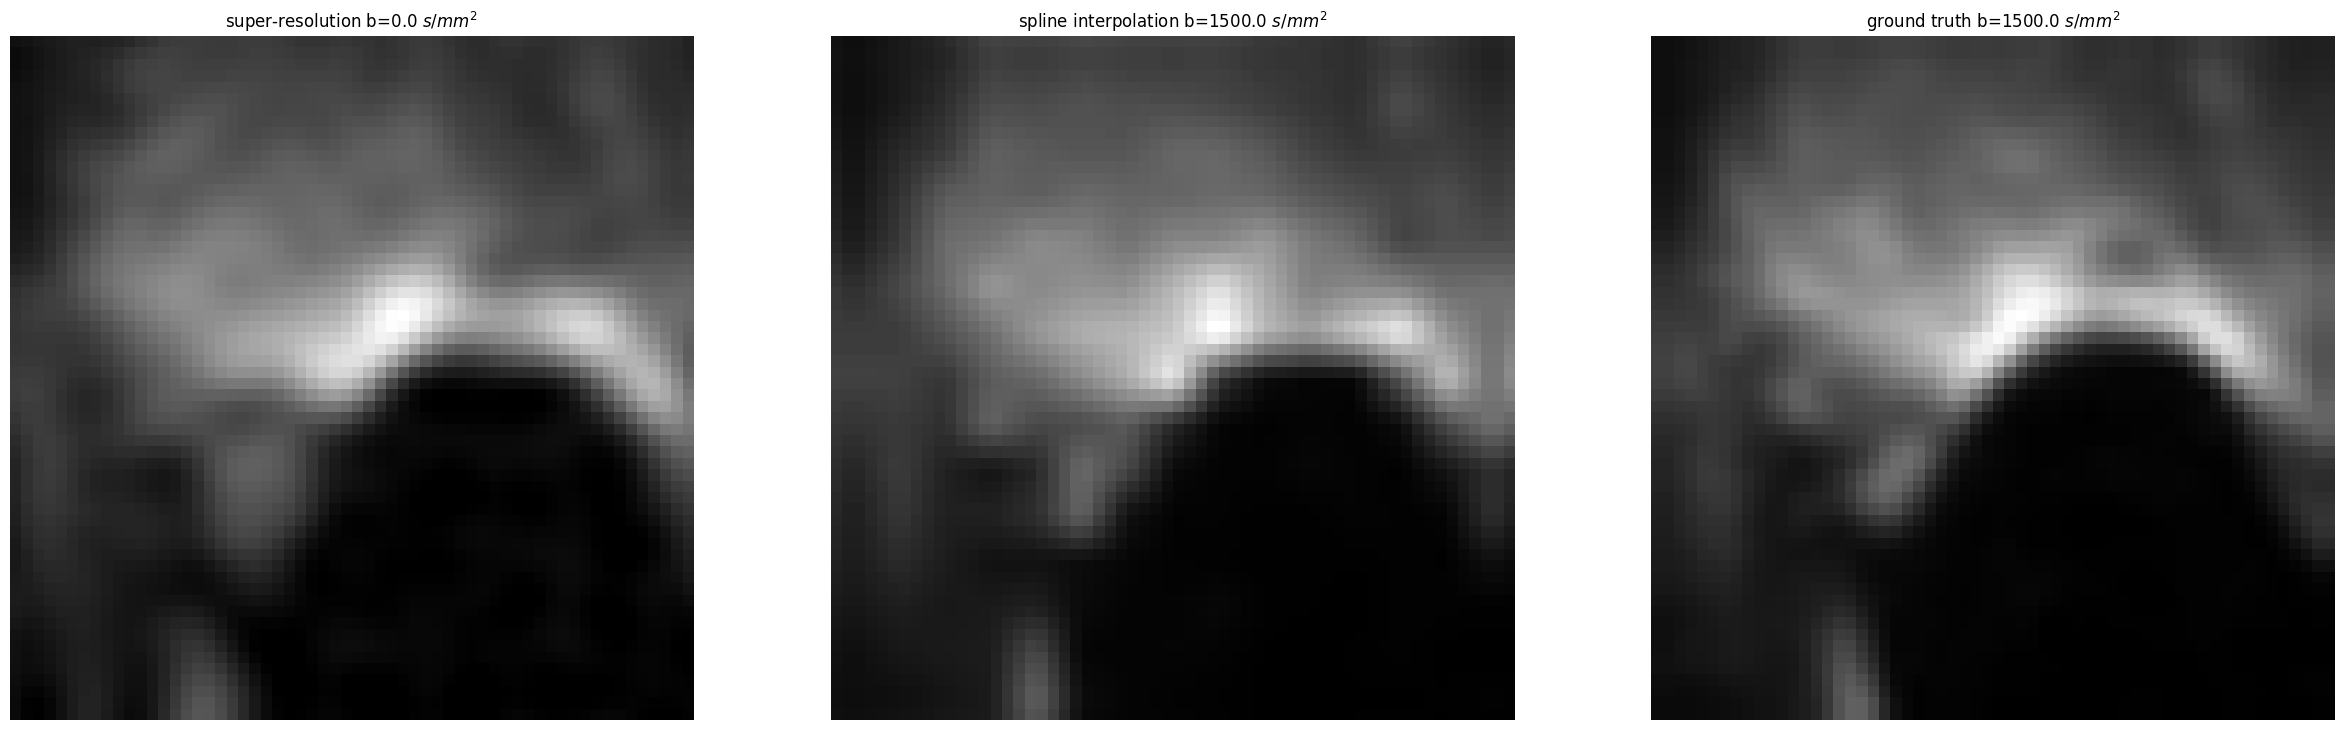

 98%|█████████▊| 2449/2500 [01:30<00:01, 39.61it/s]

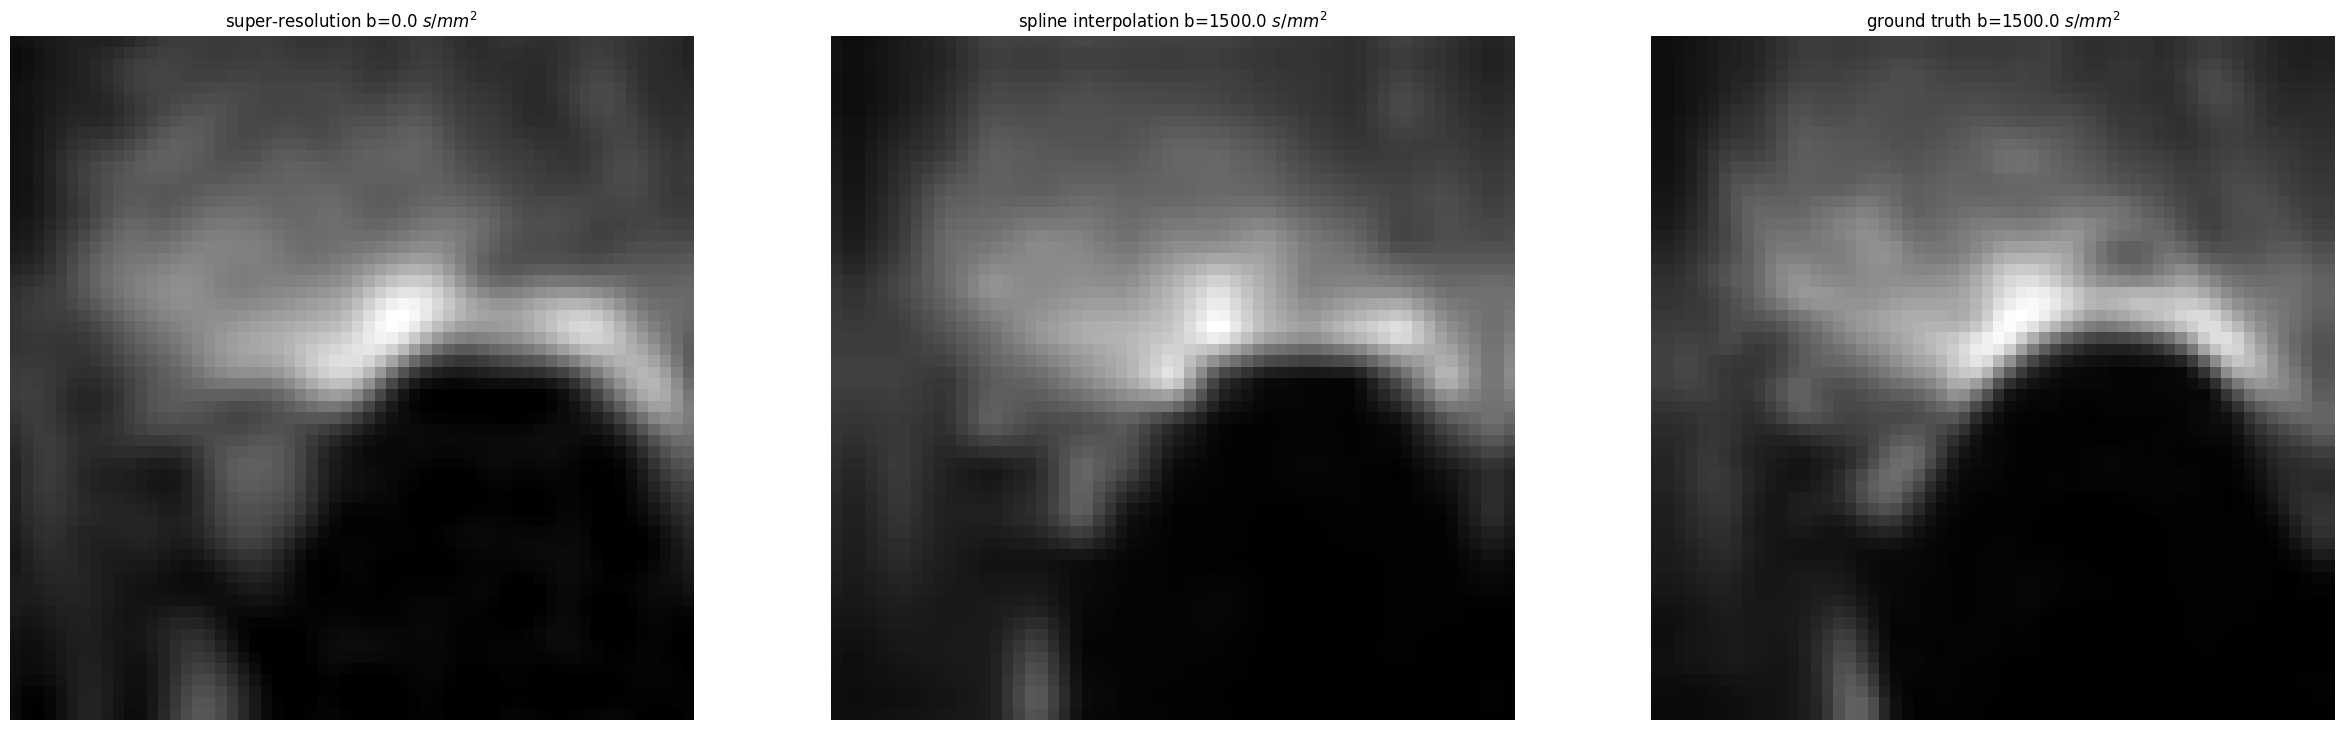

100%|██████████| 2500/2500 [01:34<00:00, 26.34it/s]


In [70]:
print(f'Training the INR and Perturb-Net for mapping size = {mapping_size} and sigma = {scale}')
for ctr in tqdm(range(number_of_epochs)):
    if ctr < number_of_epochs - pertubation_epochs:
        model_output = INR.forward(model_input)
        loss = ((model_output - LR_ground_truth)**2).mean()
        inr_optim.zero_grad()
        loss.backward()
        inr_optim.step()
    else:
        if ctr%2:
            model_output = INR.forward(model_input)
            loss = ((model_output - LR_ground_truth)**2).mean()
            inr_optim.zero_grad()
            loss.backward()
            inr_optim.step()
        else:
            for sample in range(len(dataset)):
                ground_truth  = dataset.pixels[sample].cuda()
                perturbed_input = PerturbNet.forward(model_input, sample, 1/128.)
                perturbed_input = input_mapping(perturbed_input, B)
                model_output = INR.forward(perturbed_input)

                loss = ((model_output - ground_truth)**2).mean()
                perturb_optim.zero_grad()
                loss.backward()
                perturb_optim.step()
    if not ctr%50:
        bvalues = data['b']
        recon = torch.clamp(INR.forward(test_input), min=0).cpu().view(test_input_shape).detach().numpy()
        SR_recon = torch.clamp(INR.forward(HR_model_input), min=0).cpu().view(HR.shape).detach().numpy()
        _slice = 11
        _, ax = plt.subplots(1,3, figsize=(30,40))
        b = 3
        recon_rescaled = np.zeros((test_input_shape[0], test_input_shape[1], len(bvalues)))
        HR_rescaled = np.zeros((test_input_shape[0], test_input_shape[1], len(bvalues)))
        spline_rescaled = np.zeros((test_input_shape[0], test_input_shape[1], len(bvalues)))
        ax[0].imshow(recon[:, :, _slice, b], cmap='gray')
        ax[0].set_title(f'super-resolution b={bvalues[0]} $s/mm^2$')
        ax[1].imshow(rescale(mean_img[roi_start:roi_end:2,roi_start:roi_end:2, _slice, b], 4, anti_aliasing=True), cmap='gray')
        ax[1].set_title(f'spline interpolation b={bvalues[b]} $s/mm^2$')
        ax[2].imshow(rescale(mean_img[roi_start:roi_end, roi_start:roi_end, _slice, b], 2, anti_aliasing=True), cmap='gray')
        ax[2].set_title(f'ground truth b={bvalues[b]} $s/mm^2$')
        for axi in range(3):
            ax[axi].axis('off')
        plt.show()
